# AE Experimentation

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import seaborn as sns
import torch.nn.functional as F
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from baseline_model.TimeSeriesDataset import TimeSeriesDataset

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

In [4]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "num_epochs": 1000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [5]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "metro_interstate_traffic_volume_label_encoded_no_categorical.csv")
traffic_df.shape

(28511, 5)

In [6]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(28511, 5)

### Preprocessing

In [7]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [8]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [9]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


In [10]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [11]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [12]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [13]:
class AutoencoderV1(nn.Module):
    def __init__(self, verbose=False):
        super().__init__()
        self.verbose = verbose
        # N, 12, 5
        
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(2, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=(3, 2), stride=1, padding=0)
        self.conv3 = nn.Conv2d(4, 6, kernel_size=(5, 2), stride=1, padding=0) #n, 6, 1, 1
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(6, 4, kernel_size=(5, 2), stride=1, padding=0)
        self.deconv2 = nn.ConvTranspose2d(4, 2, kernel_size=(3, 2), stride=1, padding=0)
        self.deconv3 = nn.ConvTranspose2d(2, 1, kernel_size=(2, 3), stride=2, padding=(1, 1))
    
    def forward(self, x):
        x = x.unsqueeze(1)
        
        print(f'Input after unsqueeze: {x.shape}') if self.verbose else None

        x = F.relu(self.conv1(x))
        print(f'After conv1: {x.shape}') if self.verbose else None

        x = F.relu(self.conv2(x))
        print(f'After conv2: {x.shape}') if self.verbose else None

        x = F.relu(self.conv3(x))
        print(f'After conv3: {x.shape}') if self.verbose else None


        x = F.relu(self.deconv1(x))
        print(f'After conv_tran1: {x.shape}') if self.verbose else None

        x = F.relu(self.deconv2(x))
        print(f'After conv_tran2: {x.shape}') if self.verbose else None

        x = F.sigmoid(self.deconv3(x))
        print(f'After conv_tran3: {x.shape}') if self.verbose else None

        x = x.squeeze(1)
        print(f'After squeeze: {x.shape}') if self.verbose else None
        
        return x

In [14]:
class AutoencoderV2(nn.Module):
    def __init__(self, verbose=False):
        super().__init__()
        self.verbose = verbose
        # N, 5, 12
        
        self.conv1 = nn.Conv1d(5, 5, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(5, 5, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv1d(5, 5, kernel_size=4, stride=1, padding=0)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose1d(5, 5, kernel_size=4, stride=1, padding=0)
        self.deconv2 = nn.ConvTranspose1d(5, 5, kernel_size=3, stride=1, padding=0)
        self.deconv3 = nn.ConvTranspose1d(5, 5, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        
        print(f'Input after unsqueeze and permute: {x.shape}') if self.verbose else None

        # Encoder
        x = F.relu(self.conv1(x))
        print(f'After conv1: {x.shape}') if self.verbose else None

        x = F.relu(self.conv2(x))
        print(f'After conv2: {x.shape}') if self.verbose else None

        x = F.relu(self.conv3(x))
        print(f'After conv3: {x.shape}') if self.verbose else None


        # Decoder
        x = F.relu(self.deconv1(x))
        print(f'After conv_tran1: {x.shape}') if self.verbose else None

        x = F.relu(self.deconv2(x))
        print(f'After conv_tran2: {x.shape}') if self.verbose else None

        x = F.sigmoid(self.deconv3(x))
        print(f'After conv_tran3: {x.shape}') if self.verbose else None
        
        x = x.permute(0, 2, 1)
        print(f'After re-permute: {x.shape}') if self.verbose else None

        return x

In [15]:
modelV1 = AutoencoderV1(verbose=False).to(hyperparameters['device'])

In [16]:
modelV2 = AutoencoderV2(verbose=False).to(hyperparameters['device'])

In [17]:
model = modelV2

In [18]:
if False:
    test_sample = train_seq_scaled[:32]
    
    model.eval()
    with torch.inference_mode():
        pred = model(torch.tensor(test_sample, dtype=torch.float32).to(hyperparameters['device']))
        print(pred.shape)

## Training

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

  0%|          | 1/1000 [00:03<55:54,  3.36s/it]

Epoch: 0 
 Train Loss: 0.3445166914944562 
 Val Loss: 0.30203811171349515
**************************************************


  0%|          | 2/1000 [00:06<56:42,  3.41s/it]

Epoch: 1 
 Train Loss: 0.2056032993724938 
 Val Loss: 0.16873408284749877
**************************************************


  0%|          | 3/1000 [00:10<56:46,  3.42s/it]

Epoch: 2 
 Train Loss: 0.16253604491203397 
 Val Loss: 0.16454346595185526
**************************************************


  0%|          | 4/1000 [00:13<56:48,  3.42s/it]

Epoch: 3 
 Train Loss: 0.15756807232805922 
 Val Loss: 0.16230910413720634
**************************************************


  0%|          | 5/1000 [00:17<57:51,  3.49s/it]

Epoch: 4 
 Train Loss: 0.15521113938151704 
 Val Loss: 0.15974048290694698
**************************************************


  1%|          | 6/1000 [00:20<57:31,  3.47s/it]

Epoch: 5 
 Train Loss: 0.15363201405983654 
 Val Loss: 0.1577800717414095
**************************************************


  1%|          | 7/1000 [00:24<56:55,  3.44s/it]

Epoch: 6 
 Train Loss: 0.1523605644765609 
 Val Loss: 0.1560531672969293
**************************************************


  1%|          | 8/1000 [00:27<56:21,  3.41s/it]

Epoch: 7 
 Train Loss: 0.15104990545529637 
 Val Loss: 0.15404002159164193
**************************************************


  1%|          | 9/1000 [00:31<59:03,  3.58s/it]

Epoch: 8 
 Train Loss: 0.14991390007073882 
 Val Loss: 0.15234884535998441
**************************************************


  1%|          | 10/1000 [00:35<1:02:15,  3.77s/it]

Epoch: 9 
 Train Loss: 0.1487684817292413 
 Val Loss: 0.15082642921570982
**************************************************


  1%|          | 11/1000 [00:38<56:41,  3.44s/it]  

Epoch: 10 
 Train Loss: 0.1474801995497599 
 Val Loss: 0.1492389329196362
**************************************************


  1%|          | 12/1000 [00:41<56:29,  3.43s/it]

Epoch: 11 
 Train Loss: 0.14593156564035054 
 Val Loss: 0.1477128207850992
**************************************************


  1%|▏         | 13/1000 [00:45<57:12,  3.48s/it]

Epoch: 12 
 Train Loss: 0.14413466639973505 
 Val Loss: 0.14615690657931768
**************************************************


  1%|▏         | 14/1000 [00:47<53:20,  3.25s/it]

Epoch: 13 
 Train Loss: 0.1423046824641181 
 Val Loss: 0.14489583235778167
**************************************************


  2%|▏         | 15/1000 [00:51<53:04,  3.23s/it]

Epoch: 14 
 Train Loss: 0.14060708040274877 
 Val Loss: 0.1440011678117045
**************************************************


  2%|▏         | 16/1000 [00:54<51:15,  3.13s/it]

Epoch: 15 
 Train Loss: 0.13903317401945842 
 Val Loss: 0.14340654400627265
**************************************************


  2%|▏         | 17/1000 [00:58<55:18,  3.38s/it]

Epoch: 16 
 Train Loss: 0.1375130594382781 
 Val Loss: 0.14296383812521282
**************************************************


  2%|▏         | 18/1000 [01:01<54:40,  3.34s/it]

Epoch: 17 
 Train Loss: 0.13594497531276264 
 Val Loss: 0.14267640443665258
**************************************************


  2%|▏         | 19/1000 [01:04<51:48,  3.17s/it]

Epoch: 18 
 Train Loss: 0.13431574524410309 
 Val Loss: 0.1423121252086725
**************************************************


  2%|▏         | 20/1000 [01:07<53:29,  3.27s/it]

Epoch: 19 
 Train Loss: 0.13258031558710429 
 Val Loss: 0.14171019347196215
**************************************************


  2%|▏         | 21/1000 [01:11<55:03,  3.37s/it]

Epoch: 20 
 Train Loss: 0.130859022304353 
 Val Loss: 0.1410707389370779
**************************************************


  2%|▏         | 22/1000 [01:14<53:38,  3.29s/it]

Epoch: 21 
 Train Loss: 0.12905403897479742 
 Val Loss: 0.14040365781676903
**************************************************


  2%|▏         | 23/1000 [01:17<52:55,  3.25s/it]

Epoch: 22 
 Train Loss: 0.1270520197329481 
 Val Loss: 0.13936986824434794
**************************************************


  2%|▏         | 24/1000 [01:20<51:05,  3.14s/it]

Epoch: 23 
 Train Loss: 0.12491635769751931 
 Val Loss: 0.13850914167889047
**************************************************


  2%|▎         | 25/1000 [01:23<53:28,  3.29s/it]

Epoch: 24 
 Train Loss: 0.12275849511588272 
 Val Loss: 0.13765964481268037
**************************************************


  3%|▎         | 26/1000 [01:27<55:04,  3.39s/it]

Epoch: 25 
 Train Loss: 0.12046725755925768 
 Val Loss: 0.13692919131410256
**************************************************


  3%|▎         | 27/1000 [01:30<53:49,  3.32s/it]

Epoch: 26 
 Train Loss: 0.11810494566448608 
 Val Loss: 0.13645296485236522
**************************************************


  3%|▎         | 28/1000 [01:34<53:49,  3.32s/it]

Epoch: 27 
 Train Loss: 0.11601814214887325 
 Val Loss: 0.136069560235136
**************************************************


  3%|▎         | 29/1000 [01:37<52:45,  3.26s/it]

Epoch: 28 
 Train Loss: 0.11438607758363033 
 Val Loss: 0.13564595102928997
**************************************************


  3%|▎         | 30/1000 [01:40<54:32,  3.37s/it]

Epoch: 29 
 Train Loss: 0.11302643659071367 
 Val Loss: 0.13527716202347467
**************************************************


  3%|▎         | 31/1000 [01:43<51:43,  3.20s/it]

Epoch: 30 
 Train Loss: 0.11185251726007395 
 Val Loss: 0.13496799716788732
**************************************************


  3%|▎         | 32/1000 [01:47<53:22,  3.31s/it]

Epoch: 31 
 Train Loss: 0.11094551909647014 
 Val Loss: 0.1343325615096628
**************************************************


  3%|▎         | 33/1000 [01:50<53:06,  3.30s/it]

Epoch: 32 
 Train Loss: 0.11032985582905933 
 Val Loss: 0.13311542545476657
**************************************************


  3%|▎         | 34/1000 [01:53<54:10,  3.37s/it]

Epoch: 33 
 Train Loss: 0.10988260439347586 
 Val Loss: 0.13157010739773847
**************************************************


  4%|▎         | 35/1000 [01:57<55:36,  3.46s/it]

Epoch: 34 
 Train Loss: 0.10944880820486856 
 Val Loss: 0.13000716511787994
**************************************************


  4%|▎         | 36/1000 [02:01<56:17,  3.50s/it]

Epoch: 35 
 Train Loss: 0.10894627702980189 
 Val Loss: 0.12869104173746002
**************************************************


  4%|▎         | 37/1000 [02:04<53:56,  3.36s/it]

Epoch: 36 
 Train Loss: 0.10836472881626114 
 Val Loss: 0.12764932382642552
**************************************************


  4%|▍         | 38/1000 [02:07<53:03,  3.31s/it]

Epoch: 37 
 Train Loss: 0.10770878638826614 
 Val Loss: 0.12657446196574842
**************************************************


  4%|▍         | 39/1000 [02:11<54:16,  3.39s/it]

Epoch: 38 
 Train Loss: 0.10699982982426673 
 Val Loss: 0.12558018784509617
**************************************************


  4%|▍         | 40/1000 [02:13<51:41,  3.23s/it]

Epoch: 39 
 Train Loss: 0.10627489632092217 
 Val Loss: 0.12462094677298256
**************************************************


  4%|▍         | 41/1000 [02:17<53:27,  3.34s/it]

Epoch: 40 
 Train Loss: 0.10560850189348257 
 Val Loss: 0.12371678290407309
**************************************************


  4%|▍         | 42/1000 [02:20<52:09,  3.27s/it]

Epoch: 41 
 Train Loss: 0.10501859545038927 
 Val Loss: 0.12296957413801986
**************************************************


  4%|▍         | 43/1000 [02:23<50:28,  3.16s/it]

Epoch: 42 
 Train Loss: 0.10453713564058507 
 Val Loss: 0.12216789325636425
**************************************************


  4%|▍         | 44/1000 [02:26<50:56,  3.20s/it]

Epoch: 43 
 Train Loss: 0.10414641801408932 
 Val Loss: 0.12141875596193785
**************************************************


  4%|▍         | 45/1000 [02:29<49:58,  3.14s/it]

Epoch: 44 
 Train Loss: 0.10381597364099296 
 Val Loss: 0.12079296118757699
**************************************************


  5%|▍         | 46/1000 [02:33<51:30,  3.24s/it]

Epoch: 45 
 Train Loss: 0.10354189538144798 
 Val Loss: 0.12023333108492112
**************************************************


  5%|▍         | 47/1000 [02:36<53:00,  3.34s/it]

Epoch: 46 
 Train Loss: 0.10328621011838672 
 Val Loss: 0.11974775523282169
**************************************************


  5%|▍         | 48/1000 [02:39<51:48,  3.27s/it]

Epoch: 47 
 Train Loss: 0.1030640260931653 
 Val Loss: 0.11936065035589626
**************************************************


  5%|▍         | 49/1000 [02:43<51:00,  3.22s/it]

Epoch: 48 
 Train Loss: 0.10286102212474356 
 Val Loss: 0.1189238837595736
**************************************************


  5%|▌         | 50/1000 [02:46<53:03,  3.35s/it]

Epoch: 49 
 Train Loss: 0.10267600977236893 
 Val Loss: 0.11849786885333864
**************************************************


  5%|▌         | 51/1000 [02:50<53:45,  3.40s/it]

Epoch: 50 
 Train Loss: 0.10248981195738406 
 Val Loss: 0.11812628755408726
**************************************************


  5%|▌         | 52/1000 [02:53<51:45,  3.28s/it]

Epoch: 51 
 Train Loss: 0.10232223534818118 
 Val Loss: 0.11773441773786973
**************************************************


  5%|▌         | 53/1000 [02:56<52:33,  3.33s/it]

Epoch: 52 
 Train Loss: 0.10215500820046722 
 Val Loss: 0.11736974555454897
**************************************************


  5%|▌         | 54/1000 [02:59<50:05,  3.18s/it]

Epoch: 53 
 Train Loss: 0.10199042365770018 
 Val Loss: 0.11705704309632269
**************************************************


  6%|▌         | 55/1000 [03:02<51:17,  3.26s/it]

Epoch: 54 
 Train Loss: 0.1018312286068313 
 Val Loss: 0.11675256406993009
**************************************************


  6%|▌         | 56/1000 [03:05<50:13,  3.19s/it]

Epoch: 55 
 Train Loss: 0.10166620025816171 
 Val Loss: 0.11645112948471241
**************************************************


  6%|▌         | 57/1000 [03:09<51:11,  3.26s/it]

Epoch: 56 
 Train Loss: 0.10150122005612619 
 Val Loss: 0.11617475505290406
**************************************************


  6%|▌         | 58/1000 [03:13<53:51,  3.43s/it]

Epoch: 57 
 Train Loss: 0.10133463795313828 
 Val Loss: 0.11586215656794858
**************************************************


  6%|▌         | 59/1000 [03:16<51:38,  3.29s/it]

Epoch: 58 
 Train Loss: 0.10116543027808757 
 Val Loss: 0.11553399080640814
**************************************************


  6%|▌         | 60/1000 [03:19<50:01,  3.19s/it]

Epoch: 59 
 Train Loss: 0.10098856662989164 
 Val Loss: 0.1152004823088646
**************************************************


  6%|▌         | 61/1000 [03:22<49:36,  3.17s/it]

Epoch: 60 
 Train Loss: 0.1008058233659448 
 Val Loss: 0.11489074635371734
**************************************************


  6%|▌         | 62/1000 [03:26<52:30,  3.36s/it]

Epoch: 61 
 Train Loss: 0.10062053327828771 
 Val Loss: 0.11458881048673994
**************************************************


  6%|▋         | 63/1000 [03:28<50:06,  3.21s/it]

Epoch: 62 
 Train Loss: 0.10042294289336799 
 Val Loss: 0.11421508434113492
**************************************************


  6%|▋         | 64/1000 [03:32<50:28,  3.24s/it]

Epoch: 63 
 Train Loss: 0.10020172955444785 
 Val Loss: 0.11379503324795305
**************************************************


  6%|▋         | 65/1000 [03:35<48:55,  3.14s/it]

Epoch: 64 
 Train Loss: 0.09995044788755843 
 Val Loss: 0.11335206408514066
**************************************************


  7%|▋         | 66/1000 [03:38<51:17,  3.29s/it]

Epoch: 65 
 Train Loss: 0.09965596990699019 
 Val Loss: 0.11286391116929857
**************************************************


  7%|▋         | 67/1000 [03:42<51:45,  3.33s/it]

Epoch: 66 
 Train Loss: 0.09931475781479022 
 Val Loss: 0.11234376956237836
**************************************************


  7%|▋         | 68/1000 [03:45<49:50,  3.21s/it]

Epoch: 67 
 Train Loss: 0.09892105230693228 
 Val Loss: 0.11176288086041976
**************************************************


  7%|▋         | 69/1000 [03:48<50:57,  3.28s/it]

Epoch: 68 
 Train Loss: 0.09849046564662273 
 Val Loss: 0.11123756863427965
**************************************************


  7%|▋         | 70/1000 [03:52<51:36,  3.33s/it]

Epoch: 69 
 Train Loss: 0.09803196989511875 
 Val Loss: 0.11064806982372584
**************************************************


  7%|▋         | 71/1000 [03:55<52:00,  3.36s/it]

Epoch: 70 
 Train Loss: 0.09753456874260728 
 Val Loss: 0.11017409293504243
**************************************************


  7%|▋         | 72/1000 [03:58<52:36,  3.40s/it]

Epoch: 71 
 Train Loss: 0.09702425320511279 
 Val Loss: 0.1097064981802126
**************************************************


  7%|▋         | 73/1000 [04:02<51:51,  3.36s/it]

Epoch: 72 
 Train Loss: 0.09650599969574479 
 Val Loss: 0.10932284015952871
**************************************************


  7%|▋         | 74/1000 [04:05<52:38,  3.41s/it]

Epoch: 73 
 Train Loss: 0.09597795949870039 
 Val Loss: 0.10902403487583225
**************************************************


  8%|▊         | 75/1000 [04:08<50:28,  3.27s/it]

Epoch: 74 
 Train Loss: 0.09544897019382446 
 Val Loss: 0.10873933186691799
**************************************************


  8%|▊         | 76/1000 [04:11<49:45,  3.23s/it]

Epoch: 75 
 Train Loss: 0.09493399325230513 
 Val Loss: 0.10846447726983703
**************************************************


  8%|▊         | 77/1000 [04:15<49:40,  3.23s/it]

Epoch: 76 
 Train Loss: 0.09443921318374375 
 Val Loss: 0.10812360676151983
**************************************************


  8%|▊         | 78/1000 [04:18<50:22,  3.28s/it]

Epoch: 77 
 Train Loss: 0.09393928462814483 
 Val Loss: 0.1078075517931681
**************************************************


  8%|▊         | 79/1000 [04:21<48:51,  3.18s/it]

Epoch: 78 
 Train Loss: 0.0934393539982959 
 Val Loss: 0.10747322080175528
**************************************************


  8%|▊         | 80/1000 [04:24<47:40,  3.11s/it]

Epoch: 79 
 Train Loss: 0.09291881571039244 
 Val Loss: 0.10712868000349302
**************************************************


  8%|▊         | 81/1000 [04:27<47:54,  3.13s/it]

Epoch: 80 
 Train Loss: 0.09236935060601917 
 Val Loss: 0.10673261291525338
**************************************************


  8%|▊         | 82/1000 [04:30<46:47,  3.06s/it]

Epoch: 81 
 Train Loss: 0.09182461397657053 
 Val Loss: 0.10624759485212605
**************************************************


  8%|▊         | 83/1000 [04:33<47:41,  3.12s/it]

Epoch: 82 
 Train Loss: 0.09126377254097526 
 Val Loss: 0.10560539335514722
**************************************************


  8%|▊         | 84/1000 [04:37<49:26,  3.24s/it]

Epoch: 83 
 Train Loss: 0.09068868649133376 
 Val Loss: 0.10484587066294102
**************************************************


  8%|▊         | 85/1000 [04:41<52:28,  3.44s/it]

Epoch: 84 
 Train Loss: 0.09010600970292576 
 Val Loss: 0.10400257782822245
**************************************************


  9%|▊         | 86/1000 [04:44<52:23,  3.44s/it]

Epoch: 85 
 Train Loss: 0.08952746646110422 
 Val Loss: 0.10305143520236015
**************************************************


  9%|▊         | 87/1000 [04:47<50:42,  3.33s/it]

Epoch: 86 
 Train Loss: 0.08894572079672804 
 Val Loss: 0.10222968697715341
**************************************************


  9%|▉         | 88/1000 [04:50<50:02,  3.29s/it]

Epoch: 87 
 Train Loss: 0.08839370833571379 
 Val Loss: 0.10134369252103098
**************************************************


  9%|▉         | 89/1000 [04:53<47:50,  3.15s/it]

Epoch: 88 
 Train Loss: 0.08784825139291072 
 Val Loss: 0.10043693689650364
**************************************************


  9%|▉         | 90/1000 [04:56<48:21,  3.19s/it]

Epoch: 89 
 Train Loss: 0.08730813015518817 
 Val Loss: 0.09954180099656072
**************************************************


  9%|▉         | 91/1000 [05:00<48:12,  3.18s/it]

Epoch: 90 
 Train Loss: 0.08677889062366011 
 Val Loss: 0.09869276962420914
**************************************************


  9%|▉         | 92/1000 [05:03<47:38,  3.15s/it]

Epoch: 91 
 Train Loss: 0.08624698761928967 
 Val Loss: 0.09790967011384749
**************************************************


  9%|▉         | 93/1000 [05:06<47:56,  3.17s/it]

Epoch: 92 
 Train Loss: 0.08573598740948953 
 Val Loss: 0.09702169095699707
**************************************************


  9%|▉         | 94/1000 [05:09<47:30,  3.15s/it]

Epoch: 93 
 Train Loss: 0.0852271882976506 
 Val Loss: 0.09626080861754632
**************************************************


 10%|▉         | 95/1000 [05:12<48:17,  3.20s/it]

Epoch: 94 
 Train Loss: 0.0847332111022959 
 Val Loss: 0.09546432736214627
**************************************************


 10%|▉         | 96/1000 [05:15<48:05,  3.19s/it]

Epoch: 95 
 Train Loss: 0.08424972789035522 
 Val Loss: 0.09475398992889383
**************************************************


 10%|▉         | 97/1000 [05:19<49:10,  3.27s/it]

Epoch: 96 
 Train Loss: 0.08378260784363178 
 Val Loss: 0.09391470245096122
**************************************************


 10%|▉         | 98/1000 [05:22<48:20,  3.22s/it]

Epoch: 97 
 Train Loss: 0.0832526473874464 
 Val Loss: 0.09313001935736517
**************************************************


 10%|▉         | 99/1000 [05:26<50:36,  3.37s/it]

Epoch: 98 
 Train Loss: 0.08276023526857561 
 Val Loss: 0.0924847854322262
**************************************************


 10%|█         | 100/1000 [05:29<50:10,  3.34s/it]

Epoch: 99 
 Train Loss: 0.08229925813934495 
 Val Loss: 0.09182714934596854
**************************************************


 10%|█         | 101/1000 [05:32<50:18,  3.36s/it]

Epoch: 100 
 Train Loss: 0.0818414004443822 
 Val Loss: 0.09123879005567412
**************************************************


 10%|█         | 102/1000 [05:36<52:26,  3.50s/it]

Epoch: 101 
 Train Loss: 0.08138839917474258 
 Val Loss: 0.09054849405636949
**************************************************


 10%|█         | 103/1000 [05:39<49:58,  3.34s/it]

Epoch: 102 
 Train Loss: 0.08093658985431616 
 Val Loss: 0.08985224516873949
**************************************************


 10%|█         | 104/1000 [05:42<49:42,  3.33s/it]

Epoch: 103 
 Train Loss: 0.08048748558316625 
 Val Loss: 0.08905473523093073
**************************************************


 10%|█         | 105/1000 [05:46<48:23,  3.24s/it]

Epoch: 104 
 Train Loss: 0.0800328380147421 
 Val Loss: 0.08832851487599062
**************************************************


 11%|█         | 106/1000 [05:49<47:08,  3.16s/it]

Epoch: 105 
 Train Loss: 0.07956697626710774 
 Val Loss: 0.08754141938485456
**************************************************


 11%|█         | 107/1000 [05:52<47:45,  3.21s/it]

Epoch: 106 
 Train Loss: 0.07909606008164763 
 Val Loss: 0.08678007623955106
**************************************************


 11%|█         | 108/1000 [05:55<46:23,  3.12s/it]

Epoch: 107 
 Train Loss: 0.07861400856721368 
 Val Loss: 0.0860690793043442
**************************************************


 11%|█         | 109/1000 [05:58<46:28,  3.13s/it]

Epoch: 108 
 Train Loss: 0.07812734426823438 
 Val Loss: 0.08548704405011756
**************************************************


 11%|█         | 110/1000 [06:01<46:51,  3.16s/it]

Epoch: 109 
 Train Loss: 0.0776469177980535 
 Val Loss: 0.08470712844910247
**************************************************


 11%|█         | 111/1000 [06:04<47:29,  3.20s/it]

Epoch: 110 
 Train Loss: 0.07715370707203428 
 Val Loss: 0.08408861988213624
**************************************************


 11%|█         | 112/1000 [06:08<48:09,  3.25s/it]

Epoch: 111 
 Train Loss: 0.07666732014260068 
 Val Loss: 0.08335922005471219
**************************************************


 11%|█▏        | 113/1000 [06:11<48:31,  3.28s/it]

Epoch: 112 
 Train Loss: 0.0761757565617854 
 Val Loss: 0.08263011561350876
**************************************************


 11%|█▏        | 114/1000 [06:14<46:49,  3.17s/it]

Epoch: 113 
 Train Loss: 0.07568785397996826 
 Val Loss: 0.0819906040272686
**************************************************


 12%|█▏        | 115/1000 [06:17<46:52,  3.18s/it]

Epoch: 114 
 Train Loss: 0.07520459186113315 
 Val Loss: 0.08140433424811684
**************************************************


 12%|█▏        | 116/1000 [06:20<46:21,  3.15s/it]

Epoch: 115 
 Train Loss: 0.07471974031819452 
 Val Loss: 0.08082403795103009
**************************************************


 12%|█▏        | 117/1000 [06:23<46:17,  3.15s/it]

Epoch: 116 
 Train Loss: 0.07422900014409343 
 Val Loss: 0.08027474117580424
**************************************************


 12%|█▏        | 118/1000 [06:27<45:56,  3.12s/it]

Epoch: 117 
 Train Loss: 0.07373080516252327 
 Val Loss: 0.07978316492746386
**************************************************


 12%|█▏        | 119/1000 [06:30<45:16,  3.08s/it]

Epoch: 118 
 Train Loss: 0.0732252314388961 
 Val Loss: 0.07932448897803768
**************************************************


 12%|█▏        | 120/1000 [06:33<45:26,  3.10s/it]

Epoch: 119 
 Train Loss: 0.07271268324296906 
 Val Loss: 0.07898247652174381
**************************************************


 12%|█▏        | 121/1000 [06:36<46:06,  3.15s/it]

Epoch: 120 
 Train Loss: 0.07220798515849244 
 Val Loss: 0.07870008231381352
**************************************************


 12%|█▏        | 122/1000 [06:39<46:46,  3.20s/it]

Epoch: 121 
 Train Loss: 0.07171007061865688 
 Val Loss: 0.0784870923151461
**************************************************


 12%|█▏        | 123/1000 [06:42<46:10,  3.16s/it]

Epoch: 122 
 Train Loss: 0.07117557200651517 
 Val Loss: 0.07830920455495963
**************************************************


 12%|█▏        | 124/1000 [06:45<45:34,  3.12s/it]

Epoch: 123 
 Train Loss: 0.07060379931000473 
 Val Loss: 0.0780800428618206
**************************************************


 12%|█▎        | 125/1000 [06:48<45:18,  3.11s/it]

Epoch: 124 
 Train Loss: 0.07004671486102432 
 Val Loss: 0.07770319379280123
**************************************************


 13%|█▎        | 126/1000 [06:52<45:24,  3.12s/it]

Epoch: 125 
 Train Loss: 0.06951417975900968 
 Val Loss: 0.07727168914809655
**************************************************


 13%|█▎        | 127/1000 [06:55<44:59,  3.09s/it]

Epoch: 126 
 Train Loss: 0.06901801496138078 
 Val Loss: 0.07680855955133277
**************************************************


 13%|█▎        | 128/1000 [06:58<44:49,  3.08s/it]

Epoch: 127 
 Train Loss: 0.06856141922287486 
 Val Loss: 0.07622880057505008
**************************************************


 13%|█▎        | 129/1000 [07:01<44:35,  3.07s/it]

Epoch: 128 
 Train Loss: 0.06814201441848178 
 Val Loss: 0.07566395682397853
**************************************************


 13%|█▎        | 130/1000 [07:04<44:19,  3.06s/it]

Epoch: 129 
 Train Loss: 0.06776101487005576 
 Val Loss: 0.0751571844886528
**************************************************


 13%|█▎        | 131/1000 [07:07<44:43,  3.09s/it]

Epoch: 130 
 Train Loss: 0.06737280012138429 
 Val Loss: 0.07448007509614644
**************************************************


 13%|█▎        | 132/1000 [07:10<44:36,  3.08s/it]

Epoch: 131 
 Train Loss: 0.06702205807043744 
 Val Loss: 0.07392554148361924
**************************************************


 13%|█▎        | 133/1000 [07:13<44:37,  3.09s/it]

Epoch: 132 
 Train Loss: 0.0667300144469086 
 Val Loss: 0.07345298480954063
**************************************************


 13%|█▎        | 134/1000 [07:16<45:00,  3.12s/it]

Epoch: 133 
 Train Loss: 0.06646332819782835 
 Val Loss: 0.07301155184761862
**************************************************


 14%|█▎        | 135/1000 [07:19<44:35,  3.09s/it]

Epoch: 134 
 Train Loss: 0.06620219598300912 
 Val Loss: 0.07251669462309794
**************************************************


 14%|█▎        | 136/1000 [07:22<44:47,  3.11s/it]

Epoch: 135 
 Train Loss: 0.0659514967597718 
 Val Loss: 0.07186121815878353
**************************************************


 14%|█▎        | 137/1000 [07:27<52:51,  3.67s/it]

Epoch: 136 
 Train Loss: 0.06570807879667881 
 Val Loss: 0.0713108183209146
**************************************************


 14%|█▍        | 138/1000 [07:31<51:10,  3.56s/it]

Epoch: 137 
 Train Loss: 0.0654829716437913 
 Val Loss: 0.07083433611171969
**************************************************


 14%|█▍        | 139/1000 [07:34<49:14,  3.43s/it]

Epoch: 138 
 Train Loss: 0.0652657772373894 
 Val Loss: 0.07047436683532897
**************************************************


 14%|█▍        | 140/1000 [07:37<48:06,  3.36s/it]

Epoch: 139 
 Train Loss: 0.0650411067898862 
 Val Loss: 0.07023562197939734
**************************************************


 14%|█▍        | 141/1000 [07:40<46:30,  3.25s/it]

Epoch: 140 
 Train Loss: 0.0647995557458379 
 Val Loss: 0.06985026413805029
**************************************************


 14%|█▍        | 142/1000 [07:43<45:46,  3.20s/it]

Epoch: 141 
 Train Loss: 0.06455820169545406 
 Val Loss: 0.06932347112994515
**************************************************


 14%|█▍        | 143/1000 [07:46<45:31,  3.19s/it]

Epoch: 142 
 Train Loss: 0.06431102350897575 
 Val Loss: 0.06873087384057848
**************************************************


 14%|█▍        | 144/1000 [07:49<44:52,  3.15s/it]

Epoch: 143 
 Train Loss: 0.06407232043107379 
 Val Loss: 0.06818951005011462
**************************************************


 14%|█▍        | 145/1000 [07:52<44:34,  3.13s/it]

Epoch: 144 
 Train Loss: 0.06386243324167765 
 Val Loss: 0.0677066794021076
**************************************************


 15%|█▍        | 146/1000 [07:55<44:11,  3.11s/it]

Epoch: 145 
 Train Loss: 0.06367671871649266 
 Val Loss: 0.06732335129982969
**************************************************


 15%|█▍        | 147/1000 [07:59<44:05,  3.10s/it]

Epoch: 146 
 Train Loss: 0.06350974528560464 
 Val Loss: 0.06698639657390251
**************************************************


 15%|█▍        | 148/1000 [08:02<44:08,  3.11s/it]

Epoch: 147 
 Train Loss: 0.06335793175116745 
 Val Loss: 0.066688907950112
**************************************************


 15%|█▍        | 149/1000 [08:05<43:48,  3.09s/it]

Epoch: 148 
 Train Loss: 0.06321867922684087 
 Val Loss: 0.06643120689171084
**************************************************


 15%|█▌        | 150/1000 [08:08<44:12,  3.12s/it]

Epoch: 149 
 Train Loss: 0.06309205601135527 
 Val Loss: 0.0661883983300643
**************************************************


 15%|█▌        | 151/1000 [08:11<45:45,  3.23s/it]

Epoch: 150 
 Train Loss: 0.06297463157474159 
 Val Loss: 0.06606465724579404
**************************************************


 15%|█▌        | 152/1000 [08:15<45:26,  3.22s/it]

Epoch: 151 
 Train Loss: 0.06286493189852335 
 Val Loss: 0.06590040664324599
**************************************************


 15%|█▌        | 153/1000 [08:18<44:51,  3.18s/it]

Epoch: 152 
 Train Loss: 0.0627640383540121 
 Val Loss: 0.06571886115027277
**************************************************


 15%|█▌        | 154/1000 [08:21<45:21,  3.22s/it]

Epoch: 153 
 Train Loss: 0.0626692494082292 
 Val Loss: 0.06558063103074438
**************************************************


 16%|█▌        | 155/1000 [08:24<45:26,  3.23s/it]

Epoch: 154 
 Train Loss: 0.06258147487320205 
 Val Loss: 0.06544254293267647
**************************************************


 16%|█▌        | 156/1000 [08:27<44:55,  3.19s/it]

Epoch: 155 
 Train Loss: 0.06249831251402975 
 Val Loss: 0.06528741016649128
**************************************************


 16%|█▌        | 157/1000 [08:30<44:25,  3.16s/it]

Epoch: 156 
 Train Loss: 0.06241810218617842 
 Val Loss: 0.06511935796797945
**************************************************


 16%|█▌        | 158/1000 [08:34<44:18,  3.16s/it]

Epoch: 157 
 Train Loss: 0.062343212019594654 
 Val Loss: 0.06498226828956871
**************************************************


 16%|█▌        | 159/1000 [08:37<45:31,  3.25s/it]

Epoch: 158 
 Train Loss: 0.06227265428725583 
 Val Loss: 0.06487417668941316
**************************************************


 16%|█▌        | 160/1000 [08:40<44:38,  3.19s/it]

Epoch: 159 
 Train Loss: 0.06220711640971824 
 Val Loss: 0.06474753180414103
**************************************************


 16%|█▌        | 161/1000 [08:43<44:14,  3.16s/it]

Epoch: 160 
 Train Loss: 0.06214290156667898 
 Val Loss: 0.06464394659138797
**************************************************


 16%|█▌        | 162/1000 [08:46<44:10,  3.16s/it]

Epoch: 161 
 Train Loss: 0.06208171852998864 
 Val Loss: 0.06455951137991434
**************************************************


 16%|█▋        | 163/1000 [08:49<43:42,  3.13s/it]

Epoch: 162 
 Train Loss: 0.06202411339167626 
 Val Loss: 0.06446252018213272
**************************************************


 16%|█▋        | 164/1000 [08:53<43:46,  3.14s/it]

Epoch: 163 
 Train Loss: 0.06196914193955829 
 Val Loss: 0.06437110344178221
**************************************************


 16%|█▋        | 165/1000 [08:56<44:44,  3.22s/it]

Epoch: 164 
 Train Loss: 0.06191804337081451 
 Val Loss: 0.0642632952985469
**************************************************


 17%|█▋        | 166/1000 [08:59<44:38,  3.21s/it]

Epoch: 165 
 Train Loss: 0.06186789446373223 
 Val Loss: 0.06416893072342605
**************************************************


 17%|█▋        | 167/1000 [09:02<44:24,  3.20s/it]

Epoch: 166 
 Train Loss: 0.06182092615255634 
 Val Loss: 0.06411245155535387
**************************************************


 17%|█▋        | 168/1000 [09:06<44:57,  3.24s/it]

Epoch: 167 
 Train Loss: 0.06177537731805406 
 Val Loss: 0.0640647140530388
**************************************************


 17%|█▋        | 169/1000 [09:11<54:05,  3.91s/it]

Epoch: 168 
 Train Loss: 0.061733515739838006 
 Val Loss: 0.06397954613137781
**************************************************


 17%|█▋        | 170/1000 [09:16<58:41,  4.24s/it]

Epoch: 169 
 Train Loss: 0.0616923189744207 
 Val Loss: 0.06390485171689077
**************************************************


 17%|█▋        | 171/1000 [09:20<55:17,  4.00s/it]

Epoch: 170 
 Train Loss: 0.06165270653107892 
 Val Loss: 0.06383690974685584
**************************************************


 17%|█▋        | 172/1000 [09:23<53:11,  3.85s/it]

Epoch: 171 
 Train Loss: 0.061613960748049854 
 Val Loss: 0.06375866801886076
**************************************************


 17%|█▋        | 173/1000 [09:26<50:24,  3.66s/it]

Epoch: 172 
 Train Loss: 0.061576198488682884 
 Val Loss: 0.06371697228862329
**************************************************


 17%|█▋        | 174/1000 [09:29<48:08,  3.50s/it]

Epoch: 173 
 Train Loss: 0.061541918639046615 
 Val Loss: 0.0636574775189831
**************************************************


 18%|█▊        | 175/1000 [09:33<46:48,  3.40s/it]

Epoch: 174 
 Train Loss: 0.06150825815941475 
 Val Loss: 0.06361279881486062
**************************************************


 18%|█▊        | 176/1000 [09:36<45:46,  3.33s/it]

Epoch: 175 
 Train Loss: 0.0614757392644297 
 Val Loss: 0.06353493507825926
**************************************************


 18%|█▊        | 177/1000 [09:39<45:07,  3.29s/it]

Epoch: 176 
 Train Loss: 0.06144438608488144 
 Val Loss: 0.06347567221840446
**************************************************


 18%|█▊        | 178/1000 [09:42<44:34,  3.25s/it]

Epoch: 177 
 Train Loss: 0.0614140420070579 
 Val Loss: 0.06342912293719442
**************************************************


 18%|█▊        | 179/1000 [09:45<44:22,  3.24s/it]

Epoch: 178 
 Train Loss: 0.06138387386952259 
 Val Loss: 0.06337730471421493
**************************************************


 18%|█▊        | 180/1000 [09:49<46:38,  3.41s/it]

Epoch: 179 
 Train Loss: 0.061354119351543855 
 Val Loss: 0.0633068707133277
**************************************************


 18%|█▊        | 181/1000 [09:54<50:58,  3.73s/it]

Epoch: 180 
 Train Loss: 0.06132404324905568 
 Val Loss: 0.06324606110456954
**************************************************


 18%|█▊        | 182/1000 [09:58<54:13,  3.98s/it]

Epoch: 181 
 Train Loss: 0.06129580654653226 
 Val Loss: 0.06319981353001648
**************************************************


 18%|█▊        | 183/1000 [10:03<57:13,  4.20s/it]

Epoch: 182 
 Train Loss: 0.06126804873190538 
 Val Loss: 0.06315704050023904
**************************************************


 18%|█▊        | 184/1000 [10:07<57:38,  4.24s/it]

Epoch: 183 
 Train Loss: 0.061240862744114506 
 Val Loss: 0.06310700671224112
**************************************************


 18%|█▊        | 185/1000 [10:11<56:02,  4.13s/it]

Epoch: 184 
 Train Loss: 0.06121334994700313 
 Val Loss: 0.06305070424431496
**************************************************


 19%|█▊        | 186/1000 [10:14<52:07,  3.84s/it]

Epoch: 185 
 Train Loss: 0.06118625578004214 
 Val Loss: 0.06300709432179338
**************************************************


 19%|█▊        | 187/1000 [10:18<49:34,  3.66s/it]

Epoch: 186 
 Train Loss: 0.061160150458213325 
 Val Loss: 0.06299498982811241
**************************************************


 19%|█▉        | 188/1000 [10:21<47:44,  3.53s/it]

Epoch: 187 
 Train Loss: 0.06113567802830381 
 Val Loss: 0.06295887981489133
**************************************************


 19%|█▉        | 189/1000 [10:24<46:26,  3.44s/it]

Epoch: 188 
 Train Loss: 0.06111043972207487 
 Val Loss: 0.06292064397941145
**************************************************


 19%|█▉        | 190/1000 [10:27<45:28,  3.37s/it]

Epoch: 189 
 Train Loss: 0.06108627279209389 
 Val Loss: 0.06285923824049114
**************************************************


 19%|█▉        | 191/1000 [10:30<44:33,  3.31s/it]

Epoch: 190 
 Train Loss: 0.06106269882330971 
 Val Loss: 0.0628180762941248
**************************************************


 19%|█▉        | 192/1000 [10:34<44:05,  3.27s/it]

Epoch: 191 
 Train Loss: 0.061037893345655264 
 Val Loss: 0.06279737104693156
**************************************************


 19%|█▉        | 193/1000 [10:37<43:51,  3.26s/it]

Epoch: 192 
 Train Loss: 0.06101351202077652 
 Val Loss: 0.06276743647673827
**************************************************


 19%|█▉        | 194/1000 [10:40<43:37,  3.25s/it]

Epoch: 193 
 Train Loss: 0.06099080225925626 
 Val Loss: 0.06273276168392615
**************************************************


 20%|█▉        | 195/1000 [10:43<43:26,  3.24s/it]

Epoch: 194 
 Train Loss: 0.06096758083982438 
 Val Loss: 0.06270148768351319
**************************************************


 20%|█▉        | 196/1000 [10:46<43:05,  3.22s/it]

Epoch: 195 
 Train Loss: 0.06094560103404739 
 Val Loss: 0.06266879083149218
**************************************************


 20%|█▉        | 197/1000 [10:50<43:02,  3.22s/it]

Epoch: 196 
 Train Loss: 0.06092378623041665 
 Val Loss: 0.06262761911147097
**************************************************


 20%|█▉        | 198/1000 [10:53<43:09,  3.23s/it]

Epoch: 197 
 Train Loss: 0.06090233867353176 
 Val Loss: 0.06258810292720125
**************************************************


 20%|█▉        | 199/1000 [10:56<44:11,  3.31s/it]

Epoch: 198 
 Train Loss: 0.060880462021199885 
 Val Loss: 0.06256286140656873
**************************************************


 20%|██        | 200/1000 [11:00<44:52,  3.37s/it]

Epoch: 199 
 Train Loss: 0.060858250667470366 
 Val Loss: 0.06252781879366114
**************************************************


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_53268/715680136.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
 20%|██        | 201/1000 [11:03<44:24,  3.33s/it]

Epoch: 200 
 Train Loss: 0.0608366950667172 
 Val Loss: 0.06250582756788543
**************************************************


 20%|██        | 202/1000 [11:06<44:12,  3.32s/it]

Epoch: 201 
 Train Loss: 0.06081531016315434 
 Val Loss: 0.06248349032961251
**************************************************


 20%|██        | 203/1000 [11:10<44:20,  3.34s/it]

Epoch: 202 
 Train Loss: 0.06079432303229605 
 Val Loss: 0.06245124086821347
**************************************************


 20%|██        | 204/1000 [11:13<43:59,  3.32s/it]

Epoch: 203 
 Train Loss: 0.0607725419469836 
 Val Loss: 0.0624212177909827
**************************************************


 20%|██        | 205/1000 [11:16<43:18,  3.27s/it]

Epoch: 204 
 Train Loss: 0.060752449063440524 
 Val Loss: 0.06239129680344898
**************************************************


 21%|██        | 206/1000 [11:20<43:25,  3.28s/it]

Epoch: 205 
 Train Loss: 0.0607311991585463 
 Val Loss: 0.0623640769653106
**************************************************


 21%|██        | 207/1000 [11:23<43:01,  3.26s/it]

Epoch: 206 
 Train Loss: 0.06071034458898227 
 Val Loss: 0.06235096842217981
**************************************************


 21%|██        | 208/1000 [11:26<44:40,  3.39s/it]

Epoch: 207 
 Train Loss: 0.060690383464724953 
 Val Loss: 0.06233276458185041
**************************************************


 21%|██        | 209/1000 [11:30<44:35,  3.38s/it]

Epoch: 208 
 Train Loss: 0.060669385858120456 
 Val Loss: 0.062302979797627146
**************************************************


 21%|██        | 210/1000 [11:33<44:02,  3.34s/it]

Epoch: 209 
 Train Loss: 0.06064981665216689 
 Val Loss: 0.06228667667156525
**************************************************


 21%|██        | 211/1000 [11:36<43:20,  3.30s/it]

Epoch: 210 
 Train Loss: 0.06062928733492968 
 Val Loss: 0.06226799620336361
**************************************************


 21%|██        | 212/1000 [11:40<43:18,  3.30s/it]

Epoch: 211 
 Train Loss: 0.06060969118201298 
 Val Loss: 0.062242066027240806
**************************************************


 21%|██▏       | 213/1000 [11:43<43:04,  3.28s/it]

Epoch: 212 
 Train Loss: 0.06058970226698554 
 Val Loss: 0.06221916436563047
**************************************************


 21%|██▏       | 214/1000 [11:46<43:10,  3.30s/it]

Epoch: 213 
 Train Loss: 0.06056957264518337 
 Val Loss: 0.06220298886215419
**************************************************


 22%|██▏       | 215/1000 [11:50<43:33,  3.33s/it]

Epoch: 214 
 Train Loss: 0.060549537939911635 
 Val Loss: 0.062182048524028796
**************************************************


 22%|██▏       | 216/1000 [11:53<43:03,  3.29s/it]

Epoch: 215 
 Train Loss: 0.06053024086040584 
 Val Loss: 0.06216865874240907
**************************************************


 22%|██▏       | 217/1000 [11:56<43:50,  3.36s/it]

Epoch: 216 
 Train Loss: 0.06051190324691954 
 Val Loss: 0.06214866764173749
**************************************************


 22%|██▏       | 218/1000 [12:00<44:03,  3.38s/it]

Epoch: 217 
 Train Loss: 0.06049255977892859 
 Val Loss: 0.062132757743088046
**************************************************


 22%|██▏       | 219/1000 [12:03<44:03,  3.38s/it]

Epoch: 218 
 Train Loss: 0.06047269808282608 
 Val Loss: 0.06210517713779144
**************************************************


 22%|██▏       | 220/1000 [12:06<43:37,  3.36s/it]

Epoch: 219 
 Train Loss: 0.060453314595394686 
 Val Loss: 0.06208057544623198
**************************************************


 22%|██▏       | 221/1000 [12:10<43:28,  3.35s/it]

Epoch: 220 
 Train Loss: 0.06043410164057205 
 Val Loss: 0.06205652698121044
**************************************************


 22%|██▏       | 222/1000 [12:14<47:30,  3.66s/it]

Epoch: 221 
 Train Loss: 0.060414703022087776 
 Val Loss: 0.062034181706356196
**************************************************


 22%|██▏       | 223/1000 [12:17<45:54,  3.54s/it]

Epoch: 222 
 Train Loss: 0.06039529201035162 
 Val Loss: 0.06201902607434921
**************************************************


 22%|██▏       | 224/1000 [12:21<45:05,  3.49s/it]

Epoch: 223 
 Train Loss: 0.06037586248710981 
 Val Loss: 0.061996372060829336
**************************************************


 22%|██▎       | 225/1000 [12:24<44:57,  3.48s/it]

Epoch: 224 
 Train Loss: 0.06035574231437848 
 Val Loss: 0.06198001376698526
**************************************************


 23%|██▎       | 226/1000 [12:27<43:48,  3.40s/it]

Epoch: 225 
 Train Loss: 0.06033713708606876 
 Val Loss: 0.06195593983186095
**************************************************


 23%|██▎       | 227/1000 [12:31<43:43,  3.39s/it]

Epoch: 226 
 Train Loss: 0.06031713144642106 
 Val Loss: 0.061927248817983636
**************************************************


 23%|██▎       | 228/1000 [12:34<43:12,  3.36s/it]

Epoch: 227 
 Train Loss: 0.06029914222856223 
 Val Loss: 0.06190924984769205
**************************************************


 23%|██▎       | 229/1000 [12:37<43:11,  3.36s/it]

Epoch: 228 
 Train Loss: 0.060278749085576136 
 Val Loss: 0.06188509868604414
**************************************************


 23%|██▎       | 230/1000 [12:41<42:58,  3.35s/it]

Epoch: 229 
 Train Loss: 0.060259102001201055 
 Val Loss: 0.06186276565441925
**************************************************


 23%|██▎       | 231/1000 [12:44<42:41,  3.33s/it]

Epoch: 230 
 Train Loss: 0.060240409218119705 
 Val Loss: 0.06183948905699039
**************************************************


 23%|██▎       | 232/1000 [12:47<42:18,  3.31s/it]

Epoch: 231 
 Train Loss: 0.06022073342340775 
 Val Loss: 0.06182206336283282
**************************************************


 23%|██▎       | 233/1000 [12:51<42:18,  3.31s/it]

Epoch: 232 
 Train Loss: 0.06020052110852065 
 Val Loss: 0.061795464622673026
**************************************************


 23%|██▎       | 234/1000 [12:54<41:59,  3.29s/it]

Epoch: 233 
 Train Loss: 0.06018154876931018 
 Val Loss: 0.06177651421742493
**************************************************


 24%|██▎       | 235/1000 [12:57<41:37,  3.27s/it]

Epoch: 234 
 Train Loss: 0.06016253318433842 
 Val Loss: 0.06175644944809126
**************************************************


 24%|██▎       | 236/1000 [13:00<41:44,  3.28s/it]

Epoch: 235 
 Train Loss: 0.06014336573500787 
 Val Loss: 0.061733095979924955
**************************************************


 24%|██▎       | 237/1000 [13:04<41:34,  3.27s/it]

Epoch: 236 
 Train Loss: 0.06012281642503106 
 Val Loss: 0.06172008785220345
**************************************************


 24%|██▍       | 238/1000 [13:07<41:27,  3.26s/it]

Epoch: 237 
 Train Loss: 0.06010218496534968 
 Val Loss: 0.06170583727738161
**************************************************


 24%|██▍       | 239/1000 [13:10<41:35,  3.28s/it]

Epoch: 238 
 Train Loss: 0.060082801464856256 
 Val Loss: 0.061695876939410574
**************************************************


 24%|██▍       | 240/1000 [13:14<43:56,  3.47s/it]

Epoch: 239 
 Train Loss: 0.06006287078296068 
 Val Loss: 0.06167861463481121
**************************************************


 24%|██▍       | 241/1000 [13:17<43:12,  3.42s/it]

Epoch: 240 
 Train Loss: 0.060042808694454095 
 Val Loss: 0.06165827300106542
**************************************************


 24%|██▍       | 242/1000 [13:21<42:56,  3.40s/it]

Epoch: 241 
 Train Loss: 0.06002218310746037 
 Val Loss: 0.06164101827261823
**************************************************


 24%|██▍       | 243/1000 [13:24<43:58,  3.49s/it]

Epoch: 242 
 Train Loss: 0.06000158444914293 
 Val Loss: 0.06162017711511489
**************************************************


 24%|██▍       | 244/1000 [13:28<42:42,  3.39s/it]

Epoch: 243 
 Train Loss: 0.059980807650891796 
 Val Loss: 0.061600689137919565
**************************************************


 24%|██▍       | 245/1000 [13:31<42:21,  3.37s/it]

Epoch: 244 
 Train Loss: 0.05996022425163511 
 Val Loss: 0.06157614757421981
**************************************************


 25%|██▍       | 246/1000 [13:34<41:58,  3.34s/it]

Epoch: 245 
 Train Loss: 0.059940682781591155 
 Val Loss: 0.061548951406324846
**************************************************


 25%|██▍       | 247/1000 [13:37<41:31,  3.31s/it]

Epoch: 246 
 Train Loss: 0.05991898491968196 
 Val Loss: 0.06152401590364033
**************************************************


 25%|██▍       | 248/1000 [13:41<41:44,  3.33s/it]

Epoch: 247 
 Train Loss: 0.05989804014897948 
 Val Loss: 0.061506102928954566
**************************************************


 25%|██▍       | 249/1000 [13:44<41:27,  3.31s/it]

Epoch: 248 
 Train Loss: 0.0598768532291828 
 Val Loss: 0.06148587675827943
**************************************************


 25%|██▌       | 250/1000 [13:47<41:09,  3.29s/it]

Epoch: 249 
 Train Loss: 0.0598560056974393 
 Val Loss: 0.06146522651143958
**************************************************


 25%|██▌       | 251/1000 [13:51<41:18,  3.31s/it]

Epoch: 250 
 Train Loss: 0.0598348987146397 
 Val Loss: 0.061452724479055136
**************************************************


 25%|██▌       | 252/1000 [13:54<40:53,  3.28s/it]

Epoch: 251 
 Train Loss: 0.059812894401886356 
 Val Loss: 0.06142992321192549
**************************************************


 25%|██▌       | 253/1000 [13:57<40:10,  3.23s/it]

Epoch: 252 
 Train Loss: 0.059791311480596056 
 Val Loss: 0.061415305696009254
**************************************************


 25%|██▌       | 254/1000 [14:00<40:04,  3.22s/it]

Epoch: 253 
 Train Loss: 0.05976988491961448 
 Val Loss: 0.061389583591999634
**************************************************


 26%|██▌       | 255/1000 [14:03<39:45,  3.20s/it]

Epoch: 254 
 Train Loss: 0.05974696631978304 
 Val Loss: 0.061355454930930996
**************************************************


 26%|██▌       | 256/1000 [14:07<39:48,  3.21s/it]

Epoch: 255 
 Train Loss: 0.05972454982690858 
 Val Loss: 0.06133372765662295
**************************************************


 26%|██▌       | 257/1000 [14:10<39:50,  3.22s/it]

Epoch: 256 
 Train Loss: 0.05970125381807375 
 Val Loss: 0.06131713554849116
**************************************************


 26%|██▌       | 258/1000 [14:13<39:25,  3.19s/it]

Epoch: 257 
 Train Loss: 0.05967814876824659 
 Val Loss: 0.061287718982006724
**************************************************


 26%|██▌       | 259/1000 [14:16<39:37,  3.21s/it]

Epoch: 258 
 Train Loss: 0.05965491077048916 
 Val Loss: 0.06127888491649306
**************************************************


 26%|██▌       | 260/1000 [14:19<40:00,  3.24s/it]

Epoch: 259 
 Train Loss: 0.05963159180383445 
 Val Loss: 0.06125194485184182
**************************************************


 26%|██▌       | 261/1000 [14:23<40:32,  3.29s/it]

Epoch: 260 
 Train Loss: 0.059608297114264415 
 Val Loss: 0.061215968300284966
**************************************************


 26%|██▌       | 262/1000 [14:26<40:32,  3.30s/it]

Epoch: 261 
 Train Loss: 0.05958388988477234 
 Val Loss: 0.061188092329696325
**************************************************


 26%|██▋       | 263/1000 [14:29<40:29,  3.30s/it]

Epoch: 262 
 Train Loss: 0.059559289948573284 
 Val Loss: 0.061157557485478645
**************************************************


 26%|██▋       | 264/1000 [14:33<39:50,  3.25s/it]

Epoch: 263 
 Train Loss: 0.059533403614251176 
 Val Loss: 0.06113418493043171
**************************************************


 26%|██▋       | 265/1000 [14:36<39:56,  3.26s/it]

Epoch: 264 
 Train Loss: 0.05950898730403745 
 Val Loss: 0.06111113174577777
**************************************************


 27%|██▋       | 266/1000 [14:39<39:39,  3.24s/it]

Epoch: 265 
 Train Loss: 0.059483137752385326 
 Val Loss: 0.061088327862573476
**************************************************


 27%|██▋       | 267/1000 [14:42<39:33,  3.24s/it]

Epoch: 266 
 Train Loss: 0.05945743095824628 
 Val Loss: 0.061076293772693434
**************************************************


 27%|██▋       | 268/1000 [14:46<39:43,  3.26s/it]

Epoch: 267 
 Train Loss: 0.05943103433230064 
 Val Loss: 0.061051542357949726
**************************************************


 27%|██▋       | 269/1000 [14:49<39:34,  3.25s/it]

Epoch: 268 
 Train Loss: 0.05940484597516177 
 Val Loss: 0.06102432752174608
**************************************************


 27%|██▋       | 270/1000 [14:52<39:21,  3.24s/it]

Epoch: 269 
 Train Loss: 0.059378302513738 
 Val Loss: 0.06101404117901674
**************************************************


 27%|██▋       | 271/1000 [14:55<39:36,  3.26s/it]

Epoch: 270 
 Train Loss: 0.05935098386799386 
 Val Loss: 0.06098327199729641
**************************************************


 27%|██▋       | 272/1000 [14:59<39:32,  3.26s/it]

Epoch: 271 
 Train Loss: 0.05932322820076434 
 Val Loss: 0.06095937218810065
**************************************************


 27%|██▋       | 273/1000 [15:02<39:27,  3.26s/it]

Epoch: 272 
 Train Loss: 0.05929485328892588 
 Val Loss: 0.0609459514321571
**************************************************


 27%|██▋       | 274/1000 [15:05<39:54,  3.30s/it]

Epoch: 273 
 Train Loss: 0.05926605431835832 
 Val Loss: 0.06092578492891253
**************************************************


 28%|██▊       | 275/1000 [15:09<39:40,  3.28s/it]

Epoch: 274 
 Train Loss: 0.05923723788647214 
 Val Loss: 0.06091101032294584
**************************************************


 28%|██▊       | 276/1000 [15:12<39:26,  3.27s/it]

Epoch: 275 
 Train Loss: 0.05920825394191799 
 Val Loss: 0.06088166863898213
**************************************************


 28%|██▊       | 277/1000 [15:15<39:17,  3.26s/it]

Epoch: 276 
 Train Loss: 0.059177112317582665 
 Val Loss: 0.06084264452788937
**************************************************


 28%|██▊       | 278/1000 [15:18<39:11,  3.26s/it]

Epoch: 277 
 Train Loss: 0.05914508240221677 
 Val Loss: 0.060837704206952885
**************************************************


 28%|██▊       | 279/1000 [15:21<39:02,  3.25s/it]

Epoch: 278 
 Train Loss: 0.05911387560620047 
 Val Loss: 0.06079857350651468
**************************************************


 28%|██▊       | 280/1000 [15:25<40:43,  3.39s/it]

Epoch: 279 
 Train Loss: 0.0590823256027941 
 Val Loss: 0.060777367647276835
**************************************************


 28%|██▊       | 281/1000 [15:28<39:56,  3.33s/it]

Epoch: 280 
 Train Loss: 0.059050254539428554 
 Val Loss: 0.060744019225239754
**************************************************


 28%|██▊       | 282/1000 [15:32<39:50,  3.33s/it]

Epoch: 281 
 Train Loss: 0.059017239441523046 
 Val Loss: 0.06071466772576396
**************************************************


 28%|██▊       | 283/1000 [15:35<39:32,  3.31s/it]

Epoch: 282 
 Train Loss: 0.058984026665502814 
 Val Loss: 0.060684578074665554
**************************************************


 28%|██▊       | 284/1000 [15:38<39:16,  3.29s/it]

Epoch: 283 
 Train Loss: 0.05895065894509766 
 Val Loss: 0.06065512042534485
**************************************************


 28%|██▊       | 285/1000 [15:43<43:18,  3.63s/it]

Epoch: 284 
 Train Loss: 0.05891606924065283 
 Val Loss: 0.06063180760051427
**************************************************


 29%|██▊       | 286/1000 [15:46<42:15,  3.55s/it]

Epoch: 285 
 Train Loss: 0.058882150459423306 
 Val Loss: 0.06060577165126131
**************************************************


 29%|██▊       | 287/1000 [15:49<41:40,  3.51s/it]

Epoch: 286 
 Train Loss: 0.05884722308327573 
 Val Loss: 0.06057201909801264
**************************************************


 29%|██▉       | 288/1000 [15:53<40:51,  3.44s/it]

Epoch: 287 
 Train Loss: 0.05881181765520138 
 Val Loss: 0.06054196291174112
**************************************************


 29%|██▉       | 289/1000 [15:57<42:44,  3.61s/it]

Epoch: 288 
 Train Loss: 0.058775983855316384 
 Val Loss: 0.060490890814179785
**************************************************


 29%|██▉       | 290/1000 [16:01<45:04,  3.81s/it]

Epoch: 289 
 Train Loss: 0.05873874173372942 
 Val Loss: 0.06046159251519803
**************************************************


 29%|██▉       | 291/1000 [16:04<43:12,  3.66s/it]

Epoch: 290 
 Train Loss: 0.0587011746184438 
 Val Loss: 0.060434361229116995
**************************************************


 29%|██▉       | 292/1000 [16:08<42:00,  3.56s/it]

Epoch: 291 
 Train Loss: 0.058662151640900224 
 Val Loss: 0.06041402869931098
**************************************************


 29%|██▉       | 293/1000 [16:11<40:51,  3.47s/it]

Epoch: 292 
 Train Loss: 0.0586224146171631 
 Val Loss: 0.060363858331287844
**************************************************


 29%|██▉       | 294/1000 [16:14<40:46,  3.47s/it]

Epoch: 293 
 Train Loss: 0.058582472644986644 
 Val Loss: 0.060320694146029065
**************************************************


 30%|██▉       | 295/1000 [16:18<39:52,  3.39s/it]

Epoch: 294 
 Train Loss: 0.05854205086534689 
 Val Loss: 0.06028554601113448
**************************************************


 30%|██▉       | 296/1000 [16:21<40:08,  3.42s/it]

Epoch: 295 
 Train Loss: 0.058499474154176584 
 Val Loss: 0.06026160650038987
**************************************************


 30%|██▉       | 297/1000 [16:25<40:22,  3.45s/it]

Epoch: 296 
 Train Loss: 0.05845775030981776 
 Val Loss: 0.060205609359768
**************************************************


 30%|██▉       | 298/1000 [16:28<39:39,  3.39s/it]

Epoch: 297 
 Train Loss: 0.058413804773904836 
 Val Loss: 0.060168346892414466
**************************************************


 30%|██▉       | 299/1000 [16:31<39:16,  3.36s/it]

Epoch: 298 
 Train Loss: 0.0583698181997133 
 Val Loss: 0.060135743423794095
**************************************************


 30%|███       | 300/1000 [16:35<40:45,  3.49s/it]

Epoch: 299 
 Train Loss: 0.05832486134153095 
 Val Loss: 0.06009242001376795
**************************************************


 30%|███       | 301/1000 [16:38<39:56,  3.43s/it]

Epoch: 300 
 Train Loss: 0.05827839176730889 
 Val Loss: 0.06004723912795608
**************************************************


 30%|███       | 302/1000 [16:42<39:49,  3.42s/it]

Epoch: 301 
 Train Loss: 0.058231957685228486 
 Val Loss: 0.06002446711900529
**************************************************


 30%|███       | 303/1000 [16:45<39:13,  3.38s/it]

Epoch: 302 
 Train Loss: 0.05818466640496822 
 Val Loss: 0.059977836885981343
**************************************************


 30%|███       | 304/1000 [16:48<38:33,  3.32s/it]

Epoch: 303 
 Train Loss: 0.05813604444631102 
 Val Loss: 0.05996665657822336
**************************************************


 30%|███       | 305/1000 [16:52<39:36,  3.42s/it]

Epoch: 304 
 Train Loss: 0.05808797809667624 
 Val Loss: 0.05993430209712366
**************************************************


 31%|███       | 306/1000 [16:55<39:23,  3.41s/it]

Epoch: 305 
 Train Loss: 0.05803712837784688 
 Val Loss: 0.05990261494527372
**************************************************


 31%|███       | 307/1000 [16:58<38:39,  3.35s/it]

Epoch: 306 
 Train Loss: 0.05798643774406522 
 Val Loss: 0.059846092643362755
**************************************************


 31%|███       | 308/1000 [17:02<38:31,  3.34s/it]

Epoch: 307 
 Train Loss: 0.05793245308372867 
 Val Loss: 0.05979400795748394
**************************************************


 31%|███       | 309/1000 [17:05<38:09,  3.31s/it]

Epoch: 308 
 Train Loss: 0.05787721212801809 
 Val Loss: 0.05975062653338641
**************************************************


 31%|███       | 310/1000 [17:08<38:01,  3.31s/it]

Epoch: 309 
 Train Loss: 0.05782302919916318 
 Val Loss: 0.05970347844315379
**************************************************


 31%|███       | 311/1000 [17:12<38:20,  3.34s/it]

Epoch: 310 
 Train Loss: 0.05776565517514401 
 Val Loss: 0.05965651716157962
**************************************************


 31%|███       | 312/1000 [17:16<40:31,  3.53s/it]

Epoch: 311 
 Train Loss: 0.057707204782569896 
 Val Loss: 0.05961098720769534
**************************************************


 31%|███▏      | 313/1000 [17:19<39:55,  3.49s/it]

Epoch: 312 
 Train Loss: 0.05764511571922777 
 Val Loss: 0.059541207434756035
**************************************************


 31%|███▏      | 314/1000 [17:22<39:31,  3.46s/it]

Epoch: 313 
 Train Loss: 0.05758185885836165 
 Val Loss: 0.059474580157338905
**************************************************


 32%|███▏      | 315/1000 [17:26<40:00,  3.50s/it]

Epoch: 314 
 Train Loss: 0.05751668260044838 
 Val Loss: 0.059419191557537304
**************************************************


 32%|███▏      | 316/1000 [17:30<40:22,  3.54s/it]

Epoch: 315 
 Train Loss: 0.05744758823580862 
 Val Loss: 0.05934624746441841
**************************************************


 32%|███▏      | 317/1000 [17:33<39:40,  3.49s/it]

Epoch: 316 
 Train Loss: 0.05737636860611563 
 Val Loss: 0.05926559388302685
**************************************************


 32%|███▏      | 318/1000 [17:36<38:47,  3.41s/it]

Epoch: 317 
 Train Loss: 0.05729929256667011 
 Val Loss: 0.05918940466441465
**************************************************


 32%|███▏      | 319/1000 [17:39<37:54,  3.34s/it]

Epoch: 318 
 Train Loss: 0.05719482120476548 
 Val Loss: 0.05907478484879719
**************************************************


 32%|███▏      | 320/1000 [17:43<37:17,  3.29s/it]

Epoch: 319 
 Train Loss: 0.057069882230642466 
 Val Loss: 0.058948619856258454
**************************************************


 32%|███▏      | 321/1000 [17:46<37:29,  3.31s/it]

Epoch: 320 
 Train Loss: 0.05694626974984272 
 Val Loss: 0.05880432255733549
**************************************************


 32%|███▏      | 322/1000 [17:49<37:17,  3.30s/it]

Epoch: 321 
 Train Loss: 0.05681914292004216 
 Val Loss: 0.05865361924502957
**************************************************


 32%|███▏      | 323/1000 [17:52<37:06,  3.29s/it]

Epoch: 322 
 Train Loss: 0.05668493920903219 
 Val Loss: 0.058516137804208175
**************************************************


 32%|███▏      | 324/1000 [17:56<36:51,  3.27s/it]

Epoch: 323 
 Train Loss: 0.05653445007799384 
 Val Loss: 0.05837121823530519
**************************************************


 32%|███▎      | 325/1000 [17:59<36:36,  3.25s/it]

Epoch: 324 
 Train Loss: 0.05635962336158268 
 Val Loss: 0.05822409858948059
**************************************************


 33%|███▎      | 326/1000 [18:02<36:39,  3.26s/it]

Epoch: 325 
 Train Loss: 0.05615867279877502 
 Val Loss: 0.05808430899646175
**************************************************


 33%|███▎      | 327/1000 [18:05<36:22,  3.24s/it]

Epoch: 326 
 Train Loss: 0.05593046891864854 
 Val Loss: 0.05797808809896533
**************************************************


 33%|███▎      | 328/1000 [18:09<36:27,  3.26s/it]

Epoch: 327 
 Train Loss: 0.055706524638900586 
 Val Loss: 0.057821499686060325
**************************************************


 33%|███▎      | 329/1000 [18:12<37:00,  3.31s/it]

Epoch: 328 
 Train Loss: 0.05549167688585933 
 Val Loss: 0.05763368120186784
**************************************************


 33%|███▎      | 330/1000 [18:15<36:55,  3.31s/it]

Epoch: 329 
 Train Loss: 0.055286310459023436 
 Val Loss: 0.05750325717701671
**************************************************


 33%|███▎      | 331/1000 [18:19<36:38,  3.29s/it]

Epoch: 330 
 Train Loss: 0.055091452663359436 
 Val Loss: 0.057361195512701954
**************************************************


 33%|███▎      | 332/1000 [18:22<37:36,  3.38s/it]

Epoch: 331 
 Train Loss: 0.0549001249956257 
 Val Loss: 0.05723615089075619
**************************************************


 33%|███▎      | 333/1000 [18:25<37:08,  3.34s/it]

Epoch: 332 
 Train Loss: 0.054712738956717924 
 Val Loss: 0.057132800559649304
**************************************************


 33%|███▎      | 334/1000 [18:29<36:34,  3.30s/it]

Epoch: 333 
 Train Loss: 0.0545302395451537 
 Val Loss: 0.05701933259123497
**************************************************


 34%|███▎      | 335/1000 [18:32<36:56,  3.33s/it]

Epoch: 334 
 Train Loss: 0.05435182811721093 
 Val Loss: 0.056929323215330584
**************************************************


 34%|███▎      | 336/1000 [18:35<36:40,  3.31s/it]

Epoch: 335 
 Train Loss: 0.05417648603849708 
 Val Loss: 0.0568371754390805
**************************************************


 34%|███▎      | 337/1000 [18:39<36:23,  3.29s/it]

Epoch: 336 
 Train Loss: 0.05400620288833412 
 Val Loss: 0.05673571274186788
**************************************************


 34%|███▍      | 338/1000 [18:42<36:09,  3.28s/it]

Epoch: 337 
 Train Loss: 0.05383727937769589 
 Val Loss: 0.05665897785194134
**************************************************


 34%|███▍      | 339/1000 [18:45<35:49,  3.25s/it]

Epoch: 338 
 Train Loss: 0.0536721287370982 
 Val Loss: 0.05656043324996246
**************************************************


 34%|███▍      | 340/1000 [18:48<35:37,  3.24s/it]

Epoch: 339 
 Train Loss: 0.05350967508911836 
 Val Loss: 0.05647601442558042
**************************************************


 34%|███▍      | 341/1000 [18:51<35:39,  3.25s/it]

Epoch: 340 
 Train Loss: 0.05335553169386333 
 Val Loss: 0.0564033661581827
**************************************************


 34%|███▍      | 342/1000 [18:55<35:40,  3.25s/it]

Epoch: 341 
 Train Loss: 0.05320342849067518 
 Val Loss: 0.056361469576198066
**************************************************


 34%|███▍      | 343/1000 [18:58<35:38,  3.25s/it]

Epoch: 342 
 Train Loss: 0.05305637405639277 
 Val Loss: 0.056281698093320544
**************************************************


 34%|███▍      | 344/1000 [19:01<35:21,  3.23s/it]

Epoch: 343 
 Train Loss: 0.05291205827737172 
 Val Loss: 0.056188537791538776
**************************************************


 34%|███▍      | 345/1000 [19:04<35:01,  3.21s/it]

Epoch: 344 
 Train Loss: 0.052772545105507294 
 Val Loss: 0.05609697635086735
**************************************************


 35%|███▍      | 346/1000 [19:08<35:21,  3.24s/it]

Epoch: 345 
 Train Loss: 0.052636290052683624 
 Val Loss: 0.056020426448811306
**************************************************


 35%|███▍      | 347/1000 [19:11<35:14,  3.24s/it]

Epoch: 346 
 Train Loss: 0.05250571367721404 
 Val Loss: 0.055923811714635806
**************************************************


 35%|███▍      | 348/1000 [19:14<34:53,  3.21s/it]

Epoch: 347 
 Train Loss: 0.05237584214965809 
 Val Loss: 0.05584666028283955
**************************************************


 35%|███▍      | 349/1000 [19:17<34:57,  3.22s/it]

Epoch: 348 
 Train Loss: 0.05225073173119677 
 Val Loss: 0.055786218117462115
**************************************************


 35%|███▌      | 350/1000 [19:20<34:45,  3.21s/it]

Epoch: 349 
 Train Loss: 0.05213265430030699 
 Val Loss: 0.05573156492763691
**************************************************


 35%|███▌      | 351/1000 [19:24<36:03,  3.33s/it]

Epoch: 350 
 Train Loss: 0.052016593656942854 
 Val Loss: 0.05567775465799182
**************************************************


 35%|███▌      | 352/1000 [19:27<35:38,  3.30s/it]

Epoch: 351 
 Train Loss: 0.05190479548237852 
 Val Loss: 0.055636298790406644
**************************************************


 35%|███▌      | 353/1000 [19:30<35:05,  3.25s/it]

Epoch: 352 
 Train Loss: 0.05179645431451343 
 Val Loss: 0.0555316037760022
**************************************************


 35%|███▌      | 354/1000 [19:34<36:41,  3.41s/it]

Epoch: 353 
 Train Loss: 0.05169020377120413 
 Val Loss: 0.05548958040857583
**************************************************


 36%|███▌      | 355/1000 [19:37<36:08,  3.36s/it]

Epoch: 354 
 Train Loss: 0.051588194570171046 
 Val Loss: 0.05541185888179233
**************************************************


 36%|███▌      | 356/1000 [19:41<35:48,  3.34s/it]

Epoch: 355 
 Train Loss: 0.051490428143012405 
 Val Loss: 0.05534016085642107
**************************************************


 36%|███▌      | 357/1000 [19:44<35:14,  3.29s/it]

Epoch: 356 
 Train Loss: 0.05139293237674203 
 Val Loss: 0.055258171318956974
**************************************************


 36%|███▌      | 358/1000 [19:47<34:58,  3.27s/it]

Epoch: 357 
 Train Loss: 0.05130103953590232 
 Val Loss: 0.05519115188148584
**************************************************


 36%|███▌      | 359/1000 [19:50<34:50,  3.26s/it]

Epoch: 358 
 Train Loss: 0.0512106929831259 
 Val Loss: 0.05512021477805095
**************************************************


 36%|███▌      | 360/1000 [19:54<34:37,  3.25s/it]

Epoch: 359 
 Train Loss: 0.05112254647551128 
 Val Loss: 0.05508312988984451
**************************************************


 36%|███▌      | 361/1000 [19:57<34:35,  3.25s/it]

Epoch: 360 
 Train Loss: 0.05103766744979886 
 Val Loss: 0.05504203223612871
**************************************************


 36%|███▌      | 362/1000 [20:00<34:35,  3.25s/it]

Epoch: 361 
 Train Loss: 0.050954400424598645 
 Val Loss: 0.05499788683451963
**************************************************


 36%|███▋      | 363/1000 [20:04<36:58,  3.48s/it]

Epoch: 362 
 Train Loss: 0.050874862331390214 
 Val Loss: 0.05494678326034814
**************************************************


 36%|███▋      | 364/1000 [20:08<37:44,  3.56s/it]

Epoch: 363 
 Train Loss: 0.05079654271376083 
 Val Loss: 0.054873621363318366
**************************************************


 36%|███▋      | 365/1000 [20:12<38:50,  3.67s/it]

Epoch: 364 
 Train Loss: 0.05071945934129296 
 Val Loss: 0.05480752780698658
**************************************************


 37%|███▋      | 366/1000 [20:15<37:57,  3.59s/it]

Epoch: 365 
 Train Loss: 0.050644819411810954 
 Val Loss: 0.054766105843728846
**************************************************


 37%|███▋      | 367/1000 [20:20<40:20,  3.82s/it]

Epoch: 366 
 Train Loss: 0.05057082823928325 
 Val Loss: 0.05473168051979515
**************************************************


 37%|███▋      | 368/1000 [20:24<42:02,  3.99s/it]

Epoch: 367 
 Train Loss: 0.05049913795338356 
 Val Loss: 0.05467312816488609
**************************************************


 37%|███▋      | 369/1000 [20:29<44:07,  4.20s/it]

Epoch: 368 
 Train Loss: 0.05042904963374639 
 Val Loss: 0.05460537388251069
**************************************************


 37%|███▋      | 370/1000 [20:32<41:37,  3.96s/it]

Epoch: 369 
 Train Loss: 0.050360303774455155 
 Val Loss: 0.054561106802037594
**************************************************


 37%|███▋      | 371/1000 [20:35<39:23,  3.76s/it]

Epoch: 370 
 Train Loss: 0.05029084576557679 
 Val Loss: 0.05449790892641196
**************************************************


 37%|███▋      | 372/1000 [20:39<38:07,  3.64s/it]

Epoch: 371 
 Train Loss: 0.05022400729932926 
 Val Loss: 0.054461287815919086
**************************************************


 37%|███▋      | 373/1000 [20:42<37:12,  3.56s/it]

Epoch: 372 
 Train Loss: 0.05015905666965756 
 Val Loss: 0.05442219386609753
**************************************************


 37%|███▋      | 374/1000 [20:45<35:51,  3.44s/it]

Epoch: 373 
 Train Loss: 0.05009511174558339 
 Val Loss: 0.054353979991728
**************************************************


 38%|███▊      | 375/1000 [20:49<35:19,  3.39s/it]

Epoch: 374 
 Train Loss: 0.050030115080101294 
 Val Loss: 0.05430057678329811
**************************************************


 38%|███▊      | 376/1000 [20:52<34:35,  3.33s/it]

Epoch: 375 
 Train Loss: 0.04996803783266942 
 Val Loss: 0.05424145475197374
**************************************************


 38%|███▊      | 377/1000 [20:55<33:57,  3.27s/it]

Epoch: 376 
 Train Loss: 0.049905234320823305 
 Val Loss: 0.0542184721804067
**************************************************


 38%|███▊      | 378/1000 [20:58<33:58,  3.28s/it]

Epoch: 377 
 Train Loss: 0.04984211399210787 
 Val Loss: 0.05414905486984199
**************************************************


 38%|███▊      | 379/1000 [21:01<33:57,  3.28s/it]

Epoch: 378 
 Train Loss: 0.04977874005106271 
 Val Loss: 0.05410025398550409
**************************************************


 38%|███▊      | 380/1000 [21:05<33:29,  3.24s/it]

Epoch: 379 
 Train Loss: 0.04971741936411212 
 Val Loss: 0.05406289032838318
**************************************************


 38%|███▊      | 381/1000 [21:08<33:28,  3.25s/it]

Epoch: 380 
 Train Loss: 0.049656627323546386 
 Val Loss: 0.054003269798802524
**************************************************


 38%|███▊      | 382/1000 [21:11<33:07,  3.22s/it]

Epoch: 381 
 Train Loss: 0.04959636122813817 
 Val Loss: 0.053996362357159676
**************************************************


 38%|███▊      | 383/1000 [21:14<33:18,  3.24s/it]

Epoch: 382 
 Train Loss: 0.04954011768342987 
 Val Loss: 0.05393874844054827
**************************************************


 38%|███▊      | 384/1000 [21:17<33:10,  3.23s/it]

Epoch: 383 
 Train Loss: 0.04948386737520364 
 Val Loss: 0.0538757559163182
**************************************************


 38%|███▊      | 385/1000 [21:21<32:56,  3.21s/it]

Epoch: 384 
 Train Loss: 0.04942736220330543 
 Val Loss: 0.0538170508035783
**************************************************


 39%|███▊      | 386/1000 [21:24<34:39,  3.39s/it]

Epoch: 385 
 Train Loss: 0.04937041334567532 
 Val Loss: 0.05377736834160397
**************************************************


 39%|███▊      | 387/1000 [21:28<34:02,  3.33s/it]

Epoch: 386 
 Train Loss: 0.04931540547139932 
 Val Loss: 0.05370493676890148
**************************************************


 39%|███▉      | 388/1000 [21:31<33:31,  3.29s/it]

Epoch: 387 
 Train Loss: 0.04925954198206123 
 Val Loss: 0.05366928299909897
**************************************************


 39%|███▉      | 389/1000 [21:34<33:18,  3.27s/it]

Epoch: 388 
 Train Loss: 0.049207764885389624 
 Val Loss: 0.05366050445715363
**************************************************


 39%|███▉      | 390/1000 [21:37<33:21,  3.28s/it]

Epoch: 389 
 Train Loss: 0.04915642597533627 
 Val Loss: 0.05360346496774909
**************************************************


 39%|███▉      | 391/1000 [21:41<32:53,  3.24s/it]

Epoch: 390 
 Train Loss: 0.04910524269934289 
 Val Loss: 0.05355695348358556
**************************************************


 39%|███▉      | 392/1000 [21:44<32:46,  3.23s/it]

Epoch: 391 
 Train Loss: 0.049055999612532354 
 Val Loss: 0.05351629290269332
**************************************************


 39%|███▉      | 393/1000 [21:47<32:52,  3.25s/it]

Epoch: 392 
 Train Loss: 0.04900673917934904 
 Val Loss: 0.05346030254293693
**************************************************


 39%|███▉      | 394/1000 [21:50<32:45,  3.24s/it]

Epoch: 393 
 Train Loss: 0.04895942283305764 
 Val Loss: 0.05345206774687499
**************************************************


 40%|███▉      | 395/1000 [21:53<32:35,  3.23s/it]

Epoch: 394 
 Train Loss: 0.048913180480644546 
 Val Loss: 0.05338712833989202
**************************************************


 40%|███▉      | 396/1000 [21:57<32:31,  3.23s/it]

Epoch: 395 
 Train Loss: 0.048866247139129196 
 Val Loss: 0.05333584048942234
**************************************************


 40%|███▉      | 397/1000 [22:00<32:20,  3.22s/it]

Epoch: 396 
 Train Loss: 0.048822002537642586 
 Val Loss: 0.053283051451605355
**************************************************


 40%|███▉      | 398/1000 [22:03<32:18,  3.22s/it]

Epoch: 397 
 Train Loss: 0.04877588199125015 
 Val Loss: 0.05324372630357073
**************************************************


 40%|███▉      | 399/1000 [22:06<32:06,  3.21s/it]

Epoch: 398 
 Train Loss: 0.04873163386562847 
 Val Loss: 0.05318807934023691
**************************************************


 40%|████      | 400/1000 [22:10<32:18,  3.23s/it]

Epoch: 399 
 Train Loss: 0.04868629109506269 
 Val Loss: 0.053166289740566454
**************************************************


 40%|████      | 401/1000 [22:13<32:21,  3.24s/it]

Epoch: 400 
 Train Loss: 0.04864326050716647 
 Val Loss: 0.053134743082389406
**************************************************


 40%|████      | 402/1000 [22:16<31:58,  3.21s/it]

Epoch: 401 
 Train Loss: 0.04860160837333968 
 Val Loss: 0.05311228722082765
**************************************************


 40%|████      | 403/1000 [22:19<32:11,  3.23s/it]

Epoch: 402 
 Train Loss: 0.04855873438870589 
 Val Loss: 0.05308634528283323
**************************************************


 40%|████      | 404/1000 [22:22<31:55,  3.21s/it]

Epoch: 403 
 Train Loss: 0.04851598822646271 
 Val Loss: 0.053054609932423974
**************************************************


 40%|████      | 405/1000 [22:26<31:45,  3.20s/it]

Epoch: 404 
 Train Loss: 0.048475697281317155 
 Val Loss: 0.05300335004256013
**************************************************


 41%|████      | 406/1000 [22:29<31:54,  3.22s/it]

Epoch: 405 
 Train Loss: 0.04843526218363396 
 Val Loss: 0.052963919414395697
**************************************************


 41%|████      | 407/1000 [22:32<31:49,  3.22s/it]

Epoch: 406 
 Train Loss: 0.04839405952985457 
 Val Loss: 0.05291444163643912
**************************************************


 41%|████      | 408/1000 [22:35<31:44,  3.22s/it]

Epoch: 407 
 Train Loss: 0.0483532475482615 
 Val Loss: 0.052882738118426184
**************************************************


 41%|████      | 409/1000 [22:39<31:50,  3.23s/it]

Epoch: 408 
 Train Loss: 0.048312356614548226 
 Val Loss: 0.052855290639936256
**************************************************


 41%|████      | 410/1000 [22:42<31:42,  3.22s/it]

Epoch: 409 
 Train Loss: 0.048273138061876386 
 Val Loss: 0.05281982989458556
**************************************************


 41%|████      | 411/1000 [22:45<31:25,  3.20s/it]

Epoch: 410 
 Train Loss: 0.04823451056595771 
 Val Loss: 0.05280272131053249
**************************************************


 41%|████      | 412/1000 [22:48<31:24,  3.20s/it]

Epoch: 411 
 Train Loss: 0.04819652669753508 
 Val Loss: 0.05275742812186814
**************************************************


 41%|████▏     | 413/1000 [22:51<31:24,  3.21s/it]

Epoch: 412 
 Train Loss: 0.0481598508239921 
 Val Loss: 0.05269855604077993
**************************************************


 41%|████▏     | 414/1000 [22:55<31:32,  3.23s/it]

Epoch: 413 
 Train Loss: 0.04812284593103352 
 Val Loss: 0.052679769611090756
**************************************************


 42%|████▏     | 415/1000 [22:58<31:33,  3.24s/it]

Epoch: 414 
 Train Loss: 0.04808694465793826 
 Val Loss: 0.0526285951936178
**************************************************


 42%|████▏     | 416/1000 [23:01<31:43,  3.26s/it]

Epoch: 415 
 Train Loss: 0.04805049058023793 
 Val Loss: 0.052598704008406466
**************************************************


 42%|████▏     | 417/1000 [23:04<31:32,  3.25s/it]

Epoch: 416 
 Train Loss: 0.04801433599132099 
 Val Loss: 0.05257835140807575
**************************************************


 42%|████▏     | 418/1000 [23:08<31:20,  3.23s/it]

Epoch: 417 
 Train Loss: 0.047978828725147714 
 Val Loss: 0.052546315983440096
**************************************************


 42%|████▏     | 419/1000 [23:11<31:39,  3.27s/it]

Epoch: 418 
 Train Loss: 0.047942889308319185 
 Val Loss: 0.05250200637605753
**************************************************


 42%|████▏     | 420/1000 [23:15<33:19,  3.45s/it]

Epoch: 419 
 Train Loss: 0.047907895049365004 
 Val Loss: 0.052453304923484836
**************************************************


 42%|████▏     | 421/1000 [23:18<32:42,  3.39s/it]

Epoch: 420 
 Train Loss: 0.04787420301187423 
 Val Loss: 0.05241832072229198
**************************************************


 42%|████▏     | 422/1000 [23:21<32:08,  3.34s/it]

Epoch: 421 
 Train Loss: 0.0478402065011303 
 Val Loss: 0.05240007864541552
**************************************************


 42%|████▏     | 423/1000 [23:25<33:10,  3.45s/it]

Epoch: 422 
 Train Loss: 0.047807235917308975 
 Val Loss: 0.05237233140662815
**************************************************


 42%|████▏     | 424/1000 [23:28<32:31,  3.39s/it]

Epoch: 423 
 Train Loss: 0.04777387268371033 
 Val Loss: 0.0523404794420754
**************************************************


 42%|████▎     | 425/1000 [23:31<31:50,  3.32s/it]

Epoch: 424 
 Train Loss: 0.04774165316256283 
 Val Loss: 0.05230104833255323
**************************************************


 43%|████▎     | 426/1000 [23:35<31:27,  3.29s/it]

Epoch: 425 
 Train Loss: 0.0477105472850787 
 Val Loss: 0.052290722644061184
**************************************************


 43%|████▎     | 427/1000 [23:38<31:18,  3.28s/it]

Epoch: 426 
 Train Loss: 0.04767907643364155 
 Val Loss: 0.05225063104894054
**************************************************


 43%|████▎     | 428/1000 [23:41<31:15,  3.28s/it]

Epoch: 427 
 Train Loss: 0.0476472795840358 
 Val Loss: 0.05221395297080613
**************************************************


 43%|████▎     | 429/1000 [23:44<31:02,  3.26s/it]

Epoch: 428 
 Train Loss: 0.04761592798499289 
 Val Loss: 0.052183540496096185
**************************************************


 43%|████▎     | 430/1000 [23:48<30:51,  3.25s/it]

Epoch: 429 
 Train Loss: 0.047584960709990826 
 Val Loss: 0.05215141386463401
**************************************************


 43%|████▎     | 431/1000 [23:51<30:45,  3.24s/it]

Epoch: 430 
 Train Loss: 0.04755434300489254 
 Val Loss: 0.05215110294939427
**************************************************


 43%|████▎     | 432/1000 [23:54<30:53,  3.26s/it]

Epoch: 431 
 Train Loss: 0.04752448685388871 
 Val Loss: 0.05213901827509484
**************************************************


 43%|████▎     | 433/1000 [23:57<30:59,  3.28s/it]

Epoch: 432 
 Train Loss: 0.04749534343373224 
 Val Loss: 0.05211033550708481
**************************************************


 43%|████▎     | 434/1000 [24:01<30:38,  3.25s/it]

Epoch: 433 
 Train Loss: 0.04746535674082363 
 Val Loss: 0.052093174475967216
**************************************************


 44%|████▎     | 435/1000 [24:04<30:44,  3.26s/it]

Epoch: 434 
 Train Loss: 0.047436165908119034 
 Val Loss: 0.0520833581267448
**************************************************


 44%|████▎     | 436/1000 [24:07<30:49,  3.28s/it]

Epoch: 435 
 Train Loss: 0.04740738230502706 
 Val Loss: 0.05205465321627895
**************************************************


 44%|████▎     | 437/1000 [24:10<30:30,  3.25s/it]

Epoch: 436 
 Train Loss: 0.04737905674806024 
 Val Loss: 0.05204075013988473
**************************************************


 44%|████▍     | 438/1000 [24:14<30:22,  3.24s/it]

Epoch: 437 
 Train Loss: 0.04734949230087129 
 Val Loss: 0.052036453331454416
**************************************************


 44%|████▍     | 439/1000 [24:17<30:10,  3.23s/it]

Epoch: 438 
 Train Loss: 0.04732146503620613 
 Val Loss: 0.05203038814027658
**************************************************


 44%|████▍     | 440/1000 [24:20<30:11,  3.23s/it]

Epoch: 439 
 Train Loss: 0.047294224506612415 
 Val Loss: 0.052017926897728044
**************************************************


 44%|████▍     | 441/1000 [24:23<30:19,  3.26s/it]

Epoch: 440 
 Train Loss: 0.04726596449359436 
 Val Loss: 0.05200338805240862
**************************************************


 44%|████▍     | 442/1000 [24:27<29:58,  3.22s/it]

Epoch: 441 
 Train Loss: 0.047240001409409926 
 Val Loss: 0.051976750133914895
**************************************************


 44%|████▍     | 443/1000 [24:30<30:08,  3.25s/it]

Epoch: 442 
 Train Loss: 0.047211752318859435 
 Val Loss: 0.05195453323507577
**************************************************


 44%|████▍     | 444/1000 [24:33<30:08,  3.25s/it]

Epoch: 443 
 Train Loss: 0.04718310272041577 
 Val Loss: 0.051934078042761664
**************************************************


 44%|████▍     | 445/1000 [24:36<30:17,  3.27s/it]

Epoch: 444 
 Train Loss: 0.04715473763383455 
 Val Loss: 0.05192125967463081
**************************************************


 45%|████▍     | 446/1000 [24:40<30:00,  3.25s/it]

Epoch: 445 
 Train Loss: 0.04712945844084651 
 Val Loss: 0.05190613338451707
**************************************************


 45%|████▍     | 447/1000 [24:43<30:00,  3.26s/it]

Epoch: 446 
 Train Loss: 0.04710051111046219 
 Val Loss: 0.051895391530870055
**************************************************


 45%|████▍     | 448/1000 [24:46<29:44,  3.23s/it]

Epoch: 447 
 Train Loss: 0.047075509352329986 
 Val Loss: 0.05187429217726327
**************************************************


 45%|████▍     | 449/1000 [24:49<29:37,  3.23s/it]

Epoch: 448 
 Train Loss: 0.047046420629414484 
 Val Loss: 0.051861005510841864
**************************************************


 45%|████▌     | 450/1000 [24:53<29:35,  3.23s/it]

Epoch: 449 
 Train Loss: 0.047020273685434426 
 Val Loss: 0.05183127455497056
**************************************************


 45%|████▌     | 451/1000 [24:56<29:32,  3.23s/it]

Epoch: 450 
 Train Loss: 0.046991985803274086 
 Val Loss: 0.05181998786715309
**************************************************


 45%|████▌     | 452/1000 [25:00<31:22,  3.43s/it]

Epoch: 451 
 Train Loss: 0.04696442271735608 
 Val Loss: 0.0518121834886208
**************************************************


 45%|████▌     | 453/1000 [25:03<30:50,  3.38s/it]

Epoch: 452 
 Train Loss: 0.04693871488347963 
 Val Loss: 0.05181185216799881
**************************************************


 45%|████▌     | 454/1000 [25:06<30:24,  3.34s/it]

Epoch: 453 
 Train Loss: 0.04691344409590642 
 Val Loss: 0.05180797635922941
**************************************************


 46%|████▌     | 455/1000 [25:09<30:05,  3.31s/it]

Epoch: 454 
 Train Loss: 0.046887817712916065 
 Val Loss: 0.051802436873484195
**************************************************


 46%|████▌     | 456/1000 [25:13<29:46,  3.28s/it]

Epoch: 455 
 Train Loss: 0.04686239499044911 
 Val Loss: 0.051786513245675
**************************************************


 46%|████▌     | 457/1000 [25:16<29:25,  3.25s/it]

Epoch: 456 
 Train Loss: 0.04683571122194866 
 Val Loss: 0.05176770394102911
**************************************************


 46%|████▌     | 458/1000 [25:19<29:15,  3.24s/it]

Epoch: 457 
 Train Loss: 0.04681084599857954 
 Val Loss: 0.05174543231390835
**************************************************


 46%|████▌     | 459/1000 [25:22<28:51,  3.20s/it]

Epoch: 458 
 Train Loss: 0.04678734117886378 
 Val Loss: 0.05172726327783606
**************************************************


 46%|████▌     | 460/1000 [25:26<29:53,  3.32s/it]

Epoch: 459 
 Train Loss: 0.046761701583632416 
 Val Loss: 0.051703859413607736
**************************************************


 46%|████▌     | 461/1000 [25:29<29:34,  3.29s/it]

Epoch: 460 
 Train Loss: 0.046735911882191186 
 Val Loss: 0.051687512274705964
**************************************************


 46%|████▌     | 462/1000 [25:32<29:31,  3.29s/it]

Epoch: 461 
 Train Loss: 0.046711313809943485 
 Val Loss: 0.051681238362628425
**************************************************


 46%|████▋     | 463/1000 [25:36<29:39,  3.31s/it]

Epoch: 462 
 Train Loss: 0.046687275196097756 
 Val Loss: 0.05167142454576626
**************************************************


 46%|████▋     | 464/1000 [25:39<29:25,  3.29s/it]

Epoch: 463 
 Train Loss: 0.0466624213236307 
 Val Loss: 0.051658862176236144
**************************************************


 46%|████▋     | 465/1000 [25:42<29:02,  3.26s/it]

Epoch: 464 
 Train Loss: 0.04664077580387888 
 Val Loss: 0.05165118726200602
**************************************************


 47%|████▋     | 466/1000 [25:46<30:04,  3.38s/it]

Epoch: 465 
 Train Loss: 0.04661866115879001 
 Val Loss: 0.05164492735116
**************************************************


 47%|████▋     | 467/1000 [25:49<29:37,  3.33s/it]

Epoch: 466 
 Train Loss: 0.04659602692452629 
 Val Loss: 0.05161683008158475
**************************************************


 47%|████▋     | 468/1000 [25:52<29:26,  3.32s/it]

Epoch: 467 
 Train Loss: 0.0465721992467534 
 Val Loss: 0.0515960513750154
**************************************************


 47%|████▋     | 469/1000 [25:56<30:24,  3.44s/it]

Epoch: 468 
 Train Loss: 0.04655032741039113 
 Val Loss: 0.0515909529803844
**************************************************


 47%|████▋     | 470/1000 [26:00<33:10,  3.76s/it]

Epoch: 469 
 Train Loss: 0.04652776094845811 
 Val Loss: 0.05157572773986318
**************************************************


 47%|████▋     | 471/1000 [26:04<31:51,  3.61s/it]

Epoch: 470 
 Train Loss: 0.0465056388331956 
 Val Loss: 0.051558732944593004
**************************************************


 47%|████▋     | 472/1000 [26:07<30:41,  3.49s/it]

Epoch: 471 
 Train Loss: 0.04648422171736625 
 Val Loss: 0.05154802773691965
**************************************************


 47%|████▋     | 473/1000 [26:10<29:57,  3.41s/it]

Epoch: 472 
 Train Loss: 0.04646225154744709 
 Val Loss: 0.051539016720116806
**************************************************


 47%|████▋     | 474/1000 [26:13<29:35,  3.38s/it]

Epoch: 473 
 Train Loss: 0.046442215538585005 
 Val Loss: 0.05151747468482243
**************************************************


 48%|████▊     | 475/1000 [26:17<29:02,  3.32s/it]

Epoch: 474 
 Train Loss: 0.04642079244426557 
 Val Loss: 0.05149983200296927
**************************************************


 48%|████▊     | 476/1000 [26:20<28:44,  3.29s/it]

Epoch: 475 
 Train Loss: 0.046399917026399146 
 Val Loss: 0.05148794418305493
**************************************************


 48%|████▊     | 477/1000 [26:23<28:37,  3.28s/it]

Epoch: 476 
 Train Loss: 0.04637973942254444 
 Val Loss: 0.05148138744191507
**************************************************


 48%|████▊     | 478/1000 [26:26<28:24,  3.26s/it]

Epoch: 477 
 Train Loss: 0.046358495023294886 
 Val Loss: 0.05146106037447292
**************************************************


 48%|████▊     | 479/1000 [26:30<28:13,  3.25s/it]

Epoch: 478 
 Train Loss: 0.04633775038898075 
 Val Loss: 0.05144894786513923
**************************************************


 48%|████▊     | 480/1000 [26:33<28:02,  3.24s/it]

Epoch: 479 
 Train Loss: 0.046315870677521985 
 Val Loss: 0.0514352008742228
**************************************************


 48%|████▊     | 481/1000 [26:36<28:14,  3.27s/it]

Epoch: 480 
 Train Loss: 0.04629557400022282 
 Val Loss: 0.051420096705636284
**************************************************


 48%|████▊     | 482/1000 [26:39<28:04,  3.25s/it]

INFO: Validation loss did not improve in epoch 482
Epoch: 481 
 Train Loss: 0.04627452702960326 
 Val Loss: 0.051422787369804435
**************************************************


 48%|████▊     | 483/1000 [26:43<27:56,  3.24s/it]

Epoch: 482 
 Train Loss: 0.04625409554434107 
 Val Loss: 0.05140705854537782
**************************************************


 48%|████▊     | 484/1000 [26:46<27:49,  3.24s/it]

Epoch: 483 
 Train Loss: 0.04623302522926561 
 Val Loss: 0.05140199093671327
**************************************************


 48%|████▊     | 485/1000 [26:49<27:44,  3.23s/it]

Epoch: 484 
 Train Loss: 0.046212064773680284 
 Val Loss: 0.051381664099485684
**************************************************


 49%|████▊     | 486/1000 [26:52<27:43,  3.24s/it]

Epoch: 485 
 Train Loss: 0.046191241174183925 
 Val Loss: 0.05137370507954882
**************************************************


 49%|████▊     | 487/1000 [26:55<27:40,  3.24s/it]

Epoch: 486 
 Train Loss: 0.046171904960843155 
 Val Loss: 0.05136149824502763
**************************************************


 49%|████▉     | 488/1000 [26:59<27:33,  3.23s/it]

Epoch: 487 
 Train Loss: 0.04615225507466313 
 Val Loss: 0.05134290408636077
**************************************************


 49%|████▉     | 489/1000 [27:02<27:24,  3.22s/it]

Epoch: 488 
 Train Loss: 0.046132737172435746 
 Val Loss: 0.051334717342357956
**************************************************


 49%|████▉     | 490/1000 [27:05<27:35,  3.25s/it]

Epoch: 489 
 Train Loss: 0.04611348575777877 
 Val Loss: 0.0513267916407478
**************************************************


 49%|████▉     | 491/1000 [27:08<27:29,  3.24s/it]

Epoch: 490 
 Train Loss: 0.046093476729841085 
 Val Loss: 0.05131077852225705
**************************************************


 49%|████▉     | 492/1000 [27:12<28:29,  3.36s/it]

Epoch: 491 
 Train Loss: 0.046073877857410225 
 Val Loss: 0.05130533493134413
**************************************************


 49%|████▉     | 493/1000 [27:15<28:02,  3.32s/it]

Epoch: 492 
 Train Loss: 0.046055517803360334 
 Val Loss: 0.05129861607729049
**************************************************


 49%|████▉     | 494/1000 [27:19<27:48,  3.30s/it]

Epoch: 493 
 Train Loss: 0.04603678048137696 
 Val Loss: 0.051275961205698134
**************************************************


 50%|████▉     | 495/1000 [27:22<27:37,  3.28s/it]

Epoch: 494 
 Train Loss: 0.04601648100749766 
 Val Loss: 0.051250313963280635
**************************************************


 50%|████▉     | 496/1000 [27:25<28:23,  3.38s/it]

Epoch: 495 
 Train Loss: 0.04599797984566879 
 Val Loss: 0.051234857294331776
**************************************************


 50%|████▉     | 497/1000 [27:29<27:53,  3.33s/it]

Epoch: 496 
 Train Loss: 0.04597964268674105 
 Val Loss: 0.05121618942514564
**************************************************


 50%|████▉     | 498/1000 [27:32<27:29,  3.29s/it]

Epoch: 497 
 Train Loss: 0.045961416466226916 
 Val Loss: 0.051200345033005384
**************************************************


 50%|████▉     | 499/1000 [27:35<27:27,  3.29s/it]

Epoch: 498 
 Train Loss: 0.04594245698527651 
 Val Loss: 0.051188934699035765
**************************************************


 50%|█████     | 500/1000 [27:38<27:06,  3.25s/it]

Epoch: 499 
 Train Loss: 0.04592460629152759 
 Val Loss: 0.05117162790023879
**************************************************


 50%|█████     | 501/1000 [27:43<30:39,  3.69s/it]

Epoch: 500 
 Train Loss: 0.04590617791001083 
 Val Loss: 0.051164330286758666
**************************************************


 50%|█████     | 502/1000 [27:46<29:30,  3.55s/it]

Epoch: 501 
 Train Loss: 0.04588847076664006 
 Val Loss: 0.05114245268233707
**************************************************


 50%|█████     | 503/1000 [27:49<28:43,  3.47s/it]

Epoch: 502 
 Train Loss: 0.04586988433981301 
 Val Loss: 0.051142261353101626
**************************************************


 50%|█████     | 504/1000 [27:53<28:07,  3.40s/it]

Epoch: 503 
 Train Loss: 0.04585197775625999 
 Val Loss: 0.05113466176089276
**************************************************


 50%|█████     | 505/1000 [27:56<28:27,  3.45s/it]

Epoch: 504 
 Train Loss: 0.045834811264583726 
 Val Loss: 0.05111931013257316
**************************************************


 51%|█████     | 506/1000 [27:59<27:54,  3.39s/it]

Epoch: 505 
 Train Loss: 0.04581726221877136 
 Val Loss: 0.05110931840170635
**************************************************


 51%|█████     | 507/1000 [28:03<27:26,  3.34s/it]

Epoch: 506 
 Train Loss: 0.045800690885324964 
 Val Loss: 0.051094191358163114
**************************************************


 51%|█████     | 508/1000 [28:06<27:21,  3.34s/it]

Epoch: 507 
 Train Loss: 0.0457814548498994 
 Val Loss: 0.051081108996707404
**************************************************


 51%|█████     | 509/1000 [28:09<27:06,  3.31s/it]

Epoch: 508 
 Train Loss: 0.045765760238445655 
 Val Loss: 0.05107989792157425
**************************************************


 51%|█████     | 510/1000 [28:13<27:30,  3.37s/it]

Epoch: 509 
 Train Loss: 0.04574847496460815 
 Val Loss: 0.051056255868981396
**************************************************


 51%|█████     | 511/1000 [28:16<27:29,  3.37s/it]

Epoch: 510 
 Train Loss: 0.045731665694571474 
 Val Loss: 0.051046717388743765
**************************************************


 51%|█████     | 512/1000 [28:19<27:14,  3.35s/it]

Epoch: 511 
 Train Loss: 0.04571446421233542 
 Val Loss: 0.0510360939909568
**************************************************


 51%|█████▏    | 513/1000 [28:23<27:25,  3.38s/it]

Epoch: 512 
 Train Loss: 0.04569858653003253 
 Val Loss: 0.051025310656830164
**************************************************


 51%|█████▏    | 514/1000 [28:26<27:12,  3.36s/it]

Epoch: 513 
 Train Loss: 0.04568187027208267 
 Val Loss: 0.051019759430141934
**************************************************


 52%|█████▏    | 515/1000 [28:29<26:48,  3.32s/it]

Epoch: 514 
 Train Loss: 0.04566471860058303 
 Val Loss: 0.05101175717172328
**************************************************


 52%|█████▏    | 516/1000 [28:33<26:26,  3.28s/it]

Epoch: 515 
 Train Loss: 0.04564709633557442 
 Val Loss: 0.05100233398712753
**************************************************


 52%|█████▏    | 517/1000 [28:36<26:24,  3.28s/it]

Epoch: 516 
 Train Loss: 0.04563172366652967 
 Val Loss: 0.05098534750051043
**************************************************


 52%|█████▏    | 518/1000 [28:39<26:19,  3.28s/it]

Epoch: 517 
 Train Loss: 0.045614527780066284 
 Val Loss: 0.05098113660397154
**************************************************


 52%|█████▏    | 519/1000 [28:43<26:45,  3.34s/it]

Epoch: 518 
 Train Loss: 0.04559914456212796 
 Val Loss: 0.050962601275591365
**************************************************


 52%|█████▏    | 520/1000 [28:46<26:28,  3.31s/it]

INFO: Validation loss did not improve in epoch 520
Epoch: 519 
 Train Loss: 0.0455831556318414 
 Val Loss: 0.0509658402690057
**************************************************


 52%|█████▏    | 521/1000 [28:49<26:24,  3.31s/it]

Epoch: 520 
 Train Loss: 0.04556729788480517 
 Val Loss: 0.05096051377359401
**************************************************


 52%|█████▏    | 522/1000 [28:52<26:12,  3.29s/it]

Epoch: 521 
 Train Loss: 0.045549303163914076 
 Val Loss: 0.05095707101935751
**************************************************


 52%|█████▏    | 523/1000 [28:56<26:18,  3.31s/it]

Epoch: 522 
 Train Loss: 0.04553491948760241 
 Val Loss: 0.05093879765422826
**************************************************


 52%|█████▏    | 524/1000 [28:59<26:23,  3.33s/it]

Epoch: 523 
 Train Loss: 0.04551861892607152 
 Val Loss: 0.050931453893191356
**************************************************


 52%|█████▎    | 525/1000 [29:02<26:15,  3.32s/it]

Epoch: 524 
 Train Loss: 0.04550244059115857 
 Val Loss: 0.05091459973809424
**************************************************


 53%|█████▎    | 526/1000 [29:06<26:26,  3.35s/it]

Epoch: 525 
 Train Loss: 0.04548724386762686 
 Val Loss: 0.05090891318709663
**************************************************


 53%|█████▎    | 527/1000 [29:09<26:18,  3.34s/it]

Epoch: 526 
 Train Loss: 0.04547064908000355 
 Val Loss: 0.050895919311749804
**************************************************


 53%|█████▎    | 528/1000 [29:13<26:08,  3.32s/it]

Epoch: 527 
 Train Loss: 0.04545399563473246 
 Val Loss: 0.05087778813550981
**************************************************


 53%|█████▎    | 529/1000 [29:16<25:57,  3.31s/it]

INFO: Validation loss did not improve in epoch 529
Epoch: 528 
 Train Loss: 0.04543834915423836 
 Val Loss: 0.05087962397112605
**************************************************


 53%|█████▎    | 530/1000 [29:19<25:36,  3.27s/it]

Epoch: 529 
 Train Loss: 0.045422708372706955 
 Val Loss: 0.050865277668900706
**************************************************


 53%|█████▎    | 531/1000 [29:22<25:44,  3.29s/it]

Epoch: 530 
 Train Loss: 0.04540750271866691 
 Val Loss: 0.05085426602470741
**************************************************


 53%|█████▎    | 532/1000 [29:26<26:49,  3.44s/it]

Epoch: 531 
 Train Loss: 0.04539092218432821 
 Val Loss: 0.050842098012734
**************************************************


 53%|█████▎    | 533/1000 [29:29<26:17,  3.38s/it]

Epoch: 532 
 Train Loss: 0.04537557924576469 
 Val Loss: 0.05083645323521636
**************************************************


 53%|█████▎    | 534/1000 [29:33<25:54,  3.34s/it]

Epoch: 533 
 Train Loss: 0.04535753869805564 
 Val Loss: 0.05081950935922312
**************************************************


 54%|█████▎    | 535/1000 [29:36<25:51,  3.34s/it]

Epoch: 534 
 Train Loss: 0.04534245417211701 
 Val Loss: 0.05081707337515408
**************************************************


 54%|█████▎    | 536/1000 [29:39<25:23,  3.28s/it]

Epoch: 535 
 Train Loss: 0.04532587763345258 
 Val Loss: 0.050806377459777875
**************************************************


 54%|█████▎    | 537/1000 [29:42<25:27,  3.30s/it]

Epoch: 536 
 Train Loss: 0.04530817506832252 
 Val Loss: 0.05079643574825833
**************************************************


 54%|█████▍    | 538/1000 [29:46<25:20,  3.29s/it]

Epoch: 537 
 Train Loss: 0.04529102467559539 
 Val Loss: 0.05078671537758259
**************************************************


 54%|█████▍    | 539/1000 [29:49<25:50,  3.36s/it]

Epoch: 538 
 Train Loss: 0.04527315104361963 
 Val Loss: 0.050778112510282004
**************************************************


 54%|█████▍    | 540/1000 [29:53<27:41,  3.61s/it]

Epoch: 539 
 Train Loss: 0.045254605463059386 
 Val Loss: 0.050766806589083724
**************************************************


 54%|█████▍    | 541/1000 [29:57<26:53,  3.52s/it]

Epoch: 540 
 Train Loss: 0.045236758983120594 
 Val Loss: 0.05075636941395449
**************************************************


 54%|█████▍    | 542/1000 [30:00<26:16,  3.44s/it]

Epoch: 541 
 Train Loss: 0.04521876686810402 
 Val Loss: 0.05074266185251514
**************************************************


 54%|█████▍    | 543/1000 [30:03<25:44,  3.38s/it]

Epoch: 542 
 Train Loss: 0.04519972862965763 
 Val Loss: 0.050733650668283524
**************************************************


 54%|█████▍    | 544/1000 [30:07<25:35,  3.37s/it]

Epoch: 543 
 Train Loss: 0.04518035841455257 
 Val Loss: 0.05072049714959739
**************************************************


 55%|█████▍    | 545/1000 [30:10<25:10,  3.32s/it]

Epoch: 544 
 Train Loss: 0.04516431922158344 
 Val Loss: 0.050705718692768825
**************************************************


 55%|█████▍    | 546/1000 [30:13<24:55,  3.29s/it]

Epoch: 545 
 Train Loss: 0.04514564256226908 
 Val Loss: 0.05068841095218498
**************************************************


 55%|█████▍    | 547/1000 [30:16<24:52,  3.30s/it]

Epoch: 546 
 Train Loss: 0.045125883681305164 
 Val Loss: 0.050681841570172415
**************************************************


 55%|█████▍    | 548/1000 [30:20<24:41,  3.28s/it]

Epoch: 547 
 Train Loss: 0.04510847227922203 
 Val Loss: 0.05066448276381144
**************************************************


 55%|█████▍    | 549/1000 [30:23<24:33,  3.27s/it]

Epoch: 548 
 Train Loss: 0.045090045697652695 
 Val Loss: 0.05065436755422126
**************************************************


 55%|█████▌    | 550/1000 [30:26<24:30,  3.27s/it]

Epoch: 549 
 Train Loss: 0.04507204139315187 
 Val Loss: 0.050647834022895674
**************************************************


 55%|█████▌    | 551/1000 [30:29<24:22,  3.26s/it]

Epoch: 550 
 Train Loss: 0.04505425560984337 
 Val Loss: 0.050632650388425654
**************************************************


 55%|█████▌    | 552/1000 [30:33<24:27,  3.28s/it]

Epoch: 551 
 Train Loss: 0.045038320559114844 
 Val Loss: 0.05062282650490825
**************************************************


 55%|█████▌    | 553/1000 [30:36<24:30,  3.29s/it]

Epoch: 552 
 Train Loss: 0.0450196999372055 
 Val Loss: 0.05060751514320963
**************************************************


 55%|█████▌    | 554/1000 [30:39<24:15,  3.26s/it]

Epoch: 553 
 Train Loss: 0.04500248880474338 
 Val Loss: 0.05060560752250505
**************************************************


 56%|█████▌    | 555/1000 [30:43<25:34,  3.45s/it]

Epoch: 554 
 Train Loss: 0.04498511271585213 
 Val Loss: 0.05059928107964859
**************************************************


 56%|█████▌    | 556/1000 [30:46<25:03,  3.39s/it]

Epoch: 555 
 Train Loss: 0.04496746670277097 
 Val Loss: 0.05058905164177498
**************************************************


 56%|█████▌    | 557/1000 [30:49<24:39,  3.34s/it]

Epoch: 556 
 Train Loss: 0.04494976661289516 
 Val Loss: 0.050587646663188934
**************************************************


 56%|█████▌    | 558/1000 [30:53<24:28,  3.32s/it]

Epoch: 557 
 Train Loss: 0.044932021537395964 
 Val Loss: 0.050568607667188965
**************************************************


 56%|█████▌    | 559/1000 [30:56<24:23,  3.32s/it]

Epoch: 558 
 Train Loss: 0.04491455077492798 
 Val Loss: 0.05056081971760546
**************************************************


 56%|█████▌    | 560/1000 [30:59<24:21,  3.32s/it]

Epoch: 559 
 Train Loss: 0.04489730105984846 
 Val Loss: 0.05055353143827969
**************************************************


 56%|█████▌    | 561/1000 [31:03<24:13,  3.31s/it]

Epoch: 560 
 Train Loss: 0.04487948794685941 
 Val Loss: 0.05054035244949078
**************************************************


 56%|█████▌    | 562/1000 [31:06<24:10,  3.31s/it]

Epoch: 561 
 Train Loss: 0.04486335598606339 
 Val Loss: 0.05053042777384935
**************************************************


 56%|█████▋    | 563/1000 [31:09<23:57,  3.29s/it]

Epoch: 562 
 Train Loss: 0.04484607603761458 
 Val Loss: 0.0505229417192802
**************************************************


 56%|█████▋    | 564/1000 [31:12<23:46,  3.27s/it]

Epoch: 563 
 Train Loss: 0.04482825252072047 
 Val Loss: 0.05051993836094154
**************************************************


 56%|█████▋    | 565/1000 [31:16<23:41,  3.27s/it]

Epoch: 564 
 Train Loss: 0.04481105852433249 
 Val Loss: 0.05050894584548607
**************************************************


 57%|█████▋    | 566/1000 [31:19<23:34,  3.26s/it]

Epoch: 565 
 Train Loss: 0.044795236960419184 
 Val Loss: 0.05050152686707089
**************************************************


 57%|█████▋    | 567/1000 [31:22<23:31,  3.26s/it]

Epoch: 566 
 Train Loss: 0.04477792878623472 
 Val Loss: 0.05049235559999943
**************************************************


 57%|█████▋    | 568/1000 [31:26<24:22,  3.39s/it]

Epoch: 567 
 Train Loss: 0.04476211502949536 
 Val Loss: 0.050479786344960836
**************************************************


 57%|█████▋    | 569/1000 [31:29<23:59,  3.34s/it]

Epoch: 568 
 Train Loss: 0.044743551030169866 
 Val Loss: 0.050470102892330525
**************************************************


 57%|█████▋    | 570/1000 [31:32<23:59,  3.35s/it]

Epoch: 569 
 Train Loss: 0.044726448782770614 
 Val Loss: 0.05046372670219856
**************************************************


 57%|█████▋    | 571/1000 [31:36<23:52,  3.34s/it]

Epoch: 570 
 Train Loss: 0.044708537571341175 
 Val Loss: 0.05045565703276838
**************************************************


 57%|█████▋    | 572/1000 [31:39<23:42,  3.32s/it]

Epoch: 571 
 Train Loss: 0.04469142851209448 
 Val Loss: 0.05045005750287784
**************************************************


 57%|█████▋    | 573/1000 [31:42<23:27,  3.30s/it]

Epoch: 572 
 Train Loss: 0.04467477341055828 
 Val Loss: 0.0504453865120585
**************************************************


 57%|█████▋    | 574/1000 [31:46<23:17,  3.28s/it]

Epoch: 573 
 Train Loss: 0.044658212521509234 
 Val Loss: 0.050437933461887116
**************************************************


 57%|█████▊    | 575/1000 [31:49<23:11,  3.27s/it]

Epoch: 574 
 Train Loss: 0.04464198913305036 
 Val Loss: 0.05042807075582194
**************************************************


 58%|█████▊    | 576/1000 [31:52<23:07,  3.27s/it]

Epoch: 575 
 Train Loss: 0.044624059996600324 
 Val Loss: 0.05042053618876452
**************************************************


 58%|█████▊    | 577/1000 [31:55<23:10,  3.29s/it]

INFO: Validation loss did not improve in epoch 577
Epoch: 576 
 Train Loss: 0.04460733840934316 
 Val Loss: 0.050425444823804864
**************************************************


 58%|█████▊    | 578/1000 [31:59<23:07,  3.29s/it]

INFO: Validation loss did not improve in epoch 578
Epoch: 577 
 Train Loss: 0.0445909528754035 
 Val Loss: 0.05042286292555627
**************************************************


 58%|█████▊    | 579/1000 [32:02<23:23,  3.33s/it]

Epoch: 578 
 Train Loss: 0.04457297008144989 
 Val Loss: 0.050419170388512395
**************************************************


 58%|█████▊    | 580/1000 [32:05<23:19,  3.33s/it]

Epoch: 579 
 Train Loss: 0.04455743827119073 
 Val Loss: 0.05041460178039047
**************************************************


 58%|█████▊    | 581/1000 [32:09<23:05,  3.31s/it]

Epoch: 580 
 Train Loss: 0.04454043326666905 
 Val Loss: 0.05041019053439076
**************************************************


 58%|█████▊    | 582/1000 [32:12<23:01,  3.31s/it]

INFO: Validation loss did not improve in epoch 582
Epoch: 581 
 Train Loss: 0.04452273312323893 
 Val Loss: 0.05041561727778295
**************************************************


 58%|█████▊    | 583/1000 [32:15<22:53,  3.29s/it]

INFO: Validation loss did not improve in epoch 583
Epoch: 582 
 Train Loss: 0.04450610207803913 
 Val Loss: 0.05041822816213865
**************************************************


 58%|█████▊    | 584/1000 [32:19<22:48,  3.29s/it]

INFO: Validation loss did not improve in epoch 584
Epoch: 583 
 Train Loss: 0.04448976439291932 
 Val Loss: 0.050411392693941515
**************************************************


 58%|█████▊    | 585/1000 [32:22<22:39,  3.27s/it]

Epoch: 584 
 Train Loss: 0.044473747897835716 
 Val Loss: 0.05040049801967787
**************************************************


 59%|█████▊    | 586/1000 [32:25<22:43,  3.29s/it]

INFO: Validation loss did not improve in epoch 586
Epoch: 585 
 Train Loss: 0.04445810215012138 
 Val Loss: 0.050411054948240185
**************************************************


 59%|█████▊    | 587/1000 [32:28<22:43,  3.30s/it]

INFO: Validation loss did not improve in epoch 587
Epoch: 586 
 Train Loss: 0.04444207141742758 
 Val Loss: 0.05040481845649441
**************************************************


 59%|█████▉    | 588/1000 [32:32<22:52,  3.33s/it]

Epoch: 587 
 Train Loss: 0.04442573361866813 
 Val Loss: 0.05039423716704497
**************************************************


 59%|█████▉    | 589/1000 [32:36<23:40,  3.46s/it]

Epoch: 588 
 Train Loss: 0.04441226777577509 
 Val Loss: 0.050387705644864715
**************************************************


 59%|█████▉    | 590/1000 [32:39<23:25,  3.43s/it]

INFO: Validation loss did not improve in epoch 590
Epoch: 589 
 Train Loss: 0.044398148823660104 
 Val Loss: 0.05038894715017817
**************************************************


 59%|█████▉    | 591/1000 [32:43<23:39,  3.47s/it]

INFO: Validation loss did not improve in epoch 591
Epoch: 590 
 Train Loss: 0.04438318395503858 
 Val Loss: 0.05038953013718128
**************************************************


 59%|█████▉    | 592/1000 [32:46<23:05,  3.40s/it]

Epoch: 591 
 Train Loss: 0.04436884808836068 
 Val Loss: 0.0503848074527269
**************************************************


 59%|█████▉    | 593/1000 [32:49<22:46,  3.36s/it]

Epoch: 592 
 Train Loss: 0.044355456875362874 
 Val Loss: 0.05038162013201901
**************************************************


 59%|█████▉    | 594/1000 [32:52<22:31,  3.33s/it]

Epoch: 593 
 Train Loss: 0.04434182615702525 
 Val Loss: 0.05037590266948336
**************************************************


 60%|█████▉    | 595/1000 [32:56<22:19,  3.31s/it]

INFO: Validation loss did not improve in epoch 595
Epoch: 594 
 Train Loss: 0.044328960117219124 
 Val Loss: 0.050384216847714415
**************************************************


 60%|█████▉    | 596/1000 [32:59<22:15,  3.31s/it]

INFO: Validation loss did not improve in epoch 596
Epoch: 595 
 Train Loss: 0.044317495532407 
 Val Loss: 0.050381744092100125
**************************************************


 60%|█████▉    | 597/1000 [33:02<22:10,  3.30s/it]

INFO: Validation loss did not improve in epoch 597
Epoch: 596 
 Train Loss: 0.044303728931101474 
 Val Loss: 0.050377360513705886
**************************************************


 60%|█████▉    | 598/1000 [33:05<22:00,  3.28s/it]

Epoch: 597 
 Train Loss: 0.044290533591046156 
 Val Loss: 0.05037211580725198
**************************************************


 60%|█████▉    | 599/1000 [33:09<22:05,  3.31s/it]

Epoch: 598 
 Train Loss: 0.0442779883050045 
 Val Loss: 0.0503676070339894
**************************************************


 60%|██████    | 600/1000 [33:12<22:19,  3.35s/it]

Epoch: 599 
 Train Loss: 0.044264995750316734 
 Val Loss: 0.050359802948457474
**************************************************


 60%|██████    | 601/1000 [33:16<22:15,  3.35s/it]

Epoch: 600 
 Train Loss: 0.04425298842911048 
 Val Loss: 0.05034250500245711
**************************************************


 60%|██████    | 602/1000 [33:19<22:03,  3.33s/it]

INFO: Validation loss did not improve in epoch 602
Epoch: 601 
 Train Loss: 0.04424055361124944 
 Val Loss: 0.050345318350061945
**************************************************


 60%|██████    | 603/1000 [33:22<21:54,  3.31s/it]

Epoch: 602 
 Train Loss: 0.044228431952889974 
 Val Loss: 0.050336430372481936
**************************************************


 60%|██████    | 604/1000 [33:26<22:34,  3.42s/it]

Epoch: 603 
 Train Loss: 0.04421706648143779 
 Val Loss: 0.050328633423601644
**************************************************


 60%|██████    | 605/1000 [33:29<22:16,  3.38s/it]

Epoch: 604 
 Train Loss: 0.044204540741414375 
 Val Loss: 0.05032645770756716
**************************************************


 61%|██████    | 606/1000 [33:32<21:57,  3.34s/it]

Epoch: 605 
 Train Loss: 0.044193288981444284 
 Val Loss: 0.050318345992585244
**************************************************


 61%|██████    | 607/1000 [33:36<21:42,  3.31s/it]

Epoch: 606 
 Train Loss: 0.044180518831289664 
 Val Loss: 0.050315819513261986
**************************************************


 61%|██████    | 608/1000 [33:39<21:37,  3.31s/it]

Epoch: 607 
 Train Loss: 0.04416900425548515 
 Val Loss: 0.05031058562689283
**************************************************


 61%|██████    | 609/1000 [33:42<21:33,  3.31s/it]

Epoch: 608 
 Train Loss: 0.04415761341365658 
 Val Loss: 0.05029412635256735
**************************************************


 61%|██████    | 610/1000 [33:45<21:12,  3.26s/it]

Epoch: 609 
 Train Loss: 0.04414632503429185 
 Val Loss: 0.05029285081735488
**************************************************


 61%|██████    | 611/1000 [33:49<21:17,  3.28s/it]

Epoch: 610 
 Train Loss: 0.04413487074235754 
 Val Loss: 0.05028730488560173
**************************************************


 61%|██████    | 612/1000 [33:52<21:48,  3.37s/it]

Epoch: 611 
 Train Loss: 0.04412400813154135 
 Val Loss: 0.050277000041992474
**************************************************


 61%|██████▏   | 613/1000 [33:58<25:33,  3.96s/it]

Epoch: 612 
 Train Loss: 0.04411316103188303 
 Val Loss: 0.05026643059812905
**************************************************


 61%|██████▏   | 614/1000 [34:03<28:04,  4.37s/it]

Epoch: 613 
 Train Loss: 0.04410262940892999 
 Val Loss: 0.05025844845209229
**************************************************


 62%|██████▏   | 615/1000 [34:06<26:33,  4.14s/it]

INFO: Validation loss did not improve in epoch 615
Epoch: 614 
 Train Loss: 0.04409163546987494 
 Val Loss: 0.05025857121924336
**************************************************


 62%|██████▏   | 616/1000 [34:10<24:39,  3.85s/it]

Epoch: 615 
 Train Loss: 0.044081096491694116 
 Val Loss: 0.05025665587588642
**************************************************


 62%|██████▏   | 617/1000 [34:13<23:34,  3.69s/it]

Epoch: 616 
 Train Loss: 0.044070892781802935 
 Val Loss: 0.05025275558065832
**************************************************


 62%|██████▏   | 618/1000 [34:16<22:38,  3.56s/it]

Epoch: 617 
 Train Loss: 0.04406150665557401 
 Val Loss: 0.05024088058997406
**************************************************


 62%|██████▏   | 619/1000 [34:19<21:56,  3.46s/it]

Epoch: 618 
 Train Loss: 0.044050478262808515 
 Val Loss: 0.05023291102202421
**************************************************


 62%|██████▏   | 620/1000 [34:23<21:44,  3.43s/it]

Epoch: 619 
 Train Loss: 0.04404051694235285 
 Val Loss: 0.05022987518250273
**************************************************


 62%|██████▏   | 621/1000 [34:26<21:37,  3.42s/it]

Epoch: 620 
 Train Loss: 0.04402985851323496 
 Val Loss: 0.05022451811041055
**************************************************


 62%|██████▏   | 622/1000 [34:29<21:10,  3.36s/it]

Epoch: 621 
 Train Loss: 0.04401947619056468 
 Val Loss: 0.050216441262471545
**************************************************


 62%|██████▏   | 623/1000 [34:33<21:00,  3.34s/it]

Epoch: 622 
 Train Loss: 0.0440102810063628 
 Val Loss: 0.050215453286184354
**************************************************


 62%|██████▏   | 624/1000 [34:36<20:45,  3.31s/it]

Epoch: 623 
 Train Loss: 0.04400032607062627 
 Val Loss: 0.05020335473622499
**************************************************


 62%|██████▎   | 625/1000 [34:39<20:37,  3.30s/it]

Epoch: 624 
 Train Loss: 0.04399044194806048 
 Val Loss: 0.05019652766039532
**************************************************


 63%|██████▎   | 626/1000 [34:43<21:02,  3.38s/it]

INFO: Validation loss did not improve in epoch 626
Epoch: 625 
 Train Loss: 0.04398131709242812 
 Val Loss: 0.050198105237122335
**************************************************


 63%|██████▎   | 627/1000 [34:46<20:46,  3.34s/it]

INFO: Validation loss did not improve in epoch 627
Epoch: 626 
 Train Loss: 0.043972221254090275 
 Val Loss: 0.05020246725906147
**************************************************


 63%|██████▎   | 628/1000 [34:49<20:33,  3.32s/it]

INFO: Validation loss did not improve in epoch 628
Epoch: 627 
 Train Loss: 0.04396305497093087 
 Val Loss: 0.05020287275063188
**************************************************


 63%|██████▎   | 629/1000 [34:53<20:26,  3.31s/it]

INFO: Validation loss did not improve in epoch 629
Epoch: 628 
 Train Loss: 0.04395389480863764 
 Val Loss: 0.050197017515140975
**************************************************


 63%|██████▎   | 630/1000 [34:56<20:10,  3.27s/it]

Epoch: 629 
 Train Loss: 0.04394582113405222 
 Val Loss: 0.05019421569919318
**************************************************


 63%|██████▎   | 631/1000 [34:59<20:16,  3.30s/it]

Epoch: 630 
 Train Loss: 0.043937594409075895 
 Val Loss: 0.050189219373330644
**************************************************


 63%|██████▎   | 632/1000 [35:02<20:12,  3.29s/it]

INFO: Validation loss did not improve in epoch 632
Epoch: 631 
 Train Loss: 0.043928986152720235 
 Val Loss: 0.05019238421672516
**************************************************


 63%|██████▎   | 633/1000 [35:06<20:04,  3.28s/it]

INFO: Validation loss did not improve in epoch 633
Epoch: 632 
 Train Loss: 0.04392023815226129 
 Val Loss: 0.05019408142131366
**************************************************


 63%|██████▎   | 634/1000 [35:09<20:10,  3.31s/it]

Epoch: 633 
 Train Loss: 0.04391221981495619 
 Val Loss: 0.05018846269989951
**************************************************


 64%|██████▎   | 635/1000 [35:12<20:02,  3.29s/it]

Epoch: 634 
 Train Loss: 0.04390434284928303 
 Val Loss: 0.050186361489671
**************************************************


 64%|██████▎   | 636/1000 [35:16<19:47,  3.26s/it]

INFO: Validation loss did not improve in epoch 636
Epoch: 635 
 Train Loss: 0.04389576773912885 
 Val Loss: 0.05018787866646654
**************************************************


 64%|██████▎   | 637/1000 [35:19<19:51,  3.28s/it]

Epoch: 636 
 Train Loss: 0.04388867850515986 
 Val Loss: 0.050185685537839204
**************************************************


 64%|██████▍   | 638/1000 [35:22<19:46,  3.28s/it]

INFO: Validation loss did not improve in epoch 638
Epoch: 637 
 Train Loss: 0.043880609747121664 
 Val Loss: 0.05018864569955327
**************************************************


 64%|██████▍   | 639/1000 [35:26<20:20,  3.38s/it]

Epoch: 638 
 Train Loss: 0.0438743707192291 
 Val Loss: 0.050174468374821576
**************************************************


 64%|██████▍   | 640/1000 [35:29<20:04,  3.35s/it]

Epoch: 639 
 Train Loss: 0.043866321155840604 
 Val Loss: 0.050171953950370295
**************************************************


 64%|██████▍   | 641/1000 [35:32<19:52,  3.32s/it]

Epoch: 640 
 Train Loss: 0.04385933382919928 
 Val Loss: 0.05017009427708186
**************************************************


 64%|██████▍   | 642/1000 [35:36<19:46,  3.31s/it]

Epoch: 641 
 Train Loss: 0.043851828343675146 
 Val Loss: 0.050157173233253236
**************************************************


 64%|██████▍   | 643/1000 [35:39<19:41,  3.31s/it]

Epoch: 642 
 Train Loss: 0.04384299759396455 
 Val Loss: 0.05014769352051649
**************************************************


 64%|██████▍   | 644/1000 [35:42<19:32,  3.29s/it]

Epoch: 643 
 Train Loss: 0.0438359302140741 
 Val Loss: 0.05014185389775908
**************************************************


 64%|██████▍   | 645/1000 [35:45<19:25,  3.28s/it]

INFO: Validation loss did not improve in epoch 645
Epoch: 644 
 Train Loss: 0.043828982181930695 
 Val Loss: 0.050146760230653745
**************************************************


 65%|██████▍   | 646/1000 [35:49<19:20,  3.28s/it]

Epoch: 645 
 Train Loss: 0.04382188295028571 
 Val Loss: 0.05014051040739156
**************************************************


 65%|██████▍   | 647/1000 [35:52<19:13,  3.27s/it]

Epoch: 646 
 Train Loss: 0.0438148328044346 
 Val Loss: 0.050137538672163244
**************************************************


 65%|██████▍   | 648/1000 [35:55<19:07,  3.26s/it]

Epoch: 647 
 Train Loss: 0.04380845822273723 
 Val Loss: 0.050131333531456046
**************************************************


 65%|██████▍   | 649/1000 [35:58<19:07,  3.27s/it]

Epoch: 648 
 Train Loss: 0.04380150834754172 
 Val Loss: 0.0501292964464493
**************************************************


 65%|██████▌   | 650/1000 [36:02<19:07,  3.28s/it]

Epoch: 649 
 Train Loss: 0.043795362229852156 
 Val Loss: 0.05012861279289374
**************************************************


 65%|██████▌   | 651/1000 [36:05<18:55,  3.25s/it]

Epoch: 650 
 Train Loss: 0.043789679981339695 
 Val Loss: 0.05012291433352433
**************************************************


 65%|██████▌   | 652/1000 [36:08<18:58,  3.27s/it]

Epoch: 651 
 Train Loss: 0.04378245063361204 
 Val Loss: 0.050113094112511435
**************************************************


 65%|██████▌   | 653/1000 [36:11<18:49,  3.26s/it]

INFO: Validation loss did not improve in epoch 653
Epoch: 652 
 Train Loss: 0.04377664031583664 
 Val Loss: 0.05011491613525353
**************************************************


 65%|██████▌   | 654/1000 [36:15<18:47,  3.26s/it]

INFO: Validation loss did not improve in epoch 654
Epoch: 653 
 Train Loss: 0.043770074914895304 
 Val Loss: 0.05012134636302343
**************************************************


 66%|██████▌   | 655/1000 [36:18<18:54,  3.29s/it]

INFO: Validation loss did not improve in epoch 655
Epoch: 654 
 Train Loss: 0.043764800849523486 
 Val Loss: 0.05011754526934597
**************************************************


 66%|██████▌   | 656/1000 [36:22<19:15,  3.36s/it]

Epoch: 655 
 Train Loss: 0.043758008926897865 
 Val Loss: 0.05010221607648255
**************************************************


 66%|██████▌   | 657/1000 [36:25<19:22,  3.39s/it]

INFO: Validation loss did not improve in epoch 657
Epoch: 656 
 Train Loss: 0.04375275160835176 
 Val Loss: 0.05010603516875358
**************************************************


 66%|██████▌   | 658/1000 [36:28<19:25,  3.41s/it]

INFO: Validation loss did not improve in epoch 658
Epoch: 657 
 Train Loss: 0.043746580198657965 
 Val Loss: 0.050104473979118165
**************************************************


 66%|██████▌   | 659/1000 [36:32<18:56,  3.33s/it]

INFO: Validation loss did not improve in epoch 659
Epoch: 658 
 Train Loss: 0.04374020590693762 
 Val Loss: 0.050103146122412734
**************************************************


 66%|██████▌   | 660/1000 [36:35<18:39,  3.29s/it]

Epoch: 659 
 Train Loss: 0.04373428323874341 
 Val Loss: 0.05010117686698946
**************************************************


 66%|██████▌   | 661/1000 [36:38<18:45,  3.32s/it]

Epoch: 660 
 Train Loss: 0.04372846322502486 
 Val Loss: 0.05009864080236869
**************************************************


 66%|██████▌   | 662/1000 [36:41<18:26,  3.27s/it]

Epoch: 661 
 Train Loss: 0.04372371015430207 
 Val Loss: 0.0500973111458039
**************************************************


 66%|██████▋   | 663/1000 [36:45<18:43,  3.33s/it]

Epoch: 662 
 Train Loss: 0.04371823055792448 
 Val Loss: 0.05009157030602519
**************************************************


 66%|██████▋   | 664/1000 [36:48<18:34,  3.32s/it]

Epoch: 663 
 Train Loss: 0.04371289240371378 
 Val Loss: 0.050089801316348354
**************************************************


 66%|██████▋   | 665/1000 [36:51<18:16,  3.27s/it]

Epoch: 664 
 Train Loss: 0.04370725752986957 
 Val Loss: 0.05008931803318222
**************************************************


 67%|██████▋   | 666/1000 [36:55<18:09,  3.26s/it]

INFO: Validation loss did not improve in epoch 666
Epoch: 665 
 Train Loss: 0.04370198673000468 
 Val Loss: 0.0500919713816616
**************************************************


 67%|██████▋   | 667/1000 [36:58<18:09,  3.27s/it]

INFO: Validation loss did not improve in epoch 667
Epoch: 666 
 Train Loss: 0.04369693967091837 
 Val Loss: 0.050090415968319
**************************************************


 67%|██████▋   | 668/1000 [37:01<17:59,  3.25s/it]

Epoch: 667 
 Train Loss: 0.04369218921260112 
 Val Loss: 0.05008639075029432
**************************************************


 67%|██████▋   | 669/1000 [37:04<17:56,  3.25s/it]

Epoch: 668 
 Train Loss: 0.043688186753912193 
 Val Loss: 0.05007614107446724
**************************************************


 67%|██████▋   | 670/1000 [37:08<18:00,  3.28s/it]

INFO: Validation loss did not improve in epoch 670
Epoch: 669 
 Train Loss: 0.043681733396432006 
 Val Loss: 0.05007657486150104
**************************************************


 67%|██████▋   | 671/1000 [37:11<17:50,  3.25s/it]

Epoch: 670 
 Train Loss: 0.04367673135301174 
 Val Loss: 0.05006982312862123
**************************************************


 67%|██████▋   | 672/1000 [37:14<17:47,  3.26s/it]

Epoch: 671 
 Train Loss: 0.043671624006136604 
 Val Loss: 0.05005379764132955
**************************************************


 67%|██████▋   | 673/1000 [37:17<17:44,  3.26s/it]

INFO: Validation loss did not improve in epoch 673
Epoch: 672 
 Train Loss: 0.043666695684800645 
 Val Loss: 0.050054578403576036
**************************************************


 67%|██████▋   | 674/1000 [37:21<17:35,  3.24s/it]

INFO: Validation loss did not improve in epoch 674
Epoch: 673 
 Train Loss: 0.04366199871940541 
 Val Loss: 0.05005555595742183
**************************************************


 68%|██████▊   | 675/1000 [37:24<18:15,  3.37s/it]

INFO: Validation loss did not improve in epoch 675
Epoch: 674 
 Train Loss: 0.043657260333014154 
 Val Loss: 0.05005406483672978
**************************************************


 68%|██████▊   | 676/1000 [37:28<18:08,  3.36s/it]

Epoch: 675 
 Train Loss: 0.04365186606433248 
 Val Loss: 0.05004698182508517
**************************************************


 68%|██████▊   | 677/1000 [37:31<17:49,  3.31s/it]

Epoch: 676 
 Train Loss: 0.043646991188895236 
 Val Loss: 0.05004472944759921
**************************************************


 68%|██████▊   | 678/1000 [37:34<17:37,  3.28s/it]

Epoch: 677 
 Train Loss: 0.04364191649447693 
 Val Loss: 0.05004279271521595
**************************************************


 68%|██████▊   | 679/1000 [37:37<17:41,  3.31s/it]

Epoch: 678 
 Train Loss: 0.04363734709806897 
 Val Loss: 0.05004233693222651
**************************************************


 68%|██████▊   | 680/1000 [37:41<17:30,  3.28s/it]

Epoch: 679 
 Train Loss: 0.04363288618049481 
 Val Loss: 0.05003659454373161
**************************************************


 68%|██████▊   | 681/1000 [37:44<17:45,  3.34s/it]

Epoch: 680 
 Train Loss: 0.04362805609866914 
 Val Loss: 0.050030704127268844
**************************************************


 68%|██████▊   | 682/1000 [37:47<17:35,  3.32s/it]

INFO: Validation loss did not improve in epoch 682
Epoch: 681 
 Train Loss: 0.04362418791240011 
 Val Loss: 0.05003442322270254
**************************************************


 68%|██████▊   | 683/1000 [37:51<17:26,  3.30s/it]

Epoch: 682 
 Train Loss: 0.043619537438680044 
 Val Loss: 0.05002790524132466
**************************************************


 68%|██████▊   | 684/1000 [37:54<17:19,  3.29s/it]

Epoch: 683 
 Train Loss: 0.043614482581563196 
 Val Loss: 0.050018056076061856
**************************************************


 68%|██████▊   | 685/1000 [37:57<17:16,  3.29s/it]

INFO: Validation loss did not improve in epoch 685
Epoch: 684 
 Train Loss: 0.04360987405393267 
 Val Loss: 0.0500208382191283
**************************************************


 69%|██████▊   | 686/1000 [38:00<17:16,  3.30s/it]

INFO: Validation loss did not improve in epoch 686
Epoch: 685 
 Train Loss: 0.04360555381570299 
 Val Loss: 0.05002472656412741
**************************************************


 69%|██████▊   | 687/1000 [38:04<17:20,  3.32s/it]

INFO: Validation loss did not improve in epoch 687
Epoch: 686 
 Train Loss: 0.043601202289998364 
 Val Loss: 0.05002517037595926
**************************************************


 69%|██████▉   | 688/1000 [38:08<18:04,  3.48s/it]

INFO: Validation loss did not improve in epoch 688
Epoch: 687 
 Train Loss: 0.04359635761788776 
 Val Loss: 0.05002523521275333
**************************************************


 69%|██████▉   | 689/1000 [38:11<17:42,  3.42s/it]

INFO: Validation loss did not improve in epoch 689
Epoch: 688 
 Train Loss: 0.04359243452930392 
 Val Loss: 0.050023601924100616
**************************************************


 69%|██████▉   | 690/1000 [38:14<17:45,  3.44s/it]

Epoch: 689 
 Train Loss: 0.04358789140193986 
 Val Loss: 0.050010978233780756
**************************************************


 69%|██████▉   | 691/1000 [38:18<17:28,  3.39s/it]

INFO: Validation loss did not improve in epoch 691
Epoch: 690 
 Train Loss: 0.043584441783123484 
 Val Loss: 0.05001516556471921
**************************************************


 69%|██████▉   | 692/1000 [38:21<17:35,  3.43s/it]

INFO: Validation loss did not improve in epoch 692
Epoch: 691 
 Train Loss: 0.043580107576361375 
 Val Loss: 0.05002150420894783
**************************************************


 69%|██████▉   | 693/1000 [38:25<17:26,  3.41s/it]

INFO: Validation loss did not improve in epoch 693
Epoch: 692 
 Train Loss: 0.04357583598896004 
 Val Loss: 0.050013361917285434
**************************************************


 69%|██████▉   | 694/1000 [38:28<17:14,  3.38s/it]

Epoch: 693 
 Train Loss: 0.04357145010881638 
 Val Loss: 0.050009480750795164
**************************************************


 70%|██████▉   | 695/1000 [38:31<16:58,  3.34s/it]

Epoch: 694 
 Train Loss: 0.043567375232939715 
 Val Loss: 0.04999818546132425
**************************************************


 70%|██████▉   | 696/1000 [38:34<16:48,  3.32s/it]

Epoch: 695 
 Train Loss: 0.04356301326675636 
 Val Loss: 0.04999268733048707
**************************************************


 70%|██████▉   | 697/1000 [38:38<16:46,  3.32s/it]

INFO: Validation loss did not improve in epoch 697
Epoch: 696 
 Train Loss: 0.043559065979460014 
 Val Loss: 0.05000176435608542
**************************************************


 70%|██████▉   | 698/1000 [38:41<16:34,  3.29s/it]

INFO: Validation loss did not improve in epoch 698
Epoch: 697 
 Train Loss: 0.04355513716970804 
 Val Loss: 0.04999529059683339
**************************************************


 70%|██████▉   | 699/1000 [38:45<16:55,  3.37s/it]

INFO: Validation loss did not improve in epoch 699
Epoch: 698 
 Train Loss: 0.04355094801415108 
 Val Loss: 0.049994536267405146
**************************************************


 70%|███████   | 700/1000 [38:48<16:41,  3.34s/it]

Epoch: 699 
 Train Loss: 0.04354754523707222 
 Val Loss: 0.049990299524048744
**************************************************


 70%|███████   | 701/1000 [38:51<16:33,  3.32s/it]

Epoch: 700 
 Train Loss: 0.04354361605897107 
 Val Loss: 0.04998375192870585
**************************************************


 70%|███████   | 702/1000 [38:54<16:37,  3.35s/it]

INFO: Validation loss did not improve in epoch 702
Epoch: 701 
 Train Loss: 0.0435389479880873 
 Val Loss: 0.049985091296139726
**************************************************


 70%|███████   | 703/1000 [38:58<16:23,  3.31s/it]

Epoch: 702 
 Train Loss: 0.04353552402962433 
 Val Loss: 0.04997953462801623
**************************************************


 70%|███████   | 704/1000 [39:01<16:19,  3.31s/it]

INFO: Validation loss did not improve in epoch 704
Epoch: 703 
 Train Loss: 0.04353186331537838 
 Val Loss: 0.049980397514078054
**************************************************


 70%|███████   | 705/1000 [39:04<16:18,  3.32s/it]

Epoch: 704 
 Train Loss: 0.043527783065783525 
 Val Loss: 0.04997232732143295
**************************************************


 71%|███████   | 706/1000 [39:08<16:07,  3.29s/it]

Epoch: 705 
 Train Loss: 0.04352389608456284 
 Val Loss: 0.04996466038099835
**************************************************


 71%|███████   | 707/1000 [39:11<16:10,  3.31s/it]

INFO: Validation loss did not improve in epoch 707
Epoch: 706 
 Train Loss: 0.04352076242182817 
 Val Loss: 0.04996774318429192
**************************************************


 71%|███████   | 708/1000 [39:14<16:08,  3.32s/it]

INFO: Validation loss did not improve in epoch 708
Epoch: 707 
 Train Loss: 0.04351688867505394 
 Val Loss: 0.04996602942518304
**************************************************


 71%|███████   | 709/1000 [39:17<15:52,  3.27s/it]

INFO: Validation loss did not improve in epoch 709
Epoch: 708 
 Train Loss: 0.04351219772994727 
 Val Loss: 0.04997018458886763
**************************************************


 71%|███████   | 710/1000 [39:21<15:48,  3.27s/it]

INFO: Validation loss did not improve in epoch 710
Epoch: 709 
 Train Loss: 0.043508546906268694 
 Val Loss: 0.04996686487385396
**************************************************


 71%|███████   | 711/1000 [39:24<16:29,  3.42s/it]

INFO: Validation loss did not improve in epoch 711
Epoch: 710 
 Train Loss: 0.04350525421073444 
 Val Loss: 0.04997524520738071
**************************************************


 71%|███████   | 712/1000 [39:28<16:08,  3.36s/it]

INFO: Validation loss did not improve in epoch 712
Epoch: 711 
 Train Loss: 0.04350131119863975 
 Val Loss: 0.04997282276411405
**************************************************


 71%|███████▏  | 713/1000 [39:31<15:56,  3.33s/it]

INFO: Validation loss did not improve in epoch 713
Epoch: 712 
 Train Loss: 0.04349823097135417 
 Val Loss: 0.04996893127982536
**************************************************


 71%|███████▏  | 714/1000 [39:34<15:51,  3.33s/it]

Epoch: 713 
 Train Loss: 0.04349439106176269 
 Val Loss: 0.049963433776846096
**************************************************


 72%|███████▏  | 715/1000 [39:38<15:44,  3.32s/it]

Epoch: 714 
 Train Loss: 0.043490341979472116 
 Val Loss: 0.049955805407816106
**************************************************


 72%|███████▏  | 716/1000 [39:41<15:37,  3.30s/it]

INFO: Validation loss did not improve in epoch 716
Epoch: 715 
 Train Loss: 0.04348672051400699 
 Val Loss: 0.049960627063606565
**************************************************


 72%|███████▏  | 717/1000 [39:44<15:35,  3.31s/it]

INFO: Validation loss did not improve in epoch 717
Epoch: 716 
 Train Loss: 0.043483394134115706 
 Val Loss: 0.049959925348671635
**************************************************


 72%|███████▏  | 718/1000 [39:47<15:20,  3.26s/it]

INFO: Validation loss did not improve in epoch 718
Epoch: 717 
 Train Loss: 0.04348075834493483 
 Val Loss: 0.049960892082432685
**************************************************


 72%|███████▏  | 719/1000 [39:51<15:26,  3.30s/it]

Epoch: 718 
 Train Loss: 0.04347812602894712 
 Val Loss: 0.04995359428059519
**************************************************


 72%|███████▏  | 720/1000 [39:54<15:20,  3.29s/it]

Epoch: 719 
 Train Loss: 0.04347429335702519 
 Val Loss: 0.04995155269594005
**************************************************


 72%|███████▏  | 721/1000 [39:57<15:11,  3.27s/it]

INFO: Validation loss did not improve in epoch 721
Epoch: 720 
 Train Loss: 0.04347133648230434 
 Val Loss: 0.049960946601428344
**************************************************


 72%|███████▏  | 722/1000 [40:01<15:14,  3.29s/it]

INFO: Validation loss did not improve in epoch 722
Epoch: 721 
 Train Loss: 0.04346728539238011 
 Val Loss: 0.04995710777349017
**************************************************


 72%|███████▏  | 723/1000 [40:04<15:06,  3.27s/it]

Epoch: 722 
 Train Loss: 0.043464300496997454 
 Val Loss: 0.049948617125327666
**************************************************


 72%|███████▏  | 724/1000 [40:07<15:00,  3.26s/it]

INFO: Validation loss did not improve in epoch 724
Epoch: 723 
 Train Loss: 0.043461359765636635 
 Val Loss: 0.04995547571962469
**************************************************


 72%|███████▎  | 725/1000 [40:12<16:42,  3.64s/it]

Epoch: 724 
 Train Loss: 0.04345815491746343 
 Val Loss: 0.049948401811919854
**************************************************


 73%|███████▎  | 726/1000 [40:15<16:09,  3.54s/it]

Epoch: 725 
 Train Loss: 0.043455284355315385 
 Val Loss: 0.04994016984121853
**************************************************


 73%|███████▎  | 727/1000 [40:18<15:45,  3.46s/it]

Epoch: 726 
 Train Loss: 0.043451705393688374 
 Val Loss: 0.049935802210415346
**************************************************


 73%|███████▎  | 728/1000 [40:21<15:26,  3.41s/it]

INFO: Validation loss did not improve in epoch 728
Epoch: 727 
 Train Loss: 0.043448559395174745 
 Val Loss: 0.04993925771016753
**************************************************


 73%|███████▎  | 729/1000 [40:25<15:09,  3.36s/it]

INFO: Validation loss did not improve in epoch 729
Epoch: 728 
 Train Loss: 0.04344526735535427 
 Val Loss: 0.04993843887880277
**************************************************


 73%|███████▎  | 730/1000 [40:28<14:55,  3.32s/it]

INFO: Validation loss did not improve in epoch 730
Epoch: 729 
 Train Loss: 0.04344153288506274 
 Val Loss: 0.04993905507948961
**************************************************


 73%|███████▎  | 731/1000 [40:31<14:58,  3.34s/it]

INFO: Validation loss did not improve in epoch 731
Epoch: 730 
 Train Loss: 0.043438861868899385 
 Val Loss: 0.04993678012004729
**************************************************


 73%|███████▎  | 732/1000 [40:35<14:55,  3.34s/it]

Epoch: 731 
 Train Loss: 0.04343506636105864 
 Val Loss: 0.0499306023958024
**************************************************


 73%|███████▎  | 733/1000 [40:38<14:55,  3.35s/it]

INFO: Validation loss did not improve in epoch 733
Epoch: 732 
 Train Loss: 0.043432115621572204 
 Val Loss: 0.04993644683213716
**************************************************


 73%|███████▎  | 734/1000 [40:41<14:59,  3.38s/it]

INFO: Validation loss did not improve in epoch 734
Epoch: 733 
 Train Loss: 0.043429105878294266 
 Val Loss: 0.0499350025915028
**************************************************


 74%|███████▎  | 735/1000 [40:45<15:17,  3.46s/it]

INFO: Validation loss did not improve in epoch 735
Epoch: 734 
 Train Loss: 0.04342666914135343 
 Val Loss: 0.049937674901291224
**************************************************


 74%|███████▎  | 736/1000 [40:48<14:50,  3.37s/it]

Epoch: 735 
 Train Loss: 0.043423211962235427 
 Val Loss: 0.04992557957433583
**************************************************


 74%|███████▎  | 737/1000 [40:52<14:51,  3.39s/it]

INFO: Validation loss did not improve in epoch 737
Epoch: 736 
 Train Loss: 0.043420161451062846 
 Val Loss: 0.049926603631524555
**************************************************


 74%|███████▍  | 738/1000 [40:55<14:38,  3.35s/it]

INFO: Validation loss did not improve in epoch 738
Epoch: 737 
 Train Loss: 0.043417105122063135 
 Val Loss: 0.049930645655212776
**************************************************


 74%|███████▍  | 739/1000 [40:58<14:28,  3.33s/it]

INFO: Validation loss did not improve in epoch 739
Epoch: 738 
 Train Loss: 0.0434144619449994 
 Val Loss: 0.049927854198920596
**************************************************


 74%|███████▍  | 740/1000 [41:02<14:32,  3.36s/it]

INFO: Validation loss did not improve in epoch 740
Epoch: 739 
 Train Loss: 0.04341100878637352 
 Val Loss: 0.0499303394489074
**************************************************


 74%|███████▍  | 741/1000 [41:05<14:19,  3.32s/it]

INFO: Validation loss did not improve in epoch 741
Epoch: 740 
 Train Loss: 0.04340851858524713 
 Val Loss: 0.04993029141777687
**************************************************


 74%|███████▍  | 742/1000 [41:08<14:14,  3.31s/it]

INFO: Validation loss did not improve in epoch 742
Epoch: 741 
 Train Loss: 0.04340527567824383 
 Val Loss: 0.04992694907894965
**************************************************


 74%|███████▍  | 743/1000 [41:11<14:07,  3.30s/it]

Epoch: 742 
 Train Loss: 0.043401805849858206 
 Val Loss: 0.04992098601932606
**************************************************


 74%|███████▍  | 744/1000 [41:15<14:09,  3.32s/it]

Epoch: 743 
 Train Loss: 0.0433993626210896 
 Val Loss: 0.049919650188825104
**************************************************


 74%|███████▍  | 745/1000 [41:18<14:03,  3.31s/it]

INFO: Validation loss did not improve in epoch 745
Epoch: 744 
 Train Loss: 0.043395744248712634 
 Val Loss: 0.04991977643012331
**************************************************


 75%|███████▍  | 746/1000 [41:21<14:02,  3.32s/it]

Epoch: 745 
 Train Loss: 0.04339358151131434 
 Val Loss: 0.04991471459775158
**************************************************


 75%|███████▍  | 747/1000 [41:25<14:24,  3.42s/it]

Epoch: 746 
 Train Loss: 0.04339089741222404 
 Val Loss: 0.04991007535561417
**************************************************


 75%|███████▍  | 748/1000 [41:29<14:27,  3.44s/it]

INFO: Validation loss did not improve in epoch 748
Epoch: 747 
 Train Loss: 0.04338800562689339 
 Val Loss: 0.049913574575205864
**************************************************


 75%|███████▍  | 749/1000 [41:32<14:16,  3.41s/it]

Epoch: 748 
 Train Loss: 0.04338571403259189 
 Val Loss: 0.049905605363042164
**************************************************


 75%|███████▌  | 750/1000 [41:35<14:00,  3.36s/it]

Epoch: 749 
 Train Loss: 0.04338254568625508 
 Val Loss: 0.04989677062781339
**************************************************


 75%|███████▌  | 751/1000 [41:38<13:54,  3.35s/it]

Epoch: 750 
 Train Loss: 0.043379660332666874 
 Val Loss: 0.04989573413903794
**************************************************


 75%|███████▌  | 752/1000 [41:42<13:45,  3.33s/it]

INFO: Validation loss did not improve in epoch 752
Epoch: 751 
 Train Loss: 0.04337710862245207 
 Val Loss: 0.0499050606753719
**************************************************


 75%|███████▌  | 753/1000 [41:45<13:43,  3.34s/it]

INFO: Validation loss did not improve in epoch 753
Epoch: 752 
 Train Loss: 0.04337442821207839 
 Val Loss: 0.04990186222065031
**************************************************


 75%|███████▌  | 754/1000 [41:48<13:31,  3.30s/it]

INFO: Validation loss did not improve in epoch 754
Epoch: 753 
 Train Loss: 0.043371767350335357 
 Val Loss: 0.04989938969525059
**************************************************


 76%|███████▌  | 755/1000 [41:52<13:30,  3.31s/it]

Epoch: 754 
 Train Loss: 0.043368822654649135 
 Val Loss: 0.04989408423307906
**************************************************


 76%|███████▌  | 756/1000 [41:55<13:24,  3.30s/it]

INFO: Validation loss did not improve in epoch 756
Epoch: 755 
 Train Loss: 0.04336573848001878 
 Val Loss: 0.04989781368816836
**************************************************


 76%|███████▌  | 757/1000 [41:58<13:09,  3.25s/it]

INFO: Validation loss did not improve in epoch 757
Epoch: 756 
 Train Loss: 0.043363062470242235 
 Val Loss: 0.049905507459064545
**************************************************


 76%|███████▌  | 758/1000 [42:01<13:13,  3.28s/it]

Epoch: 757 
 Train Loss: 0.04336069715777503 
 Val Loss: 0.04988854409854734
**************************************************


 76%|███████▌  | 759/1000 [42:05<13:09,  3.28s/it]

INFO: Validation loss did not improve in epoch 759
Epoch: 758 
 Train Loss: 0.04335790578547609 
 Val Loss: 0.049896011882451144
**************************************************


 76%|███████▌  | 760/1000 [42:08<13:06,  3.28s/it]

INFO: Validation loss did not improve in epoch 760
Epoch: 759 
 Train Loss: 0.043355460545155225 
 Val Loss: 0.049889903159791166
**************************************************


 76%|███████▌  | 761/1000 [42:11<13:03,  3.28s/it]

Epoch: 760 
 Train Loss: 0.043351748647353756 
 Val Loss: 0.04988559990535291
**************************************************


 76%|███████▌  | 762/1000 [42:15<13:09,  3.32s/it]

INFO: Validation loss did not improve in epoch 762
Epoch: 761 
 Train Loss: 0.043349569939014204 
 Val Loss: 0.04988735648437163
**************************************************


 76%|███████▋  | 763/1000 [42:18<13:15,  3.36s/it]

Epoch: 762 
 Train Loss: 0.043346530577588464 
 Val Loss: 0.04988420754671097
**************************************************


 76%|███████▋  | 764/1000 [42:21<13:05,  3.33s/it]

INFO: Validation loss did not improve in epoch 764
Epoch: 763 
 Train Loss: 0.04334364772276616 
 Val Loss: 0.049885597268349666
**************************************************


 76%|███████▋  | 765/1000 [42:25<12:59,  3.32s/it]

Epoch: 764 
 Train Loss: 0.043341515925392864 
 Val Loss: 0.049876781557215734
**************************************************


 77%|███████▋  | 766/1000 [42:28<12:46,  3.27s/it]

Epoch: 765 
 Train Loss: 0.04333819256936099 
 Val Loss: 0.0498750712094682
**************************************************


 77%|███████▋  | 767/1000 [42:31<12:42,  3.27s/it]

Epoch: 766 
 Train Loss: 0.043335826785354595 
 Val Loss: 0.04987475378543473
**************************************************


 77%|███████▋  | 768/1000 [42:34<12:39,  3.27s/it]

Epoch: 767 
 Train Loss: 0.043332567840793694 
 Val Loss: 0.0498662017327681
**************************************************


 77%|███████▋  | 769/1000 [42:38<12:35,  3.27s/it]

Epoch: 768 
 Train Loss: 0.04332958672164324 
 Val Loss: 0.04985878781907344
**************************************************


 77%|███████▋  | 770/1000 [42:41<12:37,  3.29s/it]

INFO: Validation loss did not improve in epoch 770
Epoch: 769 
 Train Loss: 0.04332668445011677 
 Val Loss: 0.04986739562552297
**************************************************


 77%|███████▋  | 771/1000 [42:44<12:33,  3.29s/it]

INFO: Validation loss did not improve in epoch 771
Epoch: 770 
 Train Loss: 0.04332413545288511 
 Val Loss: 0.049863313439856755
**************************************************


 77%|███████▋  | 772/1000 [42:48<12:33,  3.30s/it]

INFO: Validation loss did not improve in epoch 772
Epoch: 771 
 Train Loss: 0.04332126895694629 
 Val Loss: 0.04985896575400669
**************************************************


 77%|███████▋  | 773/1000 [42:51<12:34,  3.32s/it]

INFO: Validation loss did not improve in epoch 773
Epoch: 772 
 Train Loss: 0.04331875106170878 
 Val Loss: 0.04986444245396036
**************************************************


 77%|███████▋  | 774/1000 [42:54<12:21,  3.28s/it]

INFO: Validation loss did not improve in epoch 774
Epoch: 773 
 Train Loss: 0.04331595632985631 
 Val Loss: 0.04985912646470445
**************************************************


 78%|███████▊  | 775/1000 [42:57<12:20,  3.29s/it]

Epoch: 774 
 Train Loss: 0.04331374927038564 
 Val Loss: 0.04985485035465675
**************************************************


 78%|███████▊  | 776/1000 [43:01<12:18,  3.30s/it]

Epoch: 775 
 Train Loss: 0.04331074603591611 
 Val Loss: 0.04985350544114461
**************************************************


 78%|███████▊  | 777/1000 [43:04<12:10,  3.28s/it]

INFO: Validation loss did not improve in epoch 777
Epoch: 776 
 Train Loss: 0.043308167979591444 
 Val Loss: 0.04985959783949879
**************************************************


 78%|███████▊  | 778/1000 [43:07<12:12,  3.30s/it]

INFO: Validation loss did not improve in epoch 778
Epoch: 777 
 Train Loss: 0.04330607370811751 
 Val Loss: 0.049860575079415624
**************************************************


 78%|███████▊  | 779/1000 [43:11<12:06,  3.29s/it]

INFO: Validation loss did not improve in epoch 779
Epoch: 778 
 Train Loss: 0.04330251588738232 
 Val Loss: 0.04985889164584406
**************************************************


 78%|███████▊  | 780/1000 [43:14<12:09,  3.32s/it]

INFO: Validation loss did not improve in epoch 780
Epoch: 779 
 Train Loss: 0.04329924439935622 
 Val Loss: 0.049855874202559505
**************************************************


 78%|███████▊  | 781/1000 [43:17<12:13,  3.35s/it]

Epoch: 780 
 Train Loss: 0.04329633303012746 
 Val Loss: 0.049853288683663594
**************************************************


 78%|███████▊  | 782/1000 [43:21<12:04,  3.32s/it]

INFO: Validation loss did not improve in epoch 782
Epoch: 781 
 Train Loss: 0.043292868263277565 
 Val Loss: 0.04985673748626468
**************************************************


 78%|███████▊  | 783/1000 [43:24<12:23,  3.43s/it]

Epoch: 782 
 Train Loss: 0.04329049547410571 
 Val Loss: 0.049848363808031836
**************************************************


 78%|███████▊  | 784/1000 [43:28<12:12,  3.39s/it]

INFO: Validation loss did not improve in epoch 784
Epoch: 783 
 Train Loss: 0.04328671826616577 
 Val Loss: 0.049856505576479304
**************************************************


 78%|███████▊  | 785/1000 [43:31<12:04,  3.37s/it]

INFO: Validation loss did not improve in epoch 785
Epoch: 784 
 Train Loss: 0.04328364811623456 
 Val Loss: 0.049858541761556366
**************************************************


 79%|███████▊  | 786/1000 [43:34<11:48,  3.31s/it]

INFO: Validation loss did not improve in epoch 786
Epoch: 785 
 Train Loss: 0.043281219997619594 
 Val Loss: 0.049871884453832435
**************************************************


 79%|███████▊  | 787/1000 [43:38<11:52,  3.34s/it]

Epoch: 786 
 Train Loss: 0.043278165797730396 
 Val Loss: 0.049848032947838974
**************************************************


 79%|███████▉  | 788/1000 [43:41<11:43,  3.32s/it]

INFO: Validation loss did not improve in epoch 788
Epoch: 787 
 Train Loss: 0.04327513138420075 
 Val Loss: 0.049851179813568514
**************************************************


 79%|███████▉  | 789/1000 [43:44<11:35,  3.30s/it]

Epoch: 788 
 Train Loss: 0.04327198904436108 
 Val Loss: 0.04984154855685957
**************************************************


 79%|███████▉  | 790/1000 [43:47<11:37,  3.32s/it]

INFO: Validation loss did not improve in epoch 790
Epoch: 789 
 Train Loss: 0.043268744895158945 
 Val Loss: 0.049845845867576226
**************************************************


 79%|███████▉  | 791/1000 [43:51<11:44,  3.37s/it]

Epoch: 790 
 Train Loss: 0.04326562672137671 
 Val Loss: 0.04983740894312269
**************************************************


 79%|███████▉  | 792/1000 [43:54<11:33,  3.33s/it]

INFO: Validation loss did not improve in epoch 792
Epoch: 791 
 Train Loss: 0.04326233922322326 
 Val Loss: 0.04983908410989837
**************************************************


 79%|███████▉  | 793/1000 [43:58<11:30,  3.33s/it]

INFO: Validation loss did not improve in epoch 793
Epoch: 792 
 Train Loss: 0.04325899444285357 
 Val Loss: 0.04984409393470609
**************************************************


 79%|███████▉  | 794/1000 [44:01<11:23,  3.32s/it]

INFO: Validation loss did not improve in epoch 794
Epoch: 793 
 Train Loss: 0.0432559068185417 
 Val Loss: 0.049854321070434
**************************************************


 80%|███████▉  | 795/1000 [44:04<11:16,  3.30s/it]

INFO: Validation loss did not improve in epoch 795
Epoch: 794 
 Train Loss: 0.043254146643693536 
 Val Loss: 0.04986220845178272
**************************************************


 80%|███████▉  | 796/1000 [44:08<11:45,  3.46s/it]

INFO: Validation loss did not improve in epoch 796
Epoch: 795 
 Train Loss: 0.043250899312581456 
 Val Loss: 0.04984671208128501
**************************************************


 80%|███████▉  | 797/1000 [44:12<12:30,  3.70s/it]

INFO: Validation loss did not improve in epoch 797
Epoch: 796 
 Train Loss: 0.04324786082761778 
 Val Loss: 0.04985278671126017
**************************************************


 80%|███████▉  | 798/1000 [44:16<12:06,  3.60s/it]

INFO: Validation loss did not improve in epoch 798
Epoch: 797 
 Train Loss: 0.04324552551209718 
 Val Loss: 0.049856871596715424
**************************************************


 80%|███████▉  | 799/1000 [44:19<11:38,  3.48s/it]

INFO: Validation loss did not improve in epoch 799
Epoch: 798 
 Train Loss: 0.04324235424900958 
 Val Loss: 0.049847156834903726
**************************************************


 80%|████████  | 800/1000 [44:22<11:27,  3.44s/it]

INFO: Validation loss did not improve in epoch 800
Epoch: 799 
 Train Loss: 0.04323987070037389 
 Val Loss: 0.049849918279587555
**************************************************


 80%|████████  | 800/1000 [44:25<11:06,  3.33s/it]

INFO: Validation loss did not improve in epoch 801
Epoch: 800 
 Train Loss: 0.04323682806821642 
 Val Loss: 0.04984700460028782
**************************************************
Early stopping at epoch 800


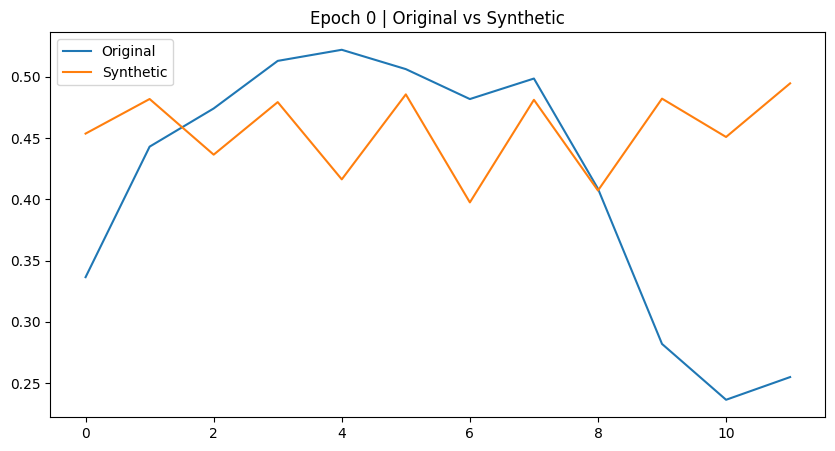

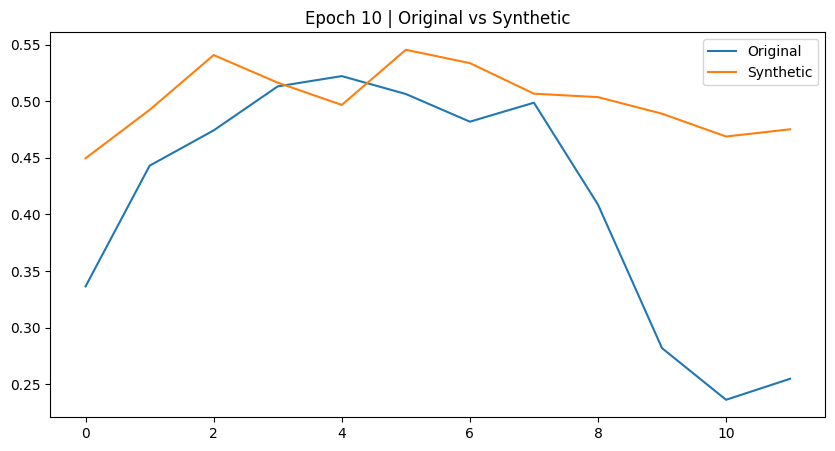

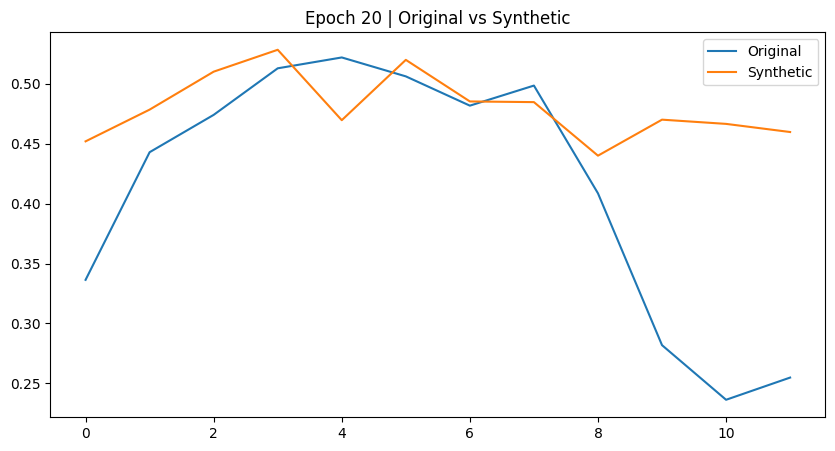

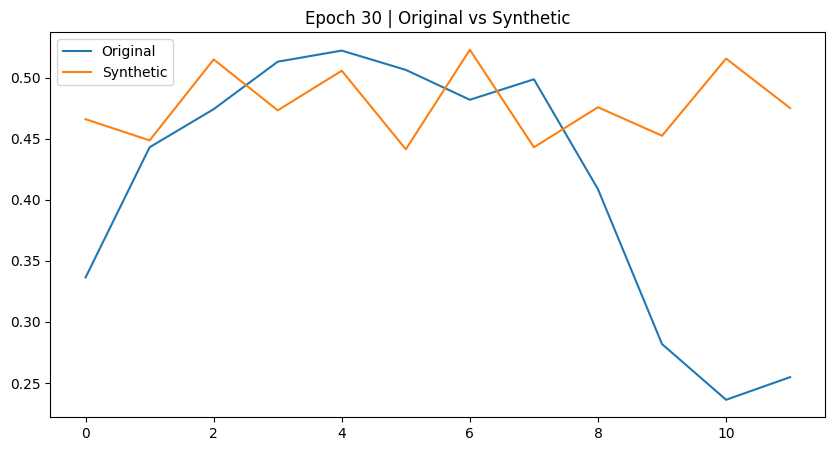

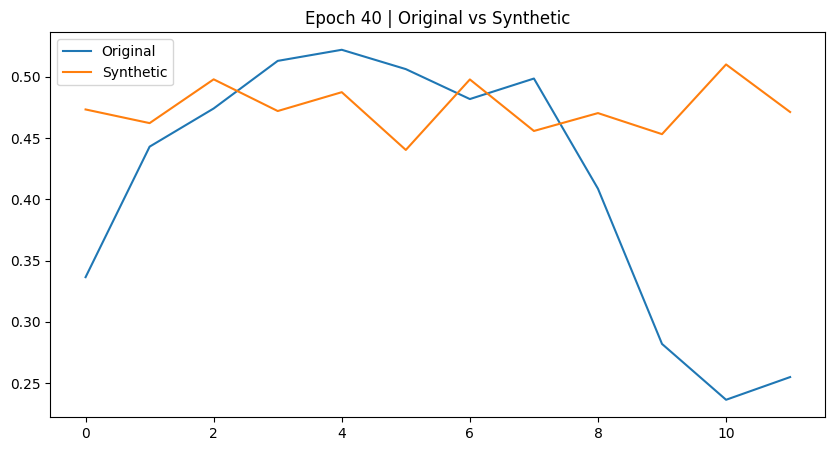

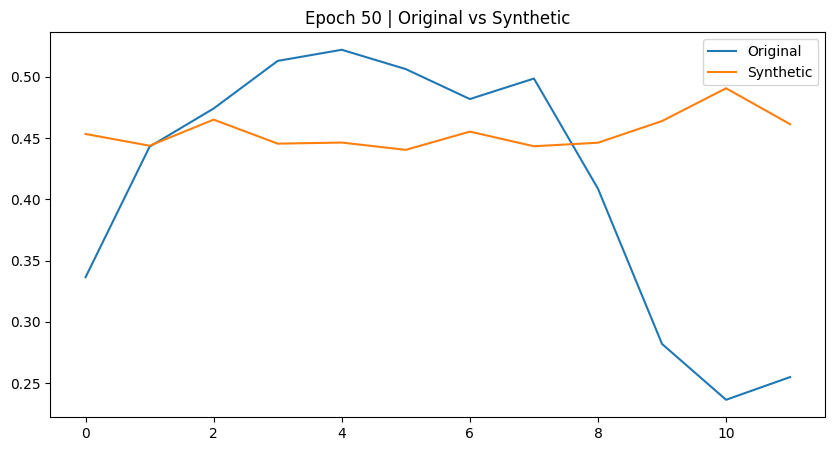

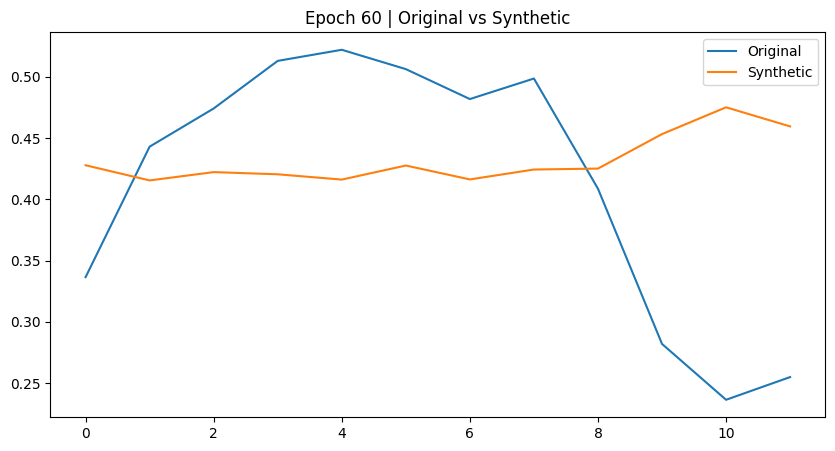

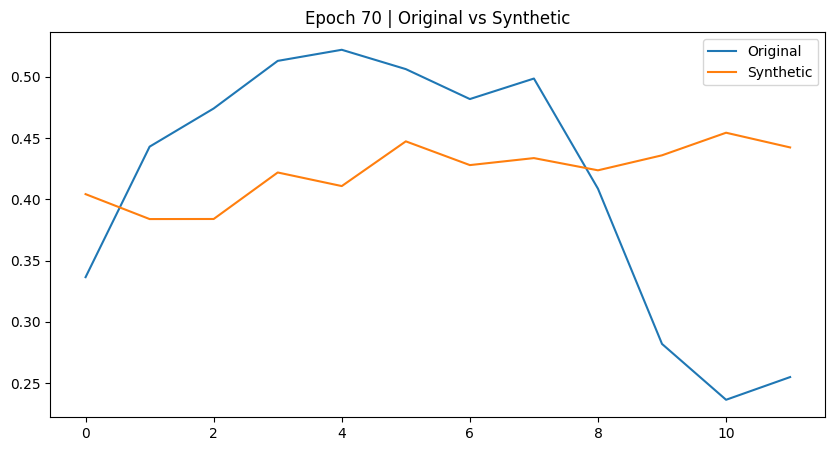

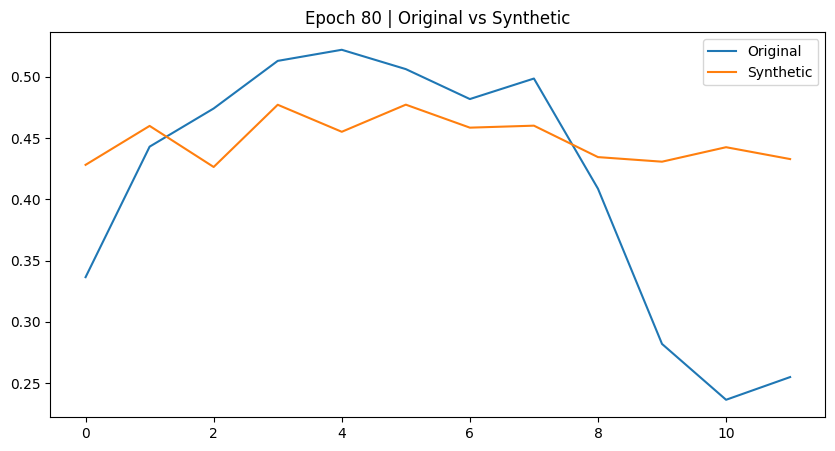

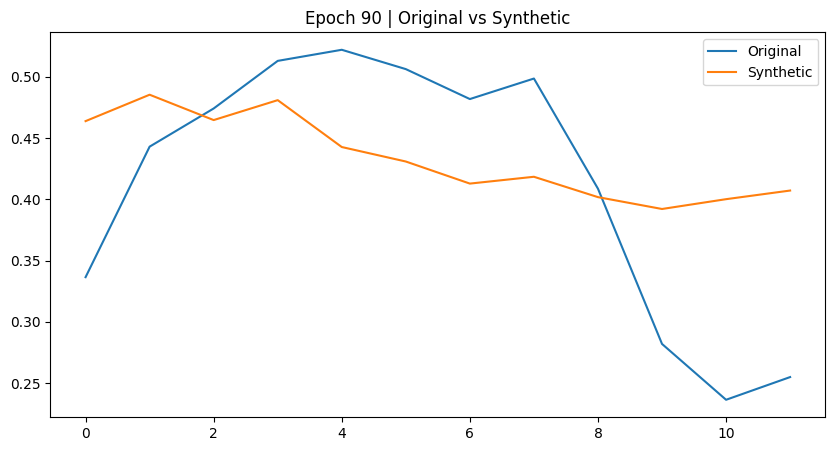

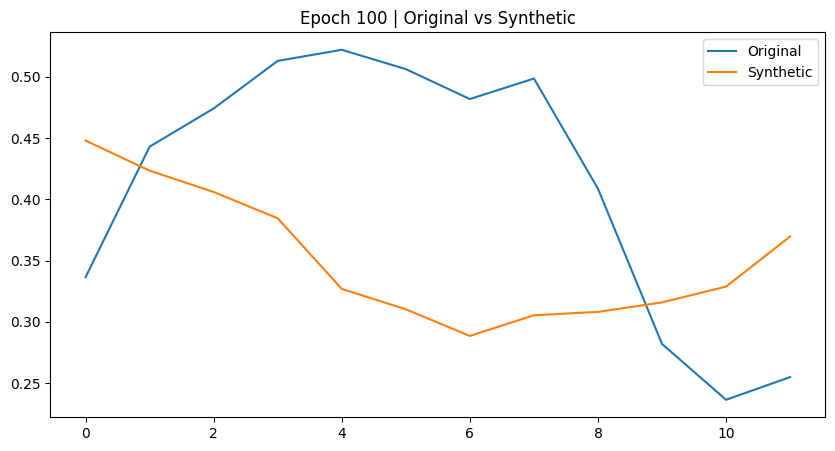

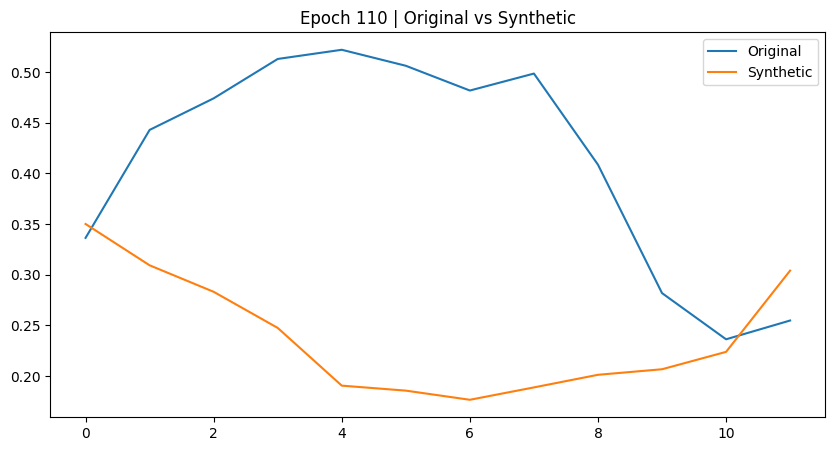

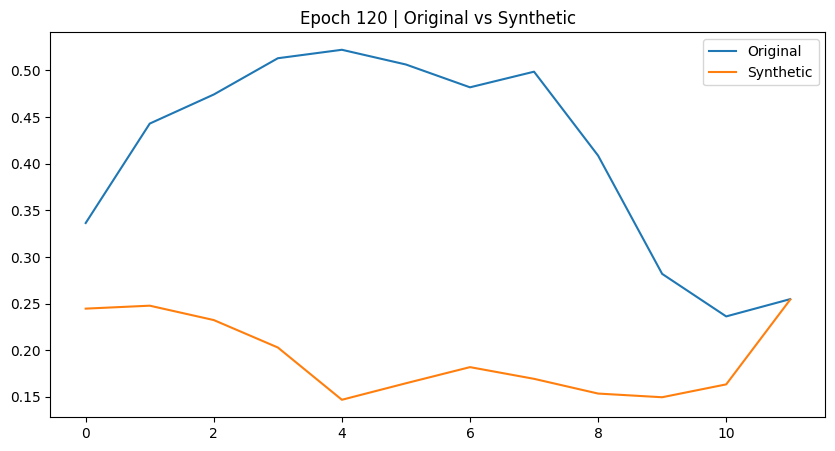

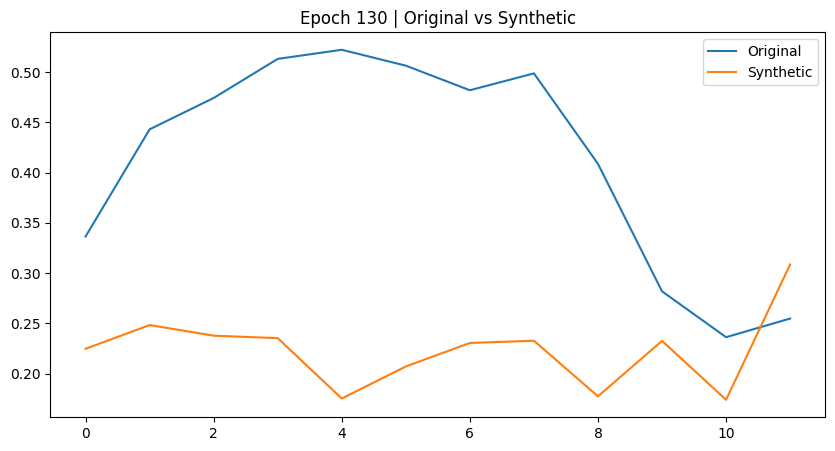

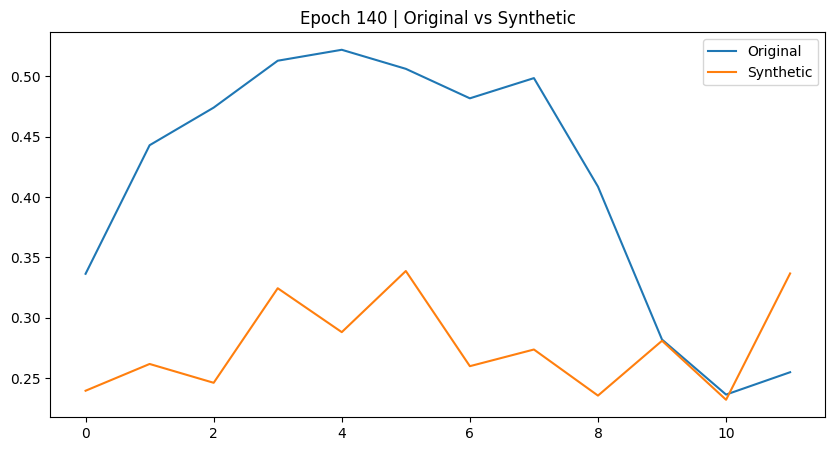

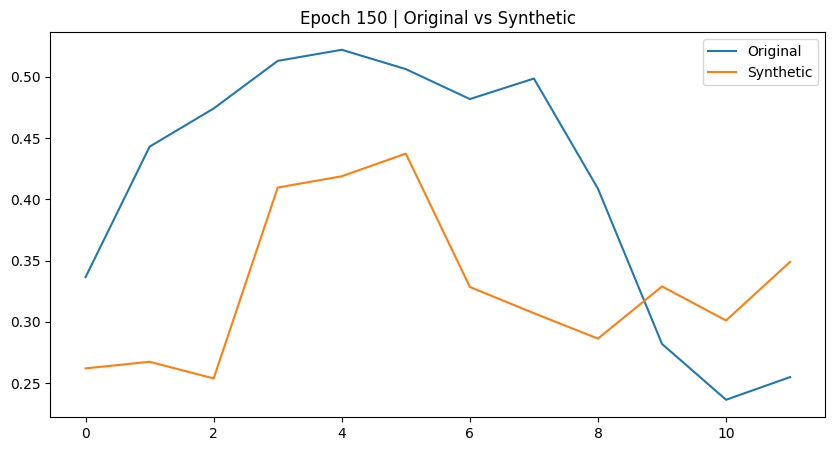

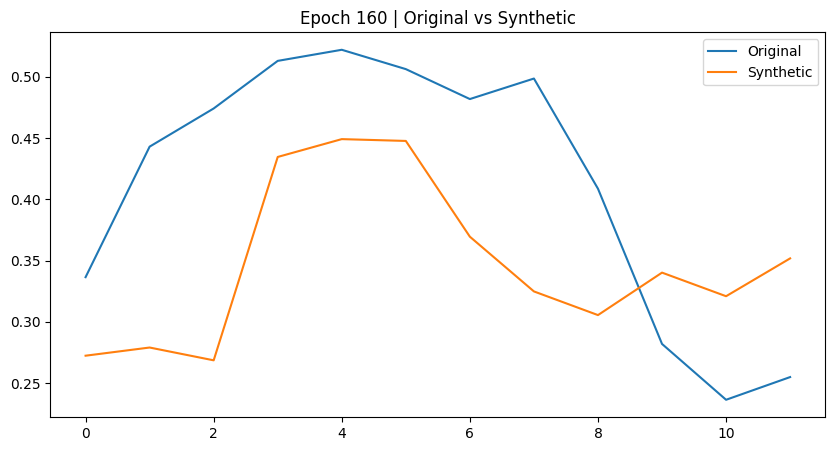

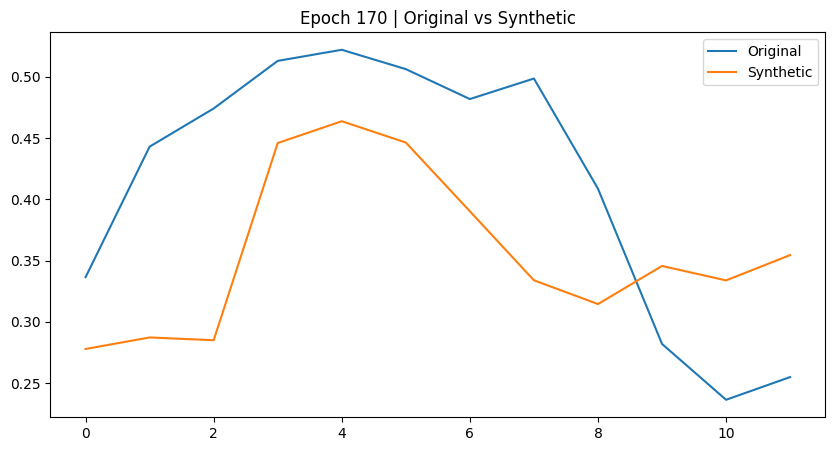

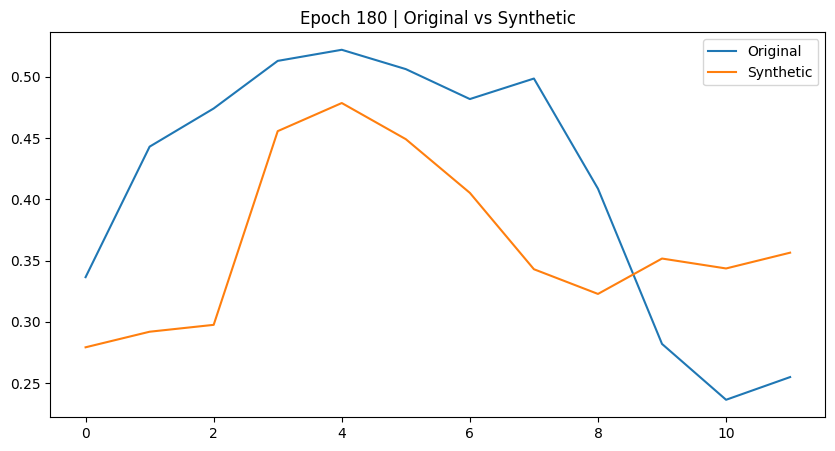

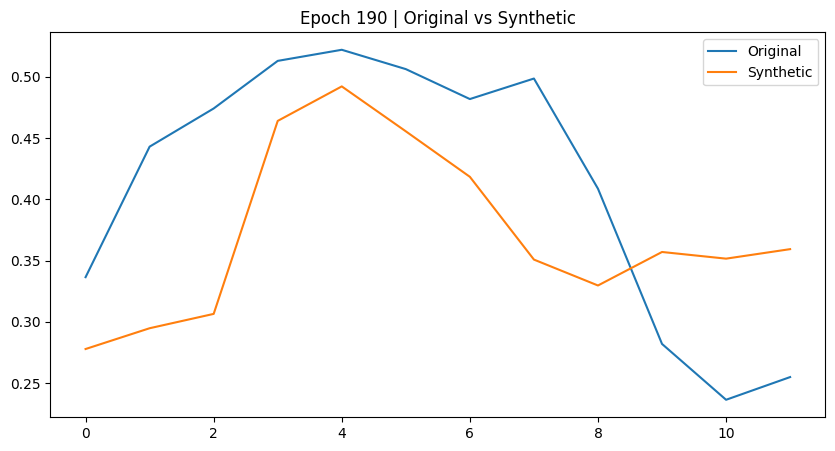

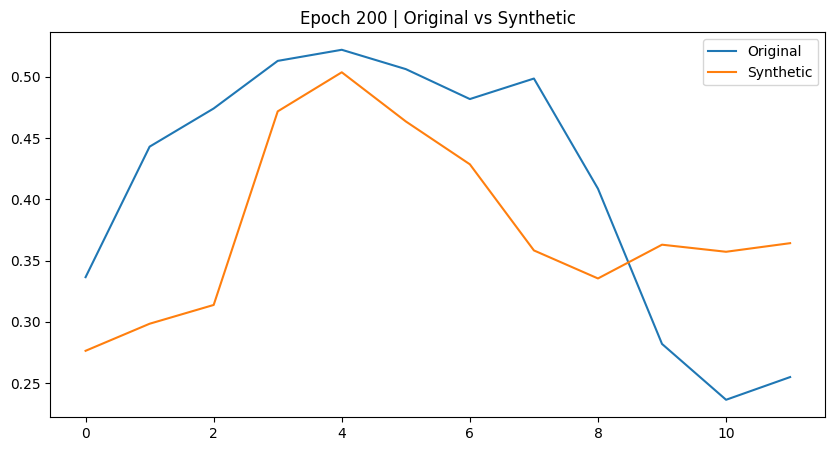

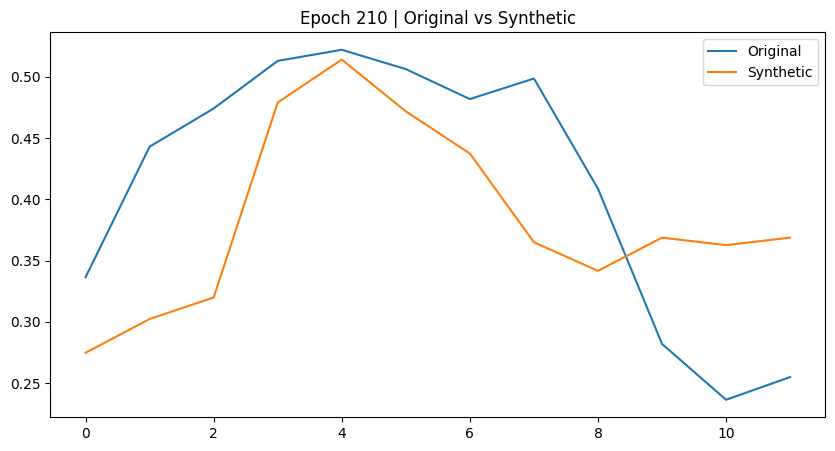

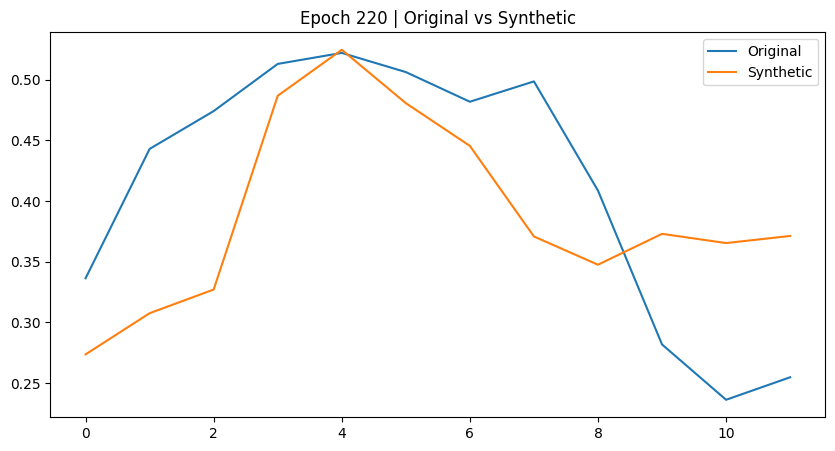

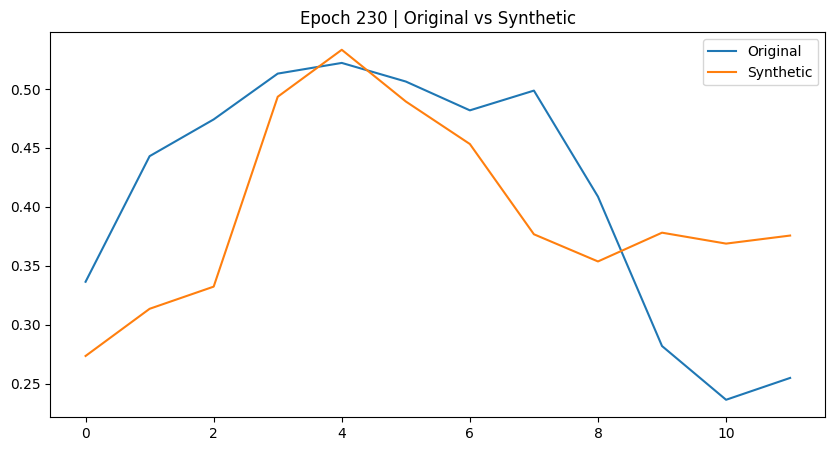

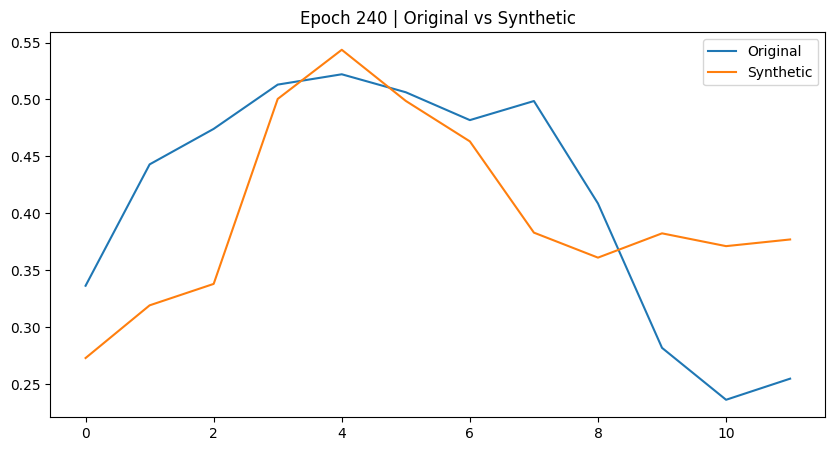

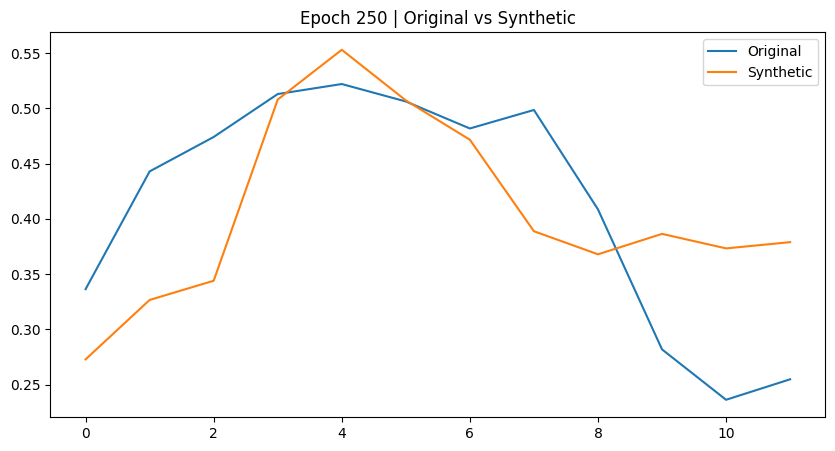

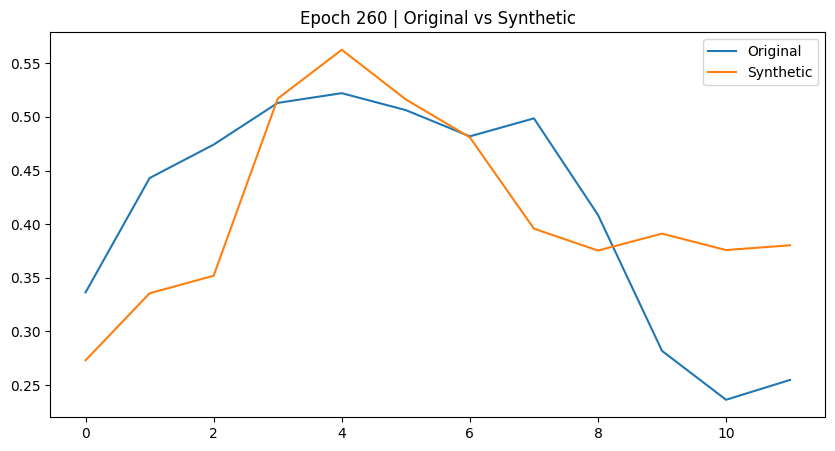

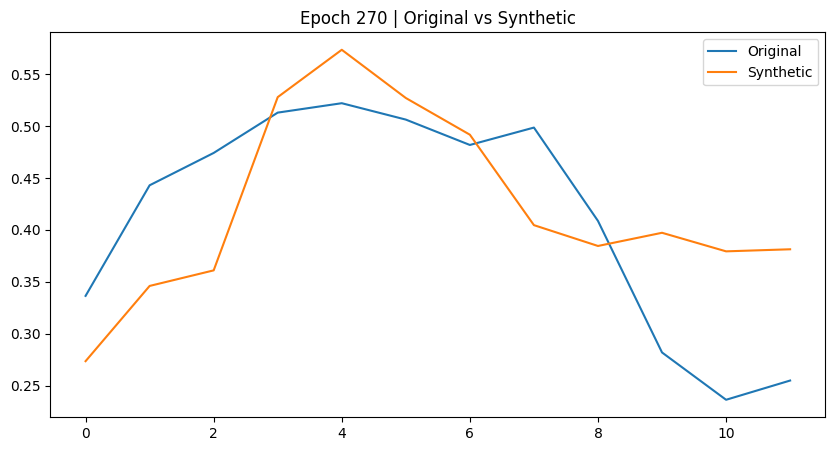

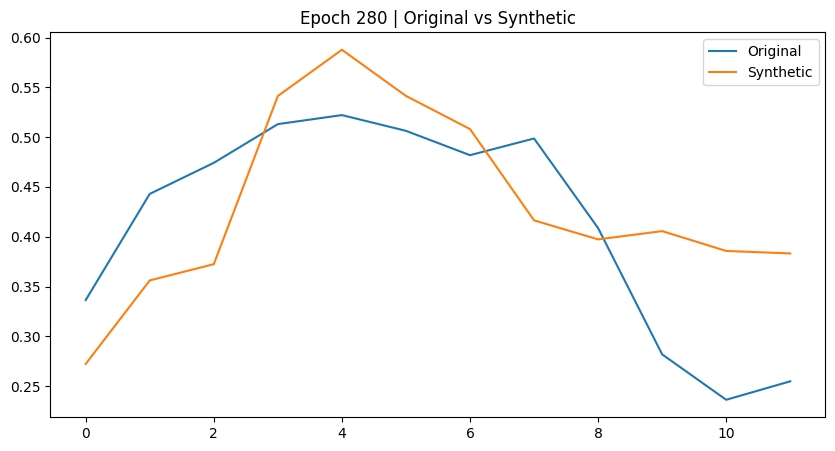

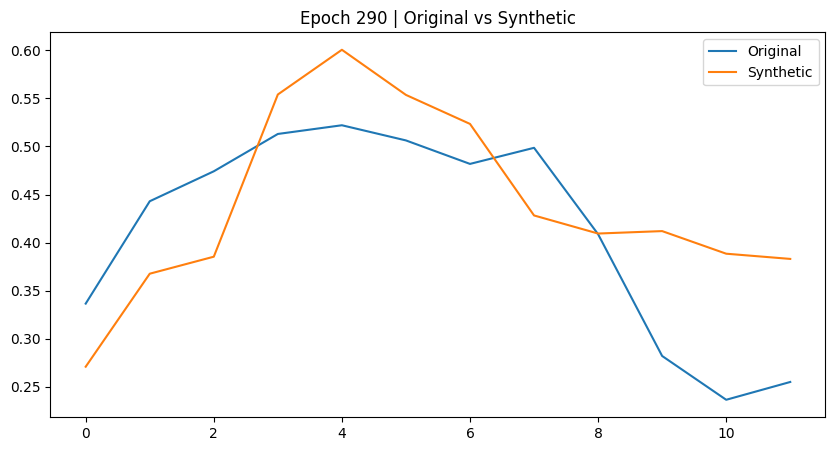

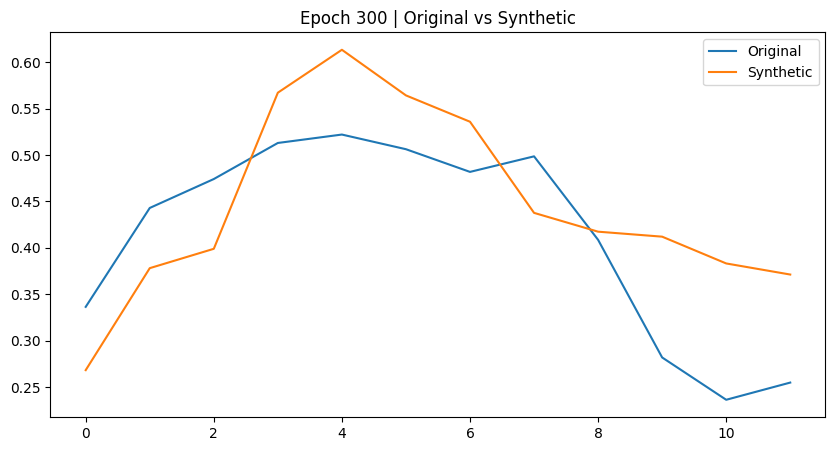

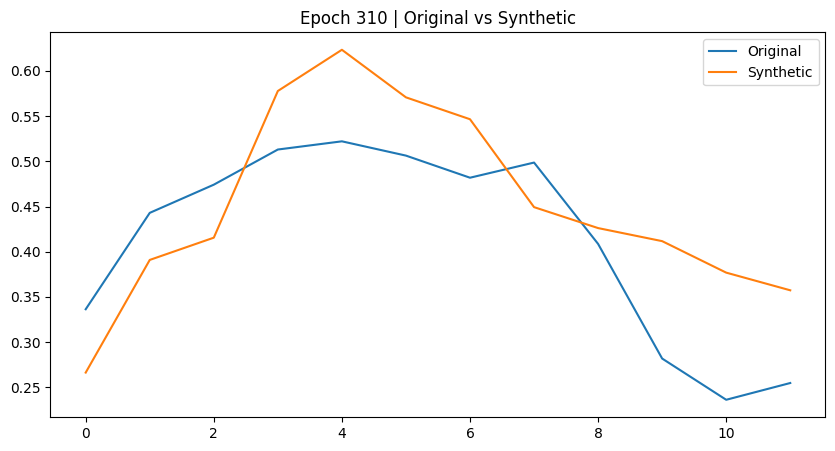

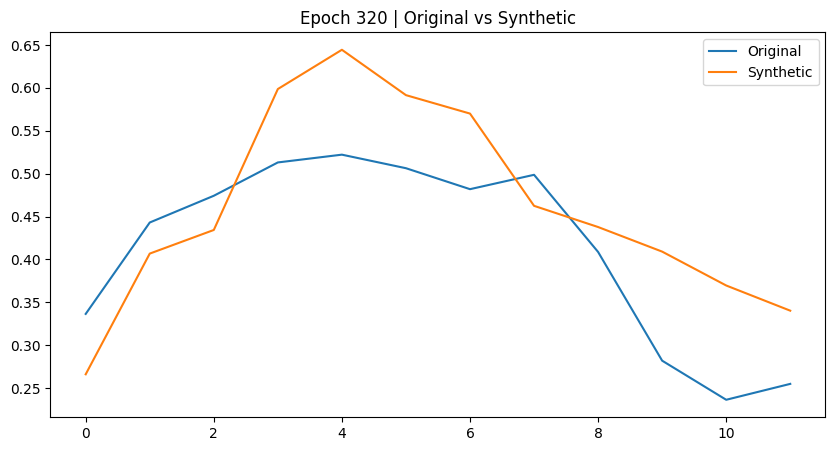

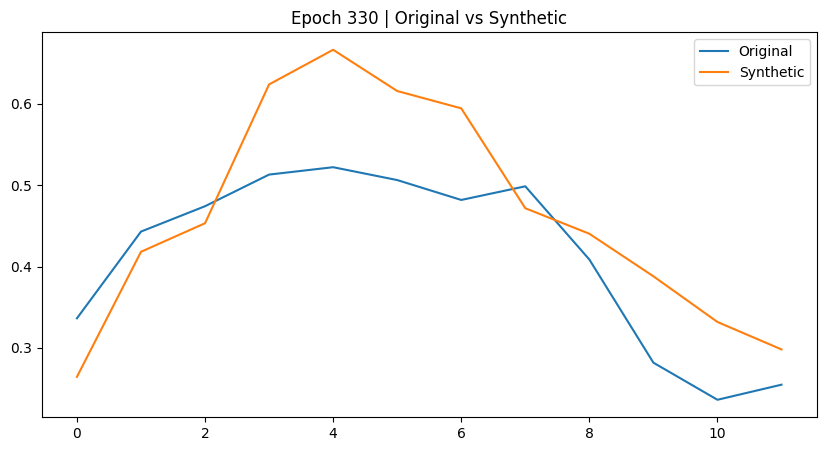

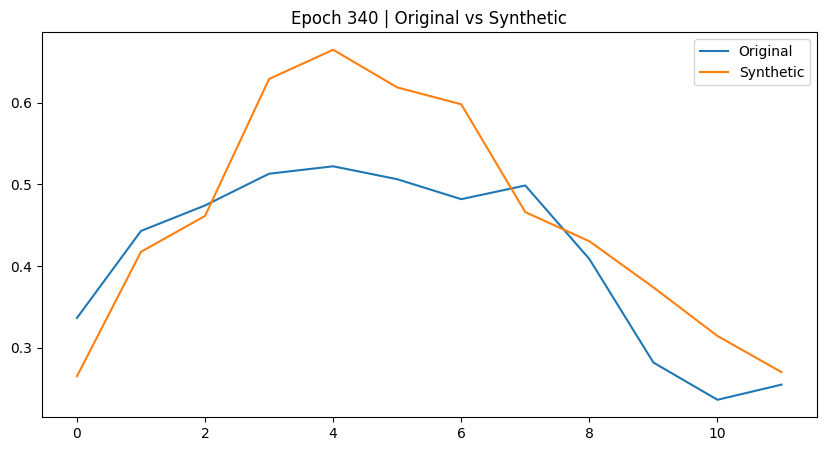

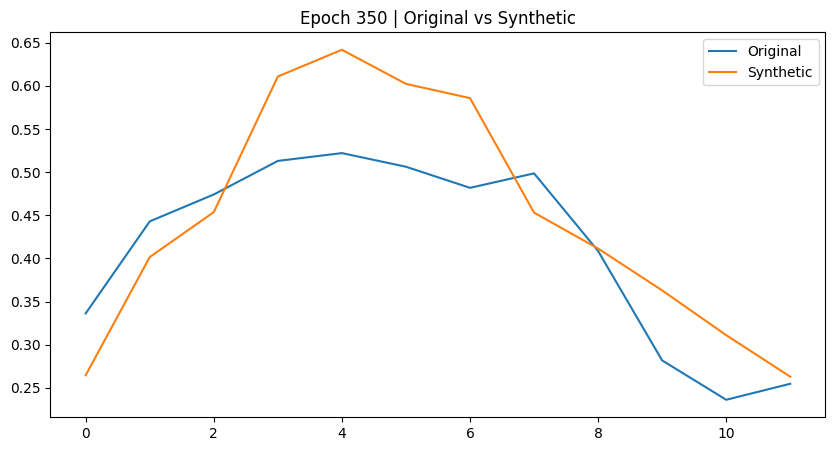

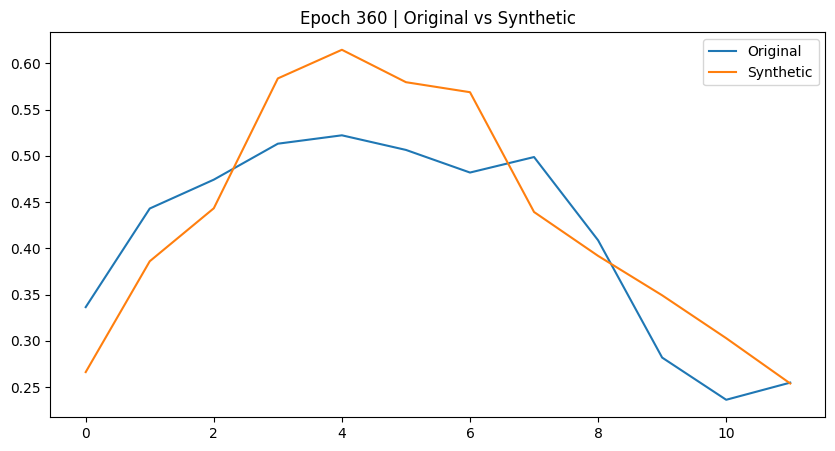

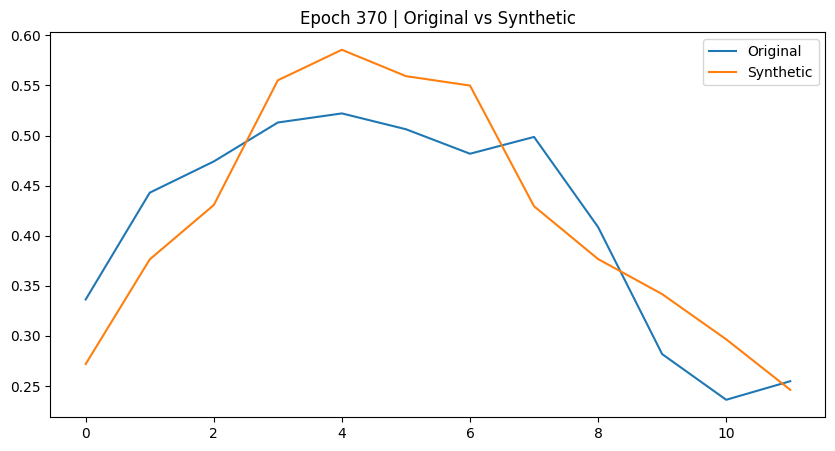

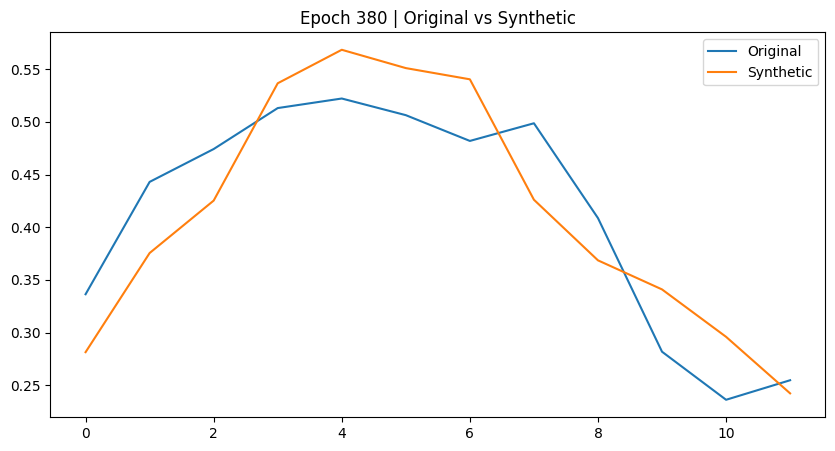

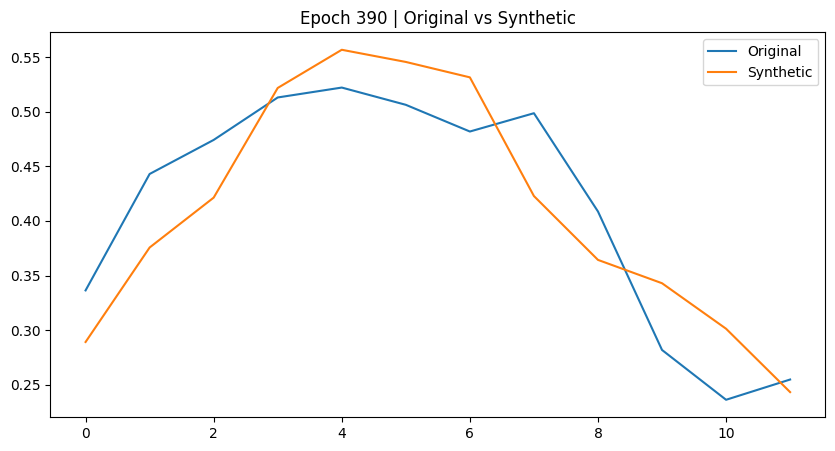

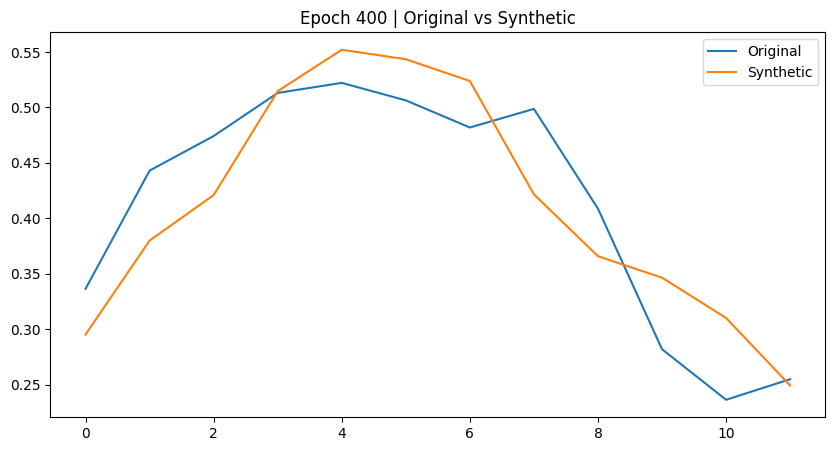

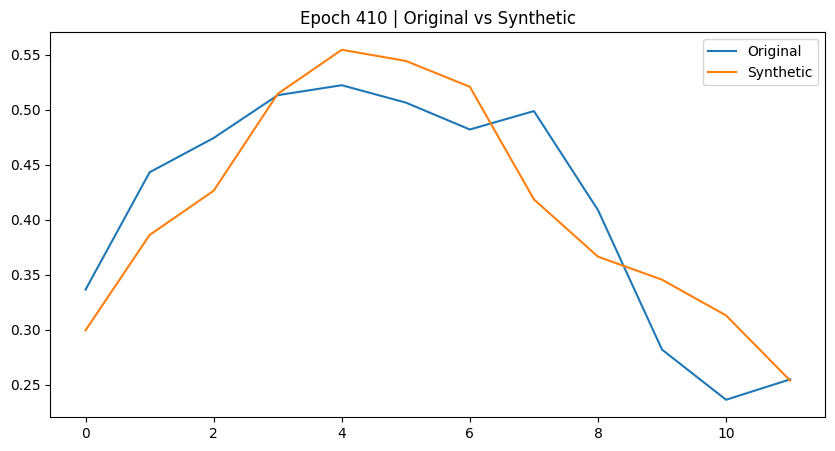

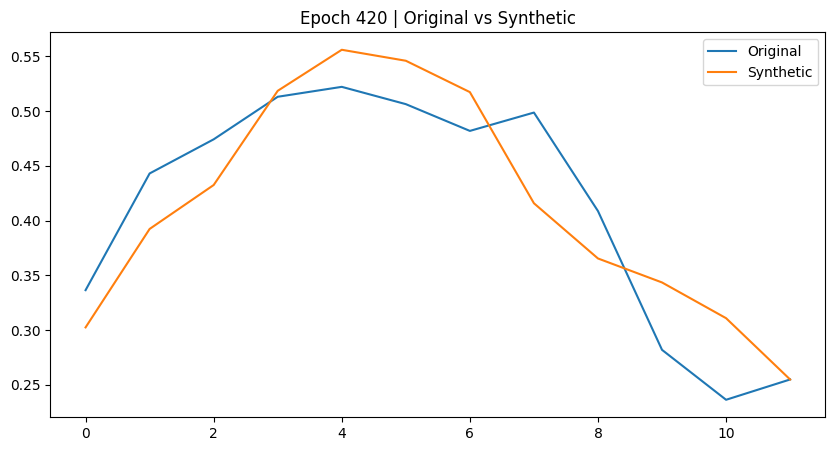

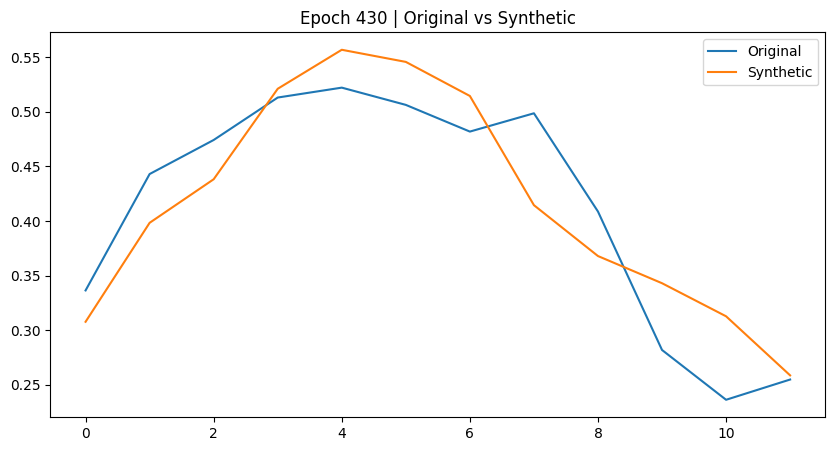

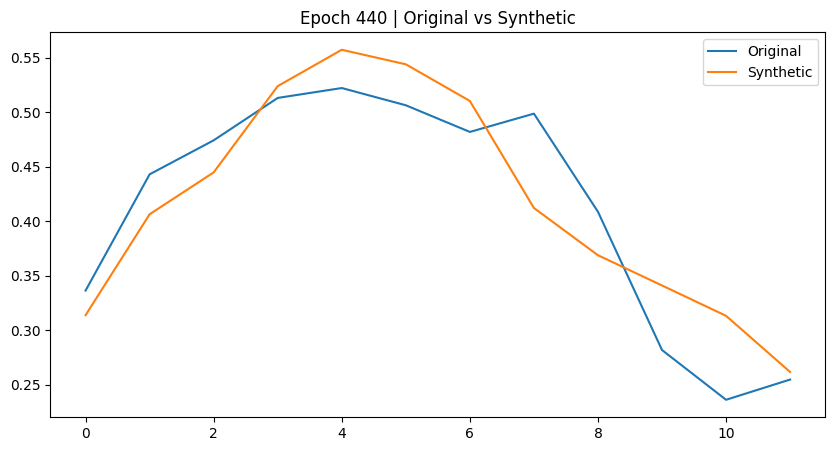

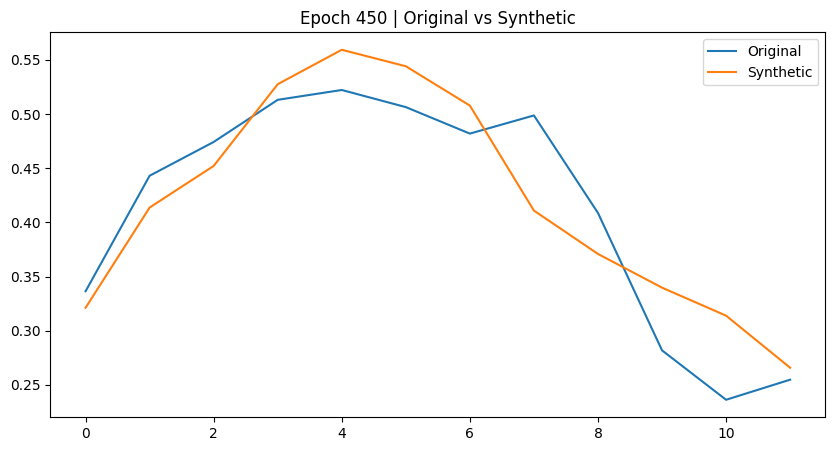

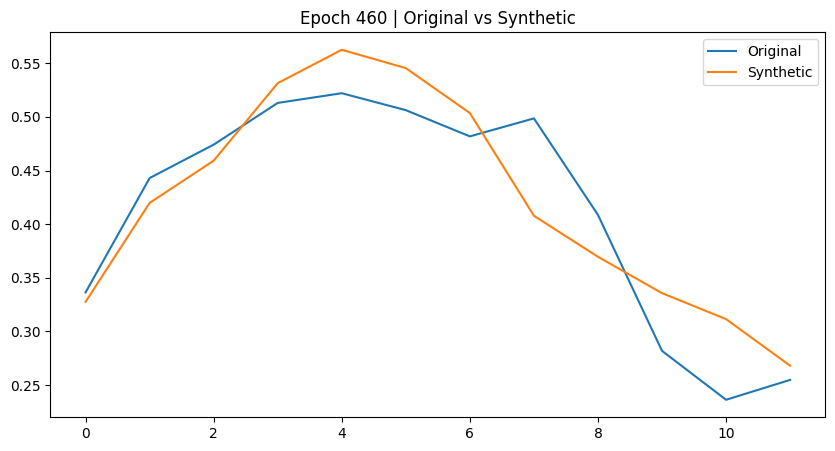

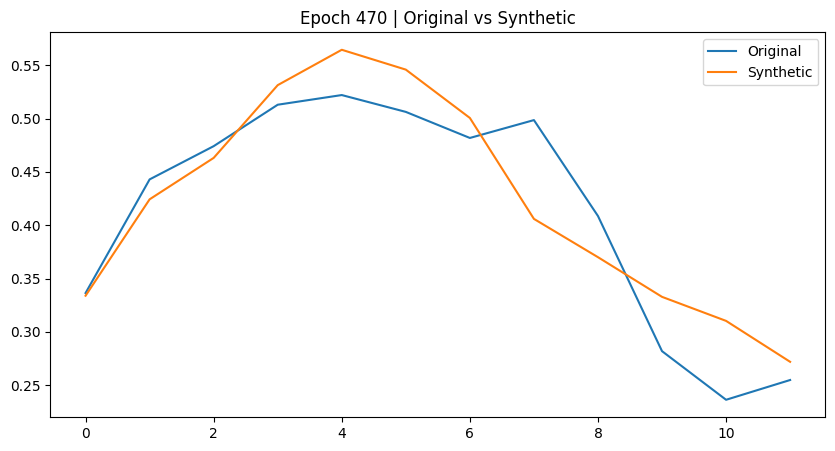

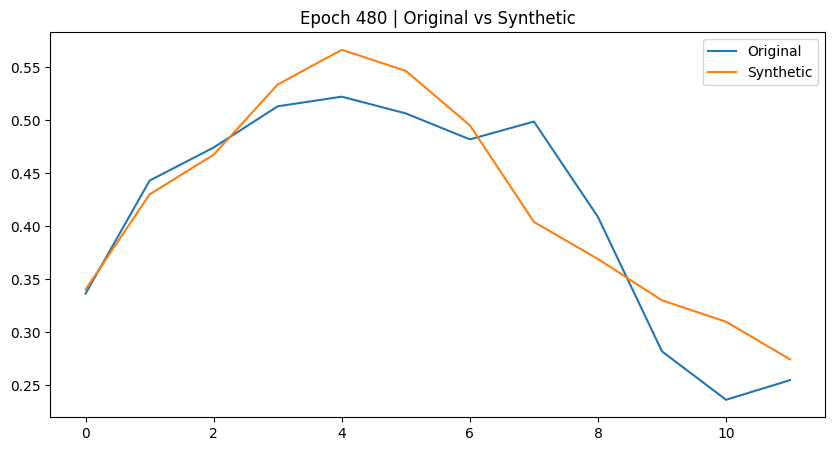

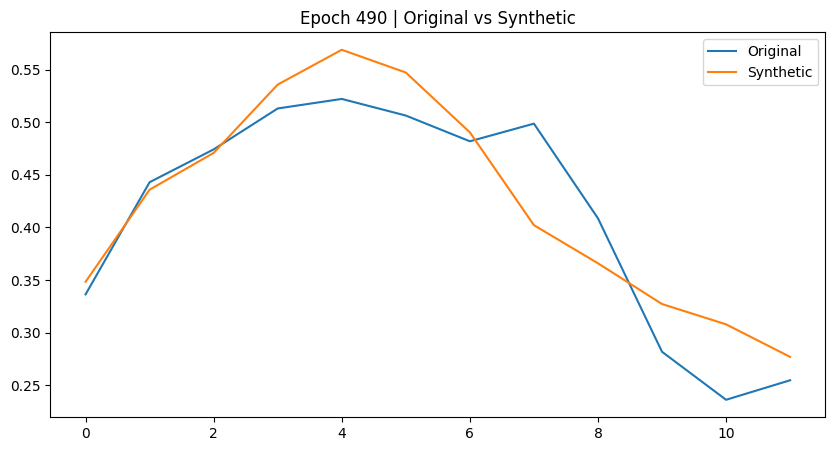

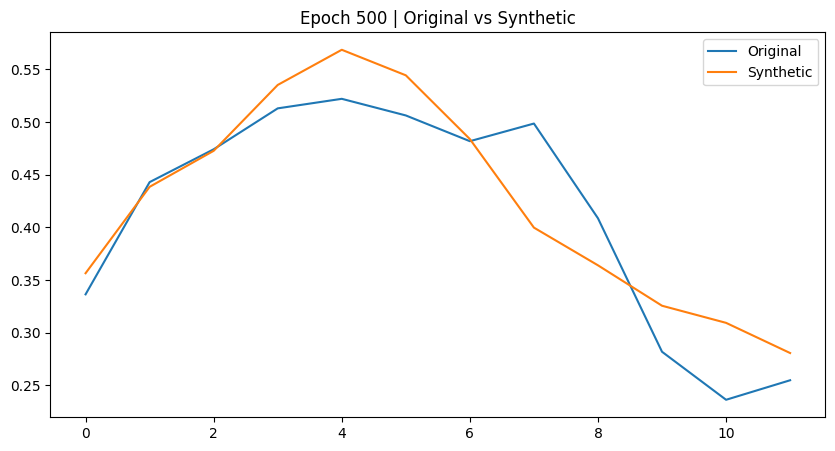

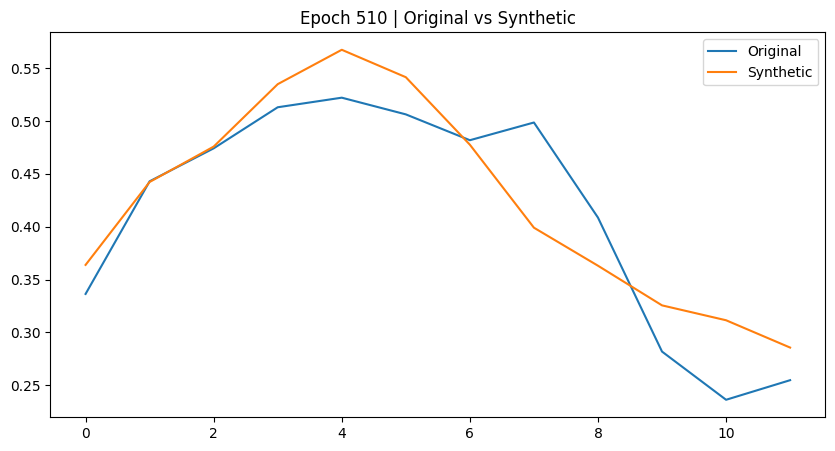

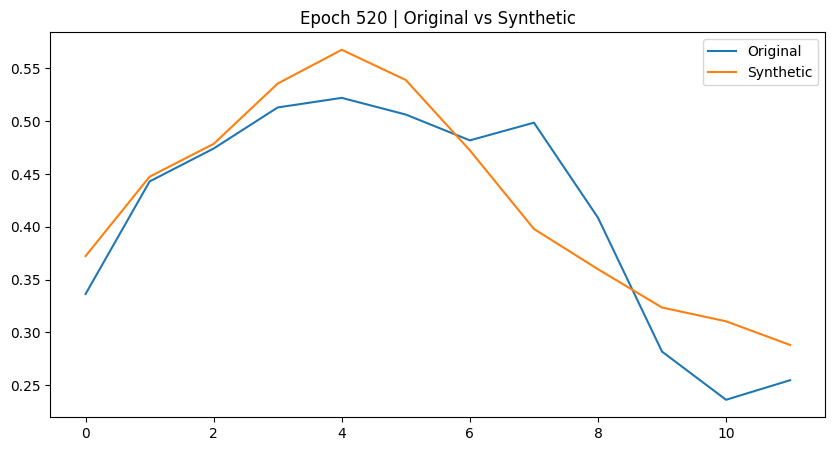

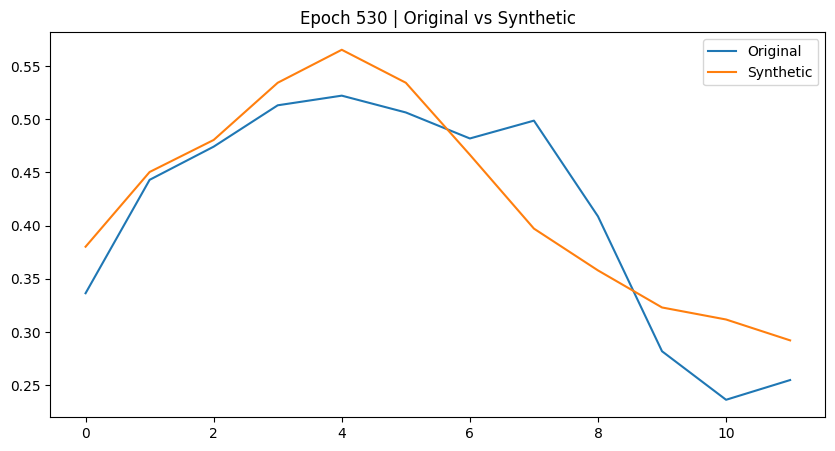

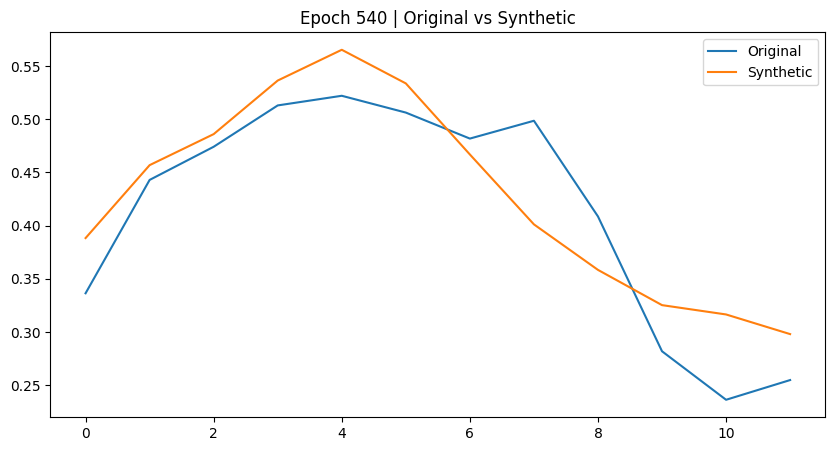

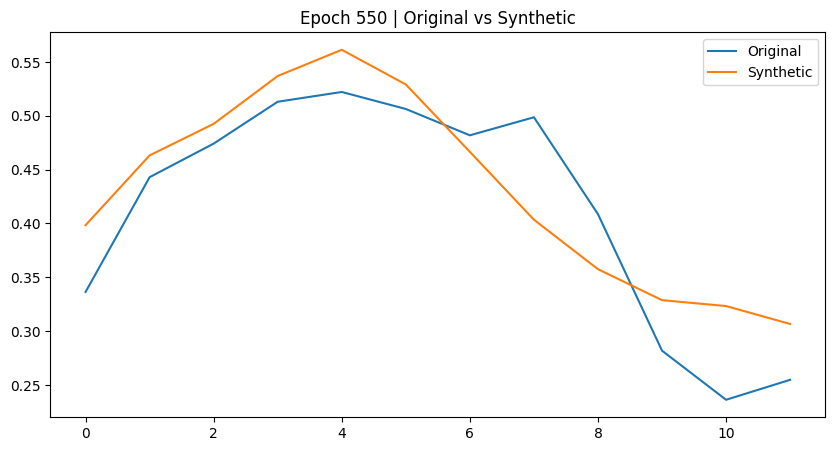

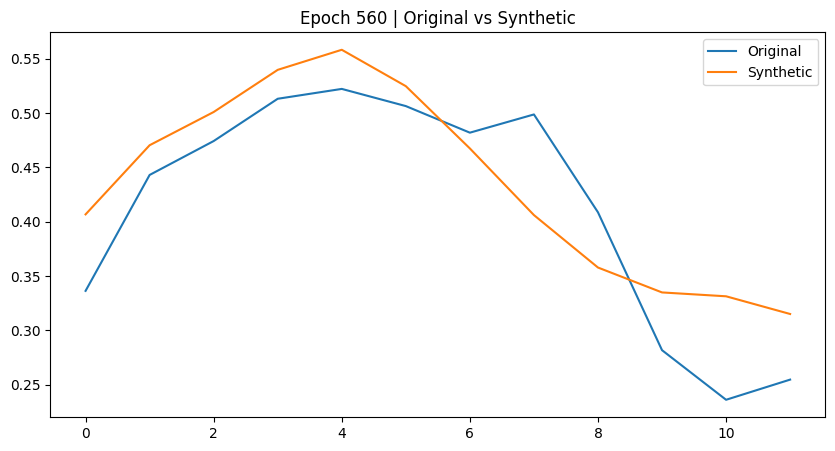

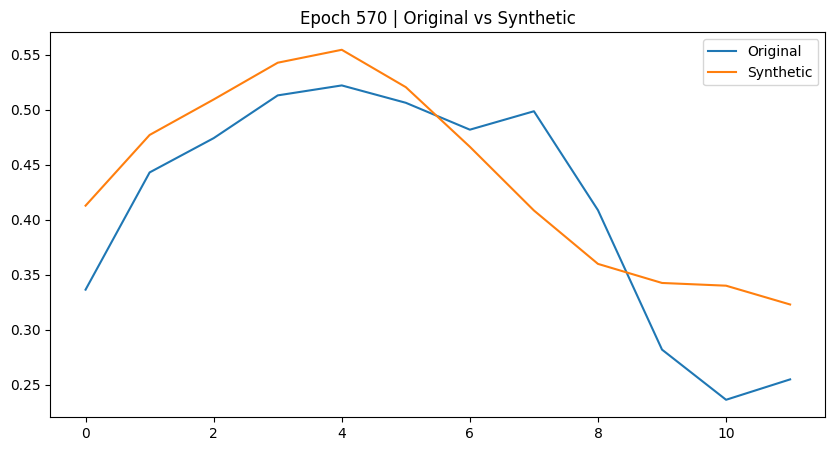

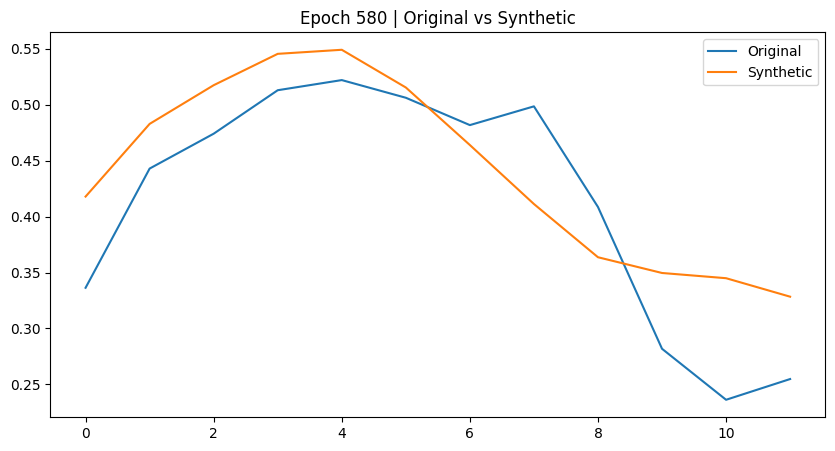

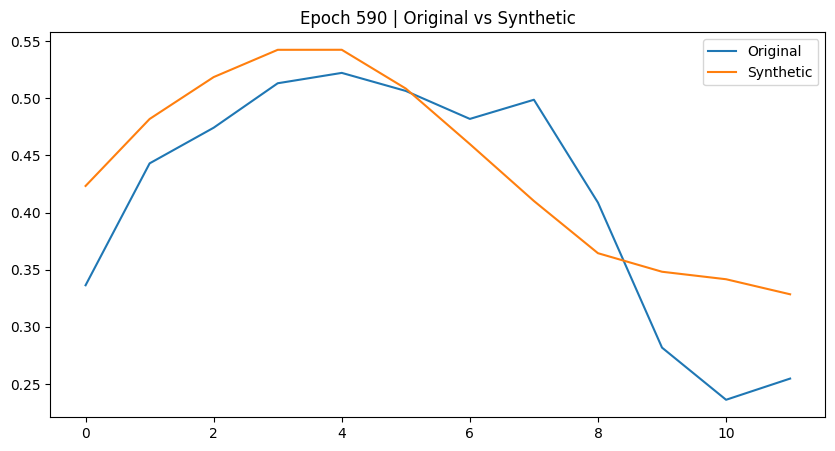

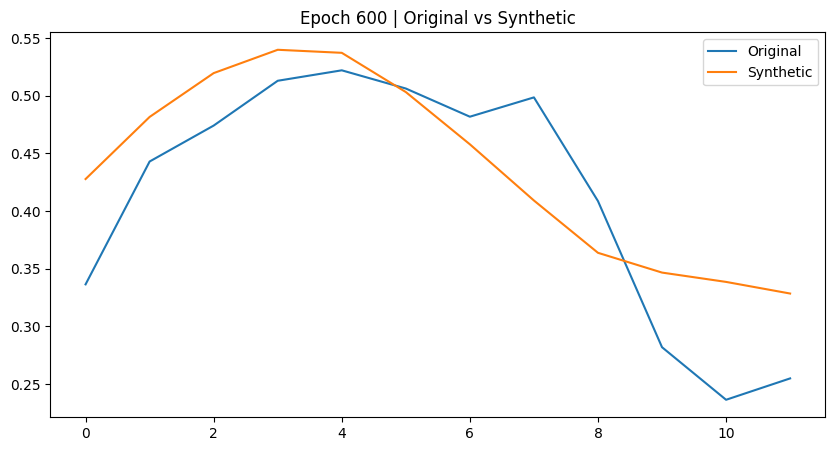

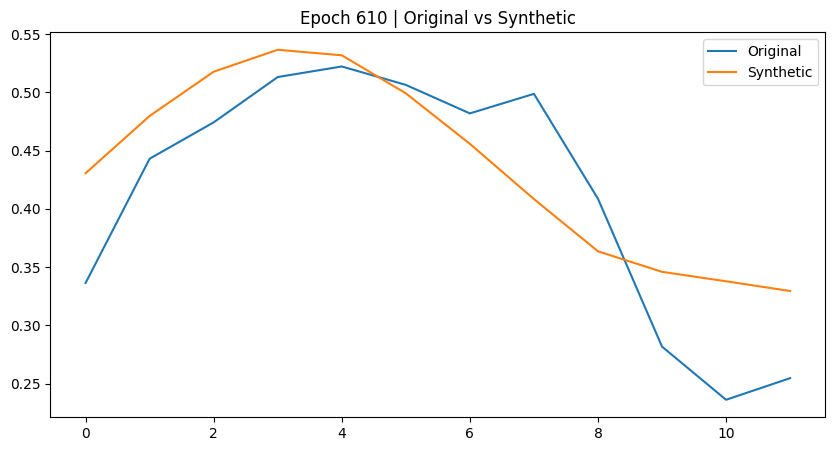

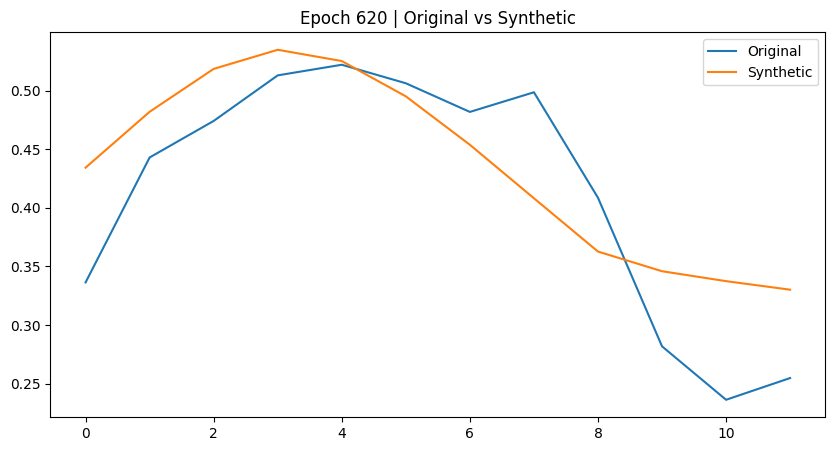

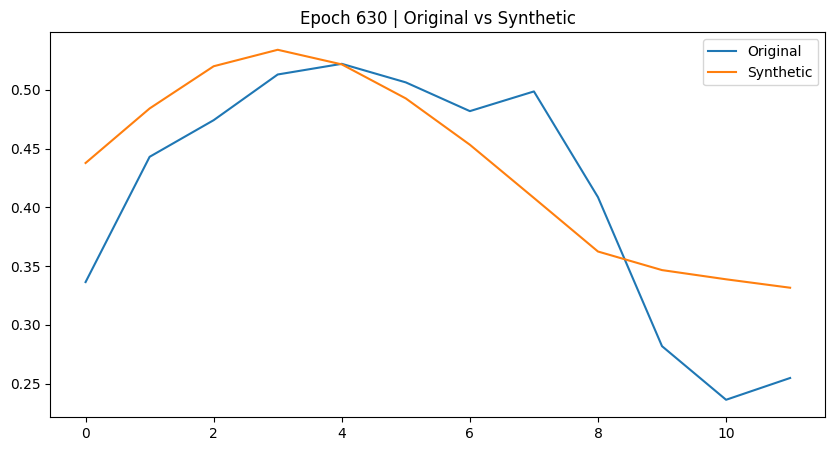

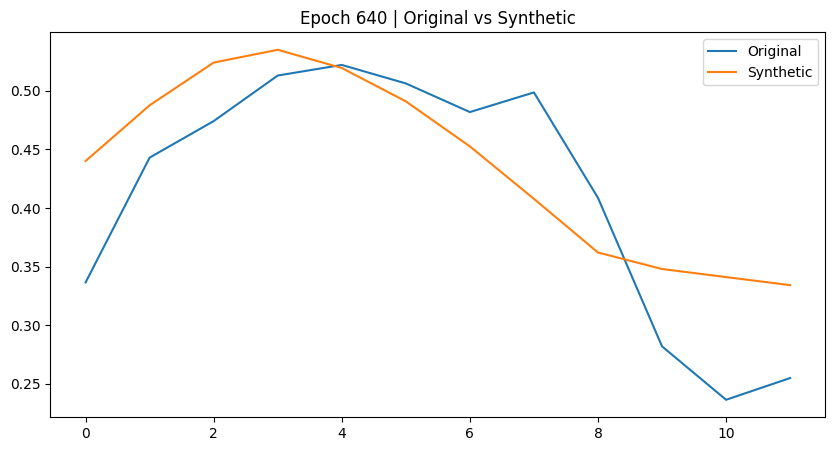

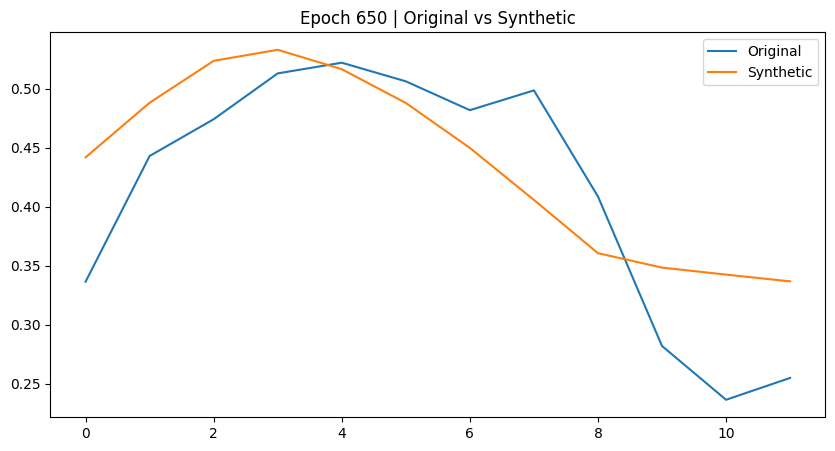

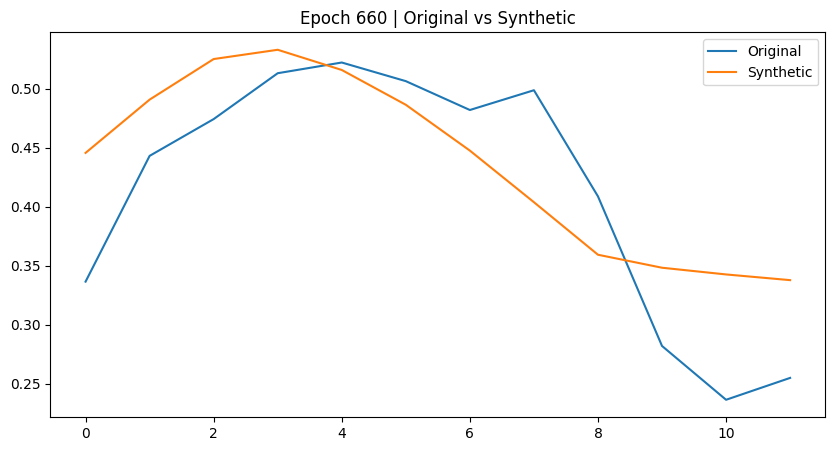

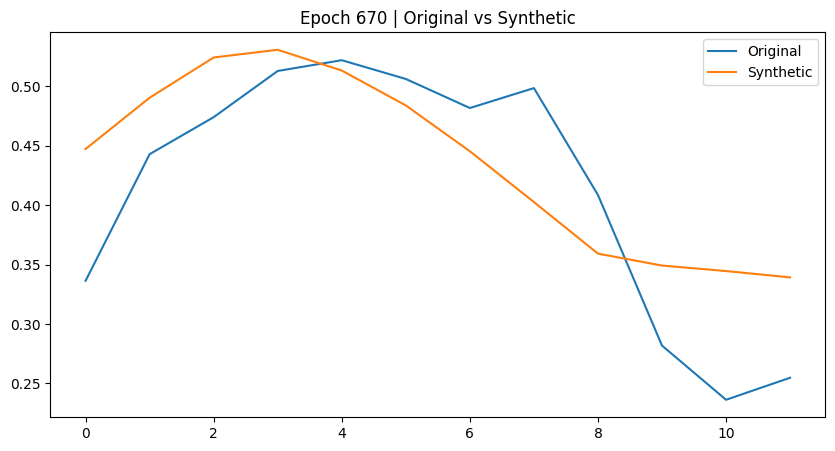

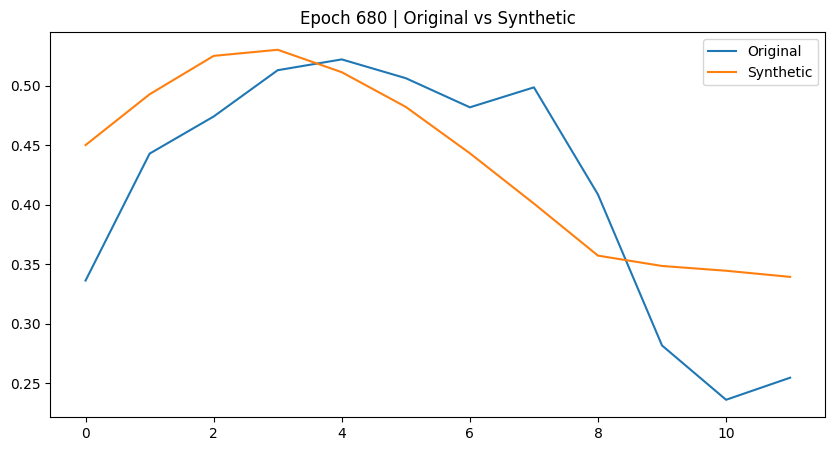

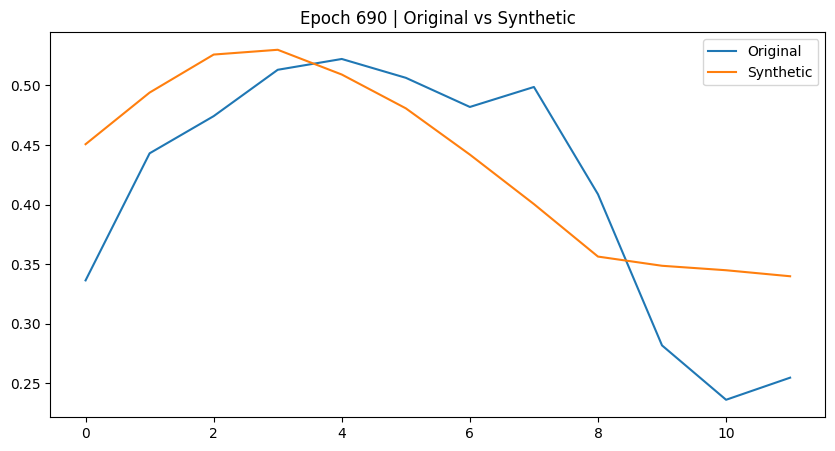

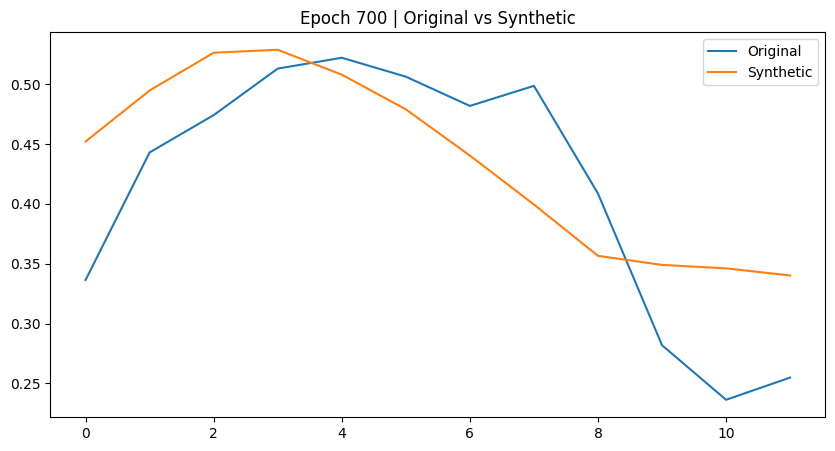

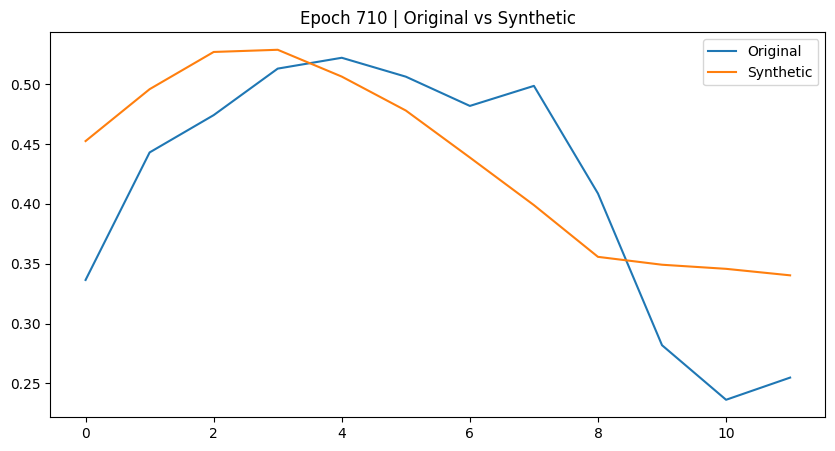

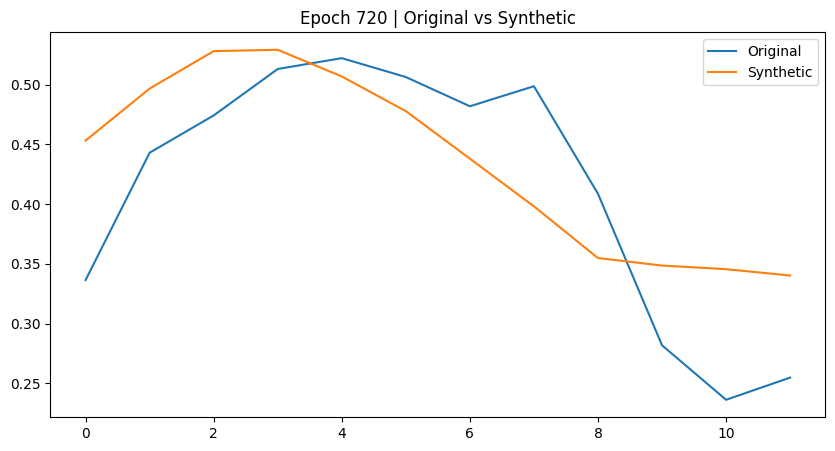

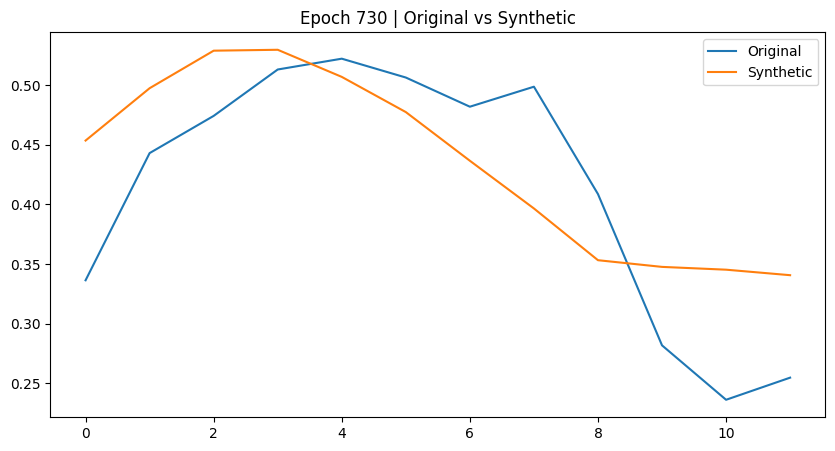

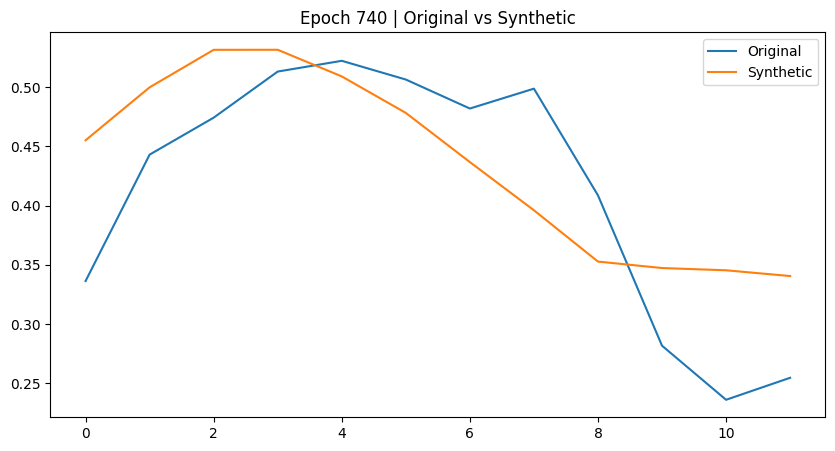

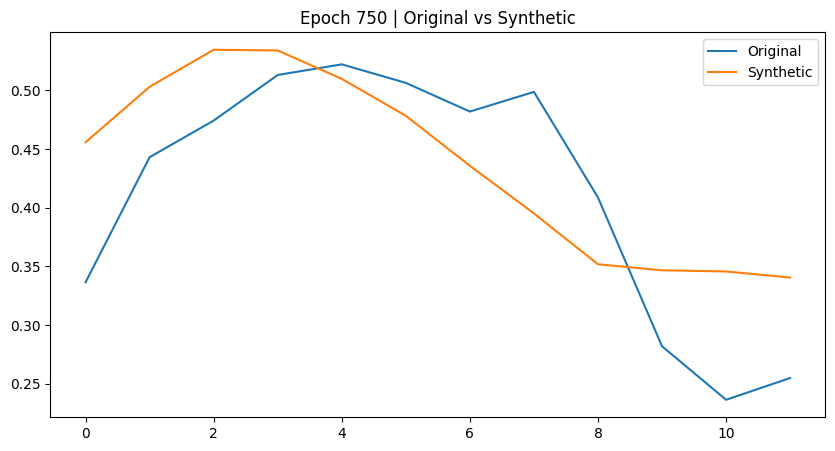

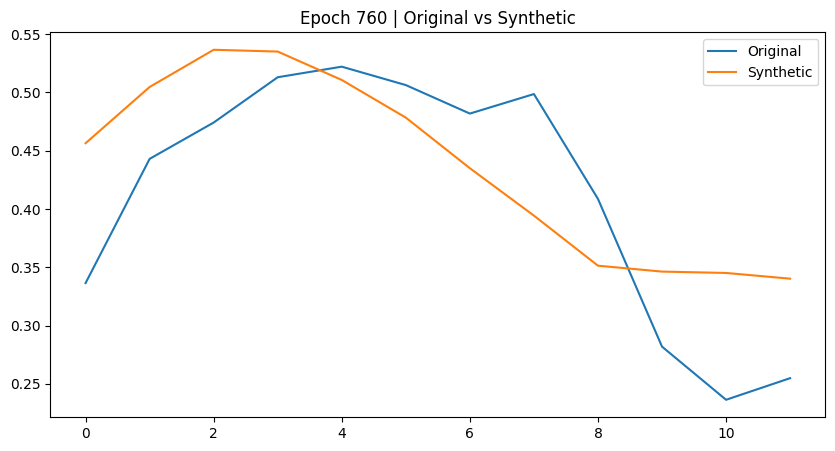

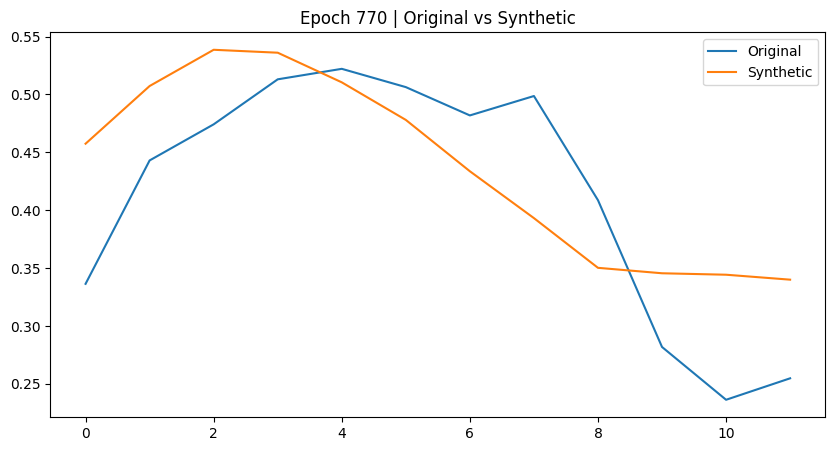

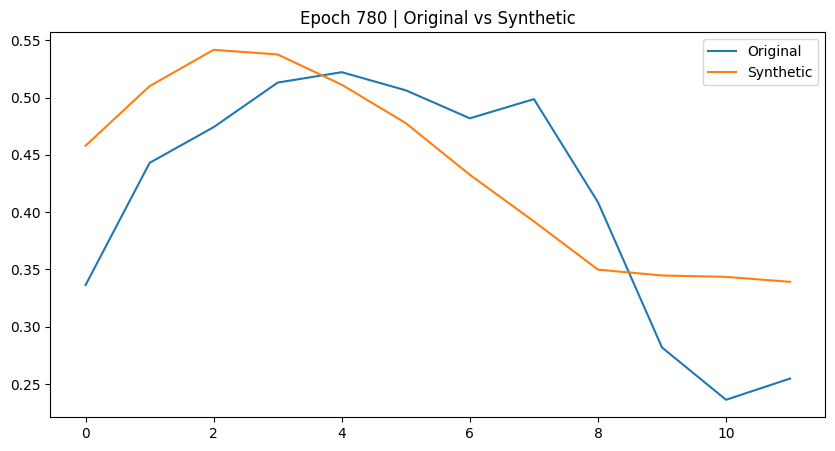

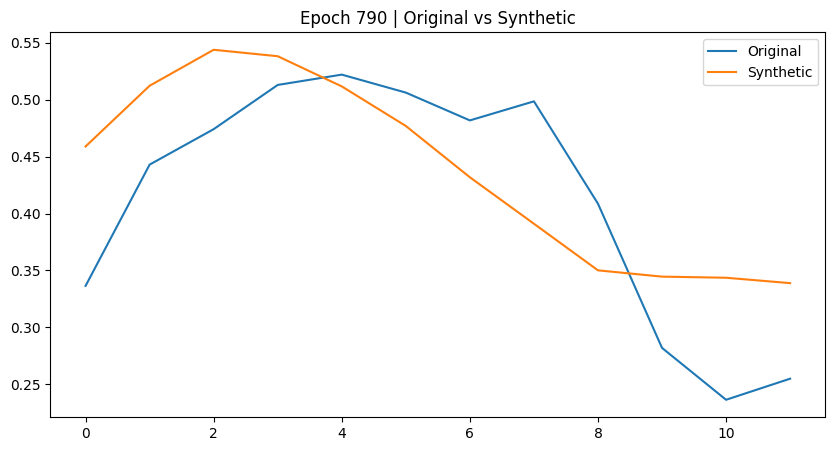

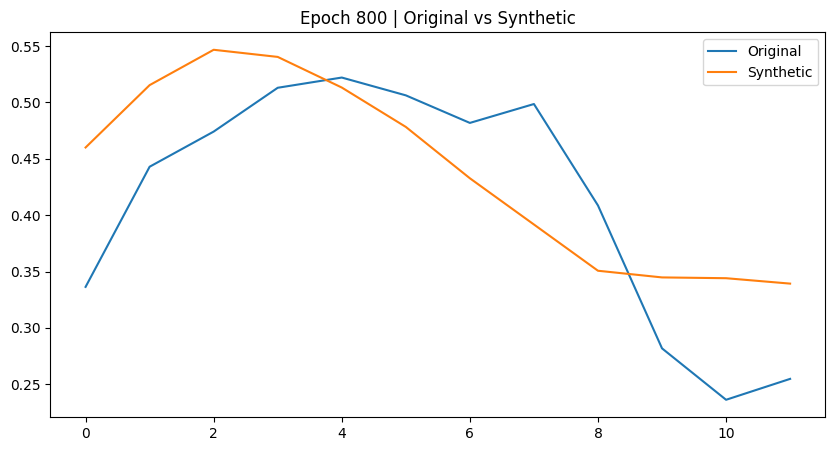

In [20]:
patience = 10
best_val_loss = np.inf
num_epochs_no_improvement = 0

for epoch in tqdm(range(hyperparameters['num_epochs'])):

    ### Training ###
    accumulated_train_loss = 0

    for _, (X_train, _) in enumerate(train_loader):

        model.train()
        X_train = X_train.float().to(hyperparameters['device'])

        X_train_hat = model(X_train)

        # weigh first 2 features higher
        X_train_hat_copy = X_train_hat.clone()
        X_train_copy = X_train.clone()

        X_train_hat_copy[:, :, 0] *= 2
        X_train_hat_copy[:, :, 1] *= 2
        X_train_copy[:, :, 0] *= 2
        X_train_copy[:, :, 1] *= 2

        train_loss = criterion(X_train_hat, X_train)
        accumulated_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()


    ### Validation ###
    accumulated_val_loss = 0
    model.eval()
    with torch.inference_mode():

        for _, (X_val, _) in enumerate(val_loader):
            X_val = X_val.float().to(hyperparameters['device'])

            X_val_hat = model(X_val)

            # weigh first 2 features higher
            X_val_hat_copy = X_val_hat.clone()
            X_val_copy = X_val.clone()

            X_val_hat_copy[:, :, 0] *= 2
            X_val_hat_copy[:, :, 1] *= 2
            X_val_copy[:, :, 0] *= 2
            X_val_copy[:, :, 1] *= 2

            val_loss = criterion(X_val_hat, X_val)
            accumulated_val_loss += val_loss.item()


        # Check for early stopping
        if accumulated_val_loss < best_val_loss:
            best_val_loss = accumulated_val_loss
            num_epochs_no_improvement = 0

        else:
            print(f'INFO: Validation loss did not improve in epoch {epoch + 1}')
            num_epochs_no_improvement += 1


    ### Logging and Plotting ###

    print(f'Epoch: {epoch} \n\b Train Loss: {accumulated_train_loss / len(train_loader)} \n\b Val Loss: {accumulated_val_loss / len(val_loader)}')
    print('*' * 50)

    if epoch % 10 == 0:
        plot_train = dc(X_train.detach().numpy())
        plot_hat = dc(X_train_hat.detach().numpy())

        plt.figure(figsize=(10, 5))
        plt.title(f'Epoch {epoch} | Original vs Synthetic')
        plt.plot(plot_train[0, :, 0], label='Original')
        plt.plot(plot_hat[0, :, 0], label='Synthetic')
        plt.legend()

    if num_epochs_no_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

        


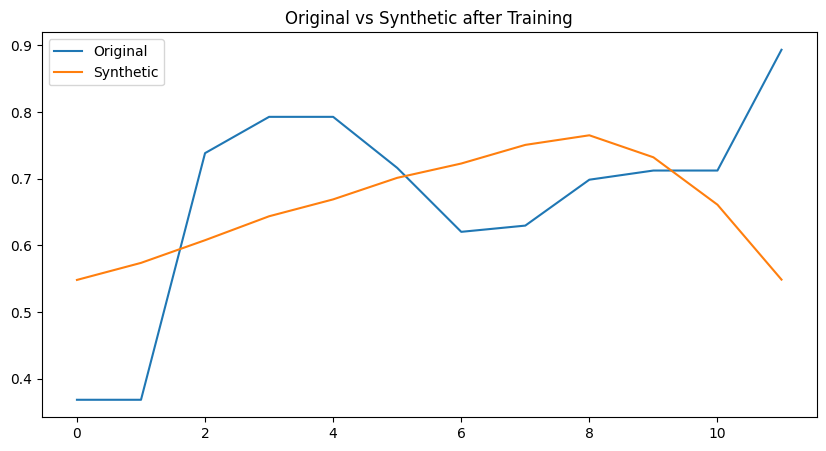

In [44]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

model.eval()
with torch.inference_mode():
    test_pred = model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [57]:
model.eval()
with torch.inference_mode():
    syn_train = model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [58]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([22797, 12, 5]),
 torch.Size([2840, 12, 5]),
 torch.Size([2841, 12, 5]))

In [59]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [60]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [61]:
result.shape

(28478, 12, 5)

In [62]:
no, seq, dim = result.shape
result = result.reshape(no, seq*dim)

In [63]:
# np.savetxt(f'mitv_{28478}_{12}_{5}_autoencoder.csv', result, delimiter=',')